# Advance Lane Detection pipeline


The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing your pipeline on single frames. If you want to extract more test images from the videos, you can simply use an image writing method like cv2.imwrite(), i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called output_images, and include a description in your writeup for the project of what each image shows. The video called project_video.mp4 is the video your pipeline should work well on.

The challenge_video.mp4 video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions. The harder_challenge.mp4 video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there! We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [46]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import math
import preprocessing_frames

In [23]:
# custom vars
calibration_dir = "camera_cal"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"
test_imgs_undist_dir = "test_images_undistorted"

# Read in the saved camera matrix and dist coeffs
dist_pickle = pickle.load(open("calibration_wide/wide_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# parameters
k_size = 15  # kernel_size
sobel_threshold_xy = (20, 120)  # Threshold value
mag_threshold = (80, 200)  # Threshold value
dir_threshold = (np.pi / 4, np.pi / 2)  # Threshold value
(height_y, width_x) = (719, 1279)  # Height and width of frames
src_pts = np.array([[210, height_y], [595, 450], [690, 450],
                    [1110, height_y]], np.float32)  # Source points for perspective transform
dst_pts = np.array([[200, height_y], [200, 0],
                    [1000, 0], [1000, height_y]], np.float32)  # Destination points for perspective transform


In [24]:
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 100
lane_size_metres = (32, 3.7)
lane_width = 1000 - 200  # 1000 -> right lane position, 200 -> left lane pos. after psp transform
lane_center = (1000 + 200) / 2

In [39]:
class LaneLine:
    def __init__(self):
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []


class AdvancedLaneLineDetector:
    def __init__(self):
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        self.img_dimensions = (720, 1280)
        self.ploty = np.linspace(0, self.img_dimensions[0] - 1, self.img_dimensions[0])
        self.real_world_lane_size = lane_size_metres
        self.ym_per_px = self.real_world_lane_size[0] / self.img_dimensions[0]
        self.xm_per_px = self.real_world_lane_size[1] / lane_width

    def process_frame(self, img):
        #img = mpimg.imread(fname)
        undist_img = self.undistort_img(img)
        preprocessed_frame = self.apply_transformation(undist_img)
        warped_frame = self.apply_perspective_transform(preprocessed_frame, src_pts, dst_pts)
        left_lane, right_lane, out_img = self.detect_lane_lines_pixels(warped_frame)
        left_curve, right_curve, center_offset = self.measure_curvature(left_lane, right_lane)
        lane_area_img = self.draw_lane_area(out_img, undist_img, left_lane, right_lane)
        processed_frame = self.draw_lane_curvature_text(lane_area_img, left_curve, right_curve, center_offset)
        print(left_curve, right_curve, center_offset)

        self.previous_left_lane_line = left_lane
        self.previous_right_lane_line = right_lane

        return processed_frame

    def undistort_img(self, img):
        return cv2.undistort(img, mtx, dist, None, mtx)

    def apply_transformation(self, image):
        img = np.copy(image)
        proc = preprocessing_frames.PreprocessingPipeline(k_size, sobel_threshold_xy, mag_threshold, dir_threshold)

        # Apply each of the thresholding functions
        gradx = proc.abs_sobel_thresh(img, orient='x')
        grady = proc.abs_sobel_thresh(img, orient='y')
        mag_binary = proc.mag_threshold(img)
        dir_binary = proc.dir_threshold(img)

        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_binary = proc.compute_white_yellow_lines(hls)

        combined_gradients = np.zeros_like(dir_binary)
        combined_gradients[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1) & (grady == 1))] = 1

        combined = np.zeros_like(s_binary)
        combined[(combined_gradients == 1) | (s_binary == 1)] = 1

        return combined

    def apply_perspective_transform(self, img, src, dst):
        return cv2.warpPerspective(img, (cv2.getPerspectiveTransform(src, dst)),
                                   (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    def fit_polynomial(self, y, x):
        return np.polyfit(y, x, 2)

    def detect_lane_lines_pixels(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0] // 2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0] // nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        total_non_zeros = len(nonzeroy)
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        left_lane_line = LaneLine()
        right_lane_line = LaneLine()

        # Step through the windows one by one
        if self.previous_left_lane_line is None and self.previous_right_lane_line is None:
            left_lane_inds, right_lane_inds = self.find_pixels_on_lanes(binary_warped, window_height,
                                                                        leftx_current, rightx_current, nonzerox,
                                                                        nonzeroy)

        else:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy ** 2)
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin))
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy ** 2)
                                             + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy
                                             + self.previous_left_lane_line.polynomial_coeff[2] + margin)))

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy ** 2)
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy
                                            + self.previous_right_lane_line.polynomial_coeff[2] - margin))
                               & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy ** 2)
                                              + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy
                                              + self.previous_right_lane_line.polynomial_coeff[2] + margin)))

            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros

            if non_zero_found_pct < 0.85:
                left_lane_inds, right_lane_inds = self.find_pixels_on_lanes(binary_warped, window_height, leftx_current,
                                                                            rightx_current, nonzerox,
                                                                            nonzeroy)
                non_zero_found_left = np.sum(left_lane_inds)
                non_zero_found_right = np.sum(right_lane_inds)
                non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
                print("[Sliding windows] Found pct={0}".format(non_zero_found_pct))

        # Extract left and right line pixel positions
        left_lane_line.non_zero_x = nonzerox[left_lane_inds]
        left_lane_line.non_zero_y = nonzeroy[left_lane_inds]
        left_fit = self.fit_polynomial(left_lane_line.non_zero_y, left_lane_line.non_zero_x)
        left_lane_line.polynomial_coeff = left_fit

        right_lane_line.non_zero_x = nonzerox[right_lane_inds]
        right_lane_line.non_zero_y = nonzeroy[right_lane_inds]
        right_fit = self.fit_polynomial(right_lane_line.non_zero_y, right_lane_line.non_zero_x)
        right_lane_line.polynomial_coeff = right_fit

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

        left_lane_line.line_fit_x = left_fitx
        right_lane_line.line_fit_x = right_fitx

        return left_lane_line, right_lane_line, out_img

    def find_pixels_on_lanes(self, binary_warped, window_height, leftx_current, rightx_current, nonzerox, nonzeroy):
        left_lane_inds = []
        right_lane_inds = []
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window + 1) * window_height  # 720 - 80 -- 640
            win_y_high = binary_warped.shape[0] - window * window_height  # 720 - 0 -- 720

            win_xleft_low = leftx_current - margin  # Update this  # base peakLeft - 100
            win_xleft_high = leftx_current + margin  # Update this
            win_xright_low = rightx_current - margin  # Update this
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))  # imp_ for next image
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))  # imp_for next frame

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        return left_lane_inds, right_lane_inds

    def measure_curvature(self, left_lane, right_lane):
        ploty = self.ploty
        y_eval = np.max(ploty)

        # Define conversions in x and y from pixels space to meters
        leftx = left_lane.line_fit_x
        rightx = right_lane.line_fit_x

        # Fit new polynomials: find x for y in real-world space
        left_fit_cr = np.polyfit(ploty * self.ym_per_px, leftx * self.xm_per_px, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_px, rightx * self.xm_per_px, 2)

        # Now calculate the radii of the curvature
        left_curverad = ((1 + (
                2 * left_fit_cr[0] * y_eval * self.ym_per_px + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * left_fit_cr[0])
        right_curverad = ((1 + (
                2 * right_fit_cr[0] * y_eval * self.ym_per_px + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * right_fit_cr[0])

        # Use our computed polynomial to determine the car's center position in image space, then
        left_fit = left_lane.polynomial_coeff
        right_fit = right_lane.polynomial_coeff

        center_offset_img_space = (((left_fit[0] * y_eval ** 2 + left_fit[1] * y_eval + left_fit[2]) +
                                    (right_fit[0] * y_eval ** 2 + right_fit[1] * y_eval + right_fit[
                                        2])) / 2) - lane_center
        center_offset_real_world_m = center_offset_img_space * self.xm_per_px

        # Now our radius of curvature is in meters
        return left_curverad, right_curverad, center_offset_real_world_m

    def draw_lane_area(self, warped_img, undist_img, left_line, right_line):
        """
        Returns an image where the inside of the lane has been colored in bright green
        """
        # Create an image to draw the lines on
        color_warp = warped_img

        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, cv2.getPerspectiveTransform(dst_pts, src_pts),
                                      (undist_img.shape[1], undist_img.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)

        return result

    def draw_lane_curvature_text(self, img, left_curvature_meters, right_curvature_meters, center_offset_meters):
        """
        Returns an image with curvature information inscribed
        """

        offset_y = 100
        offset_x = 100

        template = "{0:17}{1:17}{2:17}"
        txt_header = template.format("Left Curvature", "Right Curvature", "Center Offset and Alignment")
        print(txt_header)
        txt_values = template.format("{:.4f}m".format(left_curvature_meters),
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Right".format(center_offset_meters))
        if center_offset_meters < 0.0:
            txt_values = template.format("{:.4f}m".format(left_curvature_meters),
                                         "{:.4f}m".format(right_curvature_meters),
                                         "{:.4f}m Left".format(math.fabs(center_offset_meters)))

        print(txt_values)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, txt_header, (offset_x, offset_y), font, 1, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(img, txt_values, (offset_x, offset_y + 50), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

        return img

Left Curvature   Right Curvature  Center Offset and Alignment
570.8221m        610.8700m        0.1252m Right    
570.822108085 610.869976548 0.125173916327


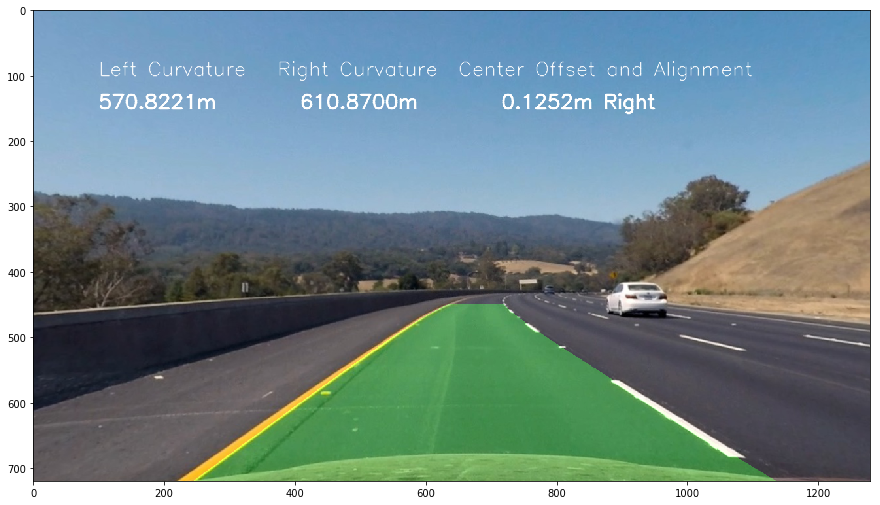

In [40]:
if __name__ == '__main__':
    img_path = "./test_images_undistort/test3_undistorted.jpg"
    img_actual = mpimg.imread(img_path)
    classifier = AdvancedLaneLineDetector()
    output = classifier.process_frame(img_actual)
    plt.figure(figsize=(15,10))
    plt.imshow(output)

In [41]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [42]:

project_video_path = "project_video.mp4"
challenge_video_path = "challenge_video.mp4"
project_video_output_path = 'output_videos/lanes_project_video.mp4'
project_video_sample_path = 'project_video_sample.mp4'
challenge_video_sample_path = 'challenge_video_sample.mp4'

project_video_sample_output_path = 'output_videos/lanes_project_video_sample.mp4'
challenge_video_sample_output_path = 'output_videos/lanes_challenge_video_sample.mp4'

In [43]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
#ffmpeg_extract_subclip(project_video_path, 5, 23, targetname=project_video_sample_path)

In [44]:
detector = AdvancedLaneLineDetector()

clip1 = VideoFileClip(project_video_path)
project_video_clip = clip1.fl_image(detector.process_frame) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output_path, audio=False)

Left Curvature   Right Curvature  Center Offset and Alignment
431.8644m        755.3867m        0.3446m Right    
431.864394205 755.386654554 0.344629017809
[MoviePy] >>>> Building video output_videos/lanes_project_video.mp4
[MoviePy] Writing video output_videos/lanes_project_video.mp4



  0%|          | 1/1261 [00:00<08:21,  2.51it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
443.2632m        749.1702m        0.3551m Right    
443.263219167 749.170244431 0.355131617014



  0%|          | 2/1261 [00:00<08:29,  2.47it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
426.6362m        687.0188m        0.3479m Right    
426.636196573 687.018785052 0.34790933641



  0%|          | 3/1261 [00:01<08:22,  2.50it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
424.8657m        608.4481m        0.3397m Right    
424.86570597 608.448109886 0.33972796238



  0%|          | 4/1261 [00:01<08:17,  2.53it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
415.4556m        555.7122m        0.3365m Right    
415.455595878 555.712155602 0.336507069246



  0%|          | 5/1261 [00:01<08:08,  2.57it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
435.4266m        451.1333m        0.3335m Right    
435.426607597 451.133334505 0.333465090125



  0%|          | 6/1261 [00:02<08:06,  2.58it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
460.2746m        429.5810m        0.3378m Right    
460.274609374 429.580962354 0.337848000059



  1%|          | 7/1261 [00:02<08:06,  2.58it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
480.2097m        429.9590m        0.3413m Right    
480.209652229 429.95898374 0.341273236043



  1%|          | 8/1261 [00:03<08:29,  2.46it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
466.7398m        503.8222m        0.3544m Right    
466.739798631 503.822234801 0.354362774242



  1%|          | 9/1261 [00:03<08:23,  2.48it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
517.0240m        517.3881m        0.3550m Right    
517.024014751 517.388100747 0.355030127945



  1%|          | 10/1261 [00:03<08:13,  2.53it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
525.2489m        646.1638m        0.3799m Right    
525.248942181 646.163757578 0.379947411534



  1%|          | 11/1261 [00:04<08:06,  2.57it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
562.9138m        892.4323m        0.4000m Right    
562.913762116 892.43231538 0.399988168259



  1%|          | 12/1261 [00:04<08:02,  2.59it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
680.8364m        747.5952m        0.3904m Right    
680.836431588 747.595230405 0.390449126877



  1%|          | 13/1261 [00:05<07:59,  2.60it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
656.7180m        979.8284m        0.3963m Right    
656.718034048 979.828369879 0.396322084987



  1%|          | 14/1261 [00:05<08:00,  2.59it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
637.9085m        738.4553m        0.3779m Right    
637.908451122 738.455257363 0.377891880898



  1%|          | 15/1261 [00:05<07:58,  2.61it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
591.0056m        626.5459m        0.3614m Right    
591.005589995 626.545935491 0.361406007881



  1%|▏         | 16/1261 [00:06<07:56,  2.61it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
565.3133m        416.3683m        0.3261m Right    
565.313341094 416.368306722 0.326101055423



  1%|▏         | 17/1261 [00:06<07:55,  2.62it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
540.6464m        369.5708m        0.3143m Right    
540.646411704 369.570796639 0.314338029135



  1%|▏         | 18/1261 [00:07<08:02,  2.58it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
579.0300m        405.2863m        0.3165m Right    
579.02998828 405.286272213 0.316535482396



  2%|▏         | 19/1261 [00:07<07:58,  2.60it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
551.1539m        391.1543m        0.3031m Right    
551.153870719 391.154286093 0.303076441364



  2%|▏         | 20/1261 [00:07<08:00,  2.58it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
553.9635m        398.2979m        0.2879m Right    
553.963469564 398.297946088 0.287879624267



  2%|▏         | 21/1261 [00:08<08:00,  2.58it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
615.5828m        370.1269m        0.2640m Right    
615.582806711 370.126872625 0.263963934373



  2%|▏         | 22/1261 [00:08<07:57,  2.60it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
667.7092m        369.8618m        0.2643m Right    
667.709201358 369.86179353 0.264348490103



  2%|▏         | 23/1261 [00:08<07:53,  2.62it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
733.6941m        397.1279m        0.2707m Right    
733.694085769 397.127876362 0.270702800048



  2%|▏         | 24/1261 [00:09<07:50,  2.63it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
592.6245m        516.2468m        0.2866m Right    
592.624451097 516.246761791 0.286569666538



  2%|▏         | 25/1261 [00:09<07:54,  2.60it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
554.5677m        676.1822m        0.3052m Right    
554.567709221 676.18224551 0.305155447377



  2%|▏         | 26/1261 [00:10<07:51,  2.62it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
586.7663m        658.2130m        0.3006m Right    
586.766348727 658.212960311 0.300567951008



  2%|▏         | 27/1261 [00:10<07:48,  2.63it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
542.0849m        693.3990m        0.2948m Right    
542.084949089 693.398955749 0.294784904105



  2%|▏         | 28/1261 [00:10<07:45,  2.65it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
537.6840m        657.3645m        0.2859m Right    
537.684001371 657.364504191 0.285857235534



  2%|▏         | 29/1261 [00:11<07:49,  2.63it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
498.5138m        561.5649m        0.2742m Right    
498.513776814 561.564886934 0.274191708738



  2%|▏         | 30/1261 [00:11<07:48,  2.63it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
445.2641m        548.3114m        0.2702m Right    
445.264141482 548.311395711 0.270224404503



  2%|▏         | 31/1261 [00:11<07:42,  2.66it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
443.8585m        362.6638m        0.2530m Right    
443.858537995 362.663804301 0.252957370302



  3%|▎         | 32/1261 [00:12<07:35,  2.70it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
411.7985m        327.7635m        0.2388m Right    
411.798463737 327.763524378 0.23882252815



  3%|▎         | 33/1261 [00:12<07:32,  2.71it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
379.9160m        313.4698m        0.2104m Right    
379.916042262 313.469823981 0.210445954286



  3%|▎         | 34/1261 [00:13<07:35,  2.70it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
371.0144m        365.9809m        0.2384m Right    
371.014401183 365.980868865 0.238352359558



  3%|▎         | 35/1261 [00:13<07:35,  2.69it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
364.9630m        421.7638m        0.2656m Right    
364.963001013 421.763763205 0.265612292716



  3%|▎         | 36/1261 [00:13<07:32,  2.71it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
360.3982m        445.5212m        0.2839m Right    
360.398208921 445.521177219 0.283851732528



  3%|▎         | 37/1261 [00:14<07:35,  2.69it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
358.7322m        404.4154m        0.2731m Right    
358.732235208 404.415421001 0.273119634013



  3%|▎         | 38/1261 [00:14<07:33,  2.69it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
346.4478m        353.1183m        0.2632m Right    
346.447849881 353.118342821 0.263210853378



  3%|▎         | 39/1261 [00:14<07:35,  2.68it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
344.6814m        308.1209m        0.2498m Right    
344.681429332 308.120853977 0.249783425968



  3%|▎         | 40/1261 [00:15<07:34,  2.69it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
354.0707m        294.9024m        0.2540m Right    
354.070690658 294.902389589 0.254022015235



  3%|▎         | 41/1261 [00:15<07:35,  2.68it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
368.8933m        297.1405m        0.2659m Right    
368.893328989 297.140531393 0.265882418415



  3%|▎         | 42/1261 [00:16<07:34,  2.68it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
376.0933m        314.5989m        0.2810m Right    
376.093334531 314.598920007 0.280973722991



  3%|▎         | 43/1261 [00:16<09:13,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
393.0785m        310.9379m        0.2887m Right    
393.078495578 310.937893287 0.288747037963



  3%|▎         | 44/1261 [00:17<09:04,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
419.2580m        318.2016m        0.2914m Right    
419.257987244 318.201637572 0.291425129884



  4%|▎         | 45/1261 [00:17<09:40,  2.09it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
444.0295m        311.6959m        0.2857m Right    
444.029503039 311.695894371 0.285670321653



  4%|▎         | 46/1261 [00:18<09:35,  2.11it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
461.3799m        312.3711m        0.2660m Right    
461.379880924 312.371137635 0.265952931391



  4%|▎         | 47/1261 [00:18<09:15,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
472.1605m        364.9288m        0.2874m Right    
472.160539178 364.92876962 0.287395296701



  4%|▍         | 48/1261 [00:19<09:17,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
480.6606m        431.1215m        0.3173m Right    
480.660599997 431.121540429 0.317349678956



  4%|▍         | 49/1261 [00:19<09:03,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
540.0982m        455.0028m        0.3302m Right    
540.09815704 455.002770637 0.330161563415



  4%|▍         | 50/1261 [00:19<09:11,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
528.8123m        474.7046m        0.3364m Right    
528.812301237 474.704631422 0.336440157218



  4%|▍         | 51/1261 [00:20<08:59,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
558.4943m        506.3286m        0.3379m Right    
558.494286118 506.328628172 0.337946735166



  4%|▍         | 52/1261 [00:20<09:05,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
561.7887m        484.5538m        0.3311m Right    
561.788681773 484.553814759 0.331055989203



  4%|▍         | 53/1261 [00:21<09:04,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
570.6574m        430.0367m        0.3178m Right    
570.65743506 430.036698775 0.317807902791



  4%|▍         | 54/1261 [00:21<09:07,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
575.1612m        374.0845m        0.3037m Right    
575.161153462 374.084466378 0.303673314228



  4%|▍         | 55/1261 [00:22<08:57,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
595.2561m        381.4196m        0.3039m Right    
595.25607225 381.419617691 0.303874151971



  4%|▍         | 56/1261 [00:22<09:05,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
634.5237m        388.3533m        0.2987m Right    
634.523670958 388.353262231 0.29871432332



  5%|▍         | 57/1261 [00:23<08:54,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
631.1165m        419.0401m        0.3025m Right    
631.116518907 419.04014179 0.302542014198



  5%|▍         | 58/1261 [00:23<09:01,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
605.8629m        430.9912m        0.2945m Right    
605.862949499 430.991243026 0.294508270802



  5%|▍         | 59/1261 [00:23<08:51,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
551.1225m        681.6831m        0.3289m Right    
551.122478476 681.683106458 0.328938191126



  5%|▍         | 60/1261 [00:24<09:00,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
528.1387m        613.1173m        0.3052m Right    
528.13870094 613.117320473 0.305245146486



  5%|▍         | 61/1261 [00:24<08:53,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
579.3139m        392.0509m        0.2579m Right    
579.313891559 392.050893297 0.257879635335



  5%|▍         | 62/1261 [00:25<08:57,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
547.2584m        313.8177m        0.2301m Right    
547.258420387 313.817714755 0.230078085994



  5%|▍         | 63/1261 [00:25<08:45,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
544.7749m        321.8519m        0.2208m Right    
544.77485285 321.851941025 0.220821988231



  5%|▌         | 64/1261 [00:26<08:58,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
538.2238m        326.4354m        0.2239m Right    
538.223775865 326.435360217 0.223915943433



  5%|▌         | 65/1261 [00:26<08:51,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
572.0942m        336.3507m        0.2230m Right    
572.09417432 336.350708134 0.223030863299



  5%|▌         | 66/1261 [00:27<08:52,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
555.4926m        382.8646m        0.2293m Right    
555.492615512 382.864596614 0.229279005702



  5%|▌         | 67/1261 [00:27<09:04,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
565.8746m        428.3384m        0.2310m Right    
565.874613019 428.338439466 0.231013519598



  5%|▌         | 68/1261 [00:27<09:02,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
566.4803m        437.4243m        0.2222m Right    
566.48030657 437.424259032 0.222225915602



  5%|▌         | 69/1261 [00:28<09:08,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
537.6901m        444.5348m        0.2164m Right    
537.690141431 444.534839189 0.216382436758



  6%|▌         | 70/1261 [00:28<08:57,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
578.2031m        464.9874m        0.2116m Right    
578.203087743 464.98735912 0.211558943046



  6%|▌         | 71/1261 [00:29<08:58,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
603.3580m        448.0770m        0.2046m Right    
603.357966104 448.077046594 0.204625429612



  6%|▌         | 72/1261 [00:29<08:55,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
604.1516m        478.4998m        0.2034m Right    
604.151573149 478.499785111 0.203413307169



  6%|▌         | 73/1261 [00:30<09:04,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
600.8812m        427.1011m        0.1858m Right    
600.881190105 427.101078979 0.185769485768



  6%|▌         | 74/1261 [00:30<08:58,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
604.4477m        428.9257m        0.1803m Right    
604.447683613 428.925663191 0.180294475466



  6%|▌         | 75/1261 [00:31<09:00,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
657.5985m        452.7823m        0.1826m Right    
657.598492592 452.782250622 0.182648032347



  6%|▌         | 76/1261 [00:31<08:45,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
661.5710m        405.0216m        0.1753m Right    
661.570999439 405.021635082 0.175285587563



  6%|▌         | 77/1261 [00:32<08:54,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
744.4236m        437.7776m        0.1773m Right    
744.423612277 437.777615224 0.17728164119



  6%|▌         | 78/1261 [00:32<08:43,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
755.3772m        458.7618m        0.1767m Right    
755.377216673 458.761837325 0.176725082631



  6%|▋         | 79/1261 [00:33<09:51,  2.00it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
755.2340m        439.3050m        0.1658m Right    
755.234013358 439.30502631 0.165830591187



  6%|▋         | 80/1261 [00:33<09:22,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
714.4760m        399.0809m        0.1474m Right    
714.476045784 399.080875629 0.147435230229



  6%|▋         | 81/1261 [00:33<09:16,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
694.1837m        364.5103m        0.1396m Right    
694.183725758 364.510258698 0.139563950606



  7%|▋         | 82/1261 [00:34<09:00,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
657.3573m        372.0554m        0.1258m Right    
657.357332567 372.055397117 0.125805575403



  7%|▋         | 83/1261 [00:34<08:57,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
634.8488m        402.2670m        0.1252m Right    
634.848774583 402.26702661 0.125246383699



  7%|▋         | 84/1261 [00:35<08:44,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
663.3262m        355.1654m        0.0936m Right    
663.326230555 355.165432336 0.0935865011691



  7%|▋         | 85/1261 [00:35<08:51,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
639.0337m        417.9462m        0.1182m Right    
639.033664177 417.946189069 0.118247992731



  7%|▋         | 86/1261 [00:36<08:37,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
574.2486m        500.4342m        0.1373m Right    
574.24859646 500.434220333 0.137279117056



  7%|▋         | 87/1261 [00:36<08:46,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
480.1997m        562.0433m        0.1419m Right    
480.199673497 562.043277184 0.141874570711



  7%|▋         | 88/1261 [00:37<08:36,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
450.2992m        498.9050m        0.1303m Right    
450.299237912 498.904991861 0.130257688559



  7%|▋         | 89/1261 [00:37<08:44,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
425.5857m        433.2515m        0.1175m Right    
425.585698106 433.251494447 0.117508796447



  7%|▋         | 90/1261 [00:37<08:36,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
400.3335m        335.8557m        0.1021m Right    
400.333451691 335.855720258 0.102067543683



  7%|▋         | 91/1261 [00:38<08:42,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
401.2938m        381.6429m        0.1132m Right    
401.293843941 381.64294183 0.113153409717



  7%|▋         | 92/1261 [00:38<08:52,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
412.3929m        362.7035m        0.1161m Right    
412.39290823 362.703461917 0.116050406007



  7%|▋         | 93/1261 [00:39<08:42,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
411.0610m        396.5595m        0.1279m Right    
411.060989387 396.55950739 0.127905660128



  7%|▋         | 94/1261 [00:39<08:40,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
388.5623m        424.0847m        0.1327m Right    
388.562267449 424.08472141 0.132692589378



  8%|▊         | 95/1261 [00:40<08:46,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
412.8532m        431.3293m        0.1302m Right    
412.853185176 431.329345945 0.130168530908



  8%|▊         | 96/1261 [00:40<08:33,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
405.3432m        429.1640m        0.1252m Right    
405.343224298 429.163987507 0.125172928124



  8%|▊         | 97/1261 [00:41<08:35,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
405.1809m        494.8397m        0.1447m Right    
405.180860367 494.839666339 0.144676157103



  8%|▊         | 98/1261 [00:41<09:16,  2.09it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
425.4447m        475.5759m        0.1397m Right    
425.444723413 475.57593154 0.139693686039



  8%|▊         | 99/1261 [00:42<08:58,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
416.4230m        442.3741m        0.1350m Right    
416.422966308 442.374121672 0.134972474152



  8%|▊         | 100/1261 [00:42<08:55,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
427.7550m        460.9216m        0.1403m Right    
427.7549954 460.92159062 0.140296212016



  8%|▊         | 101/1261 [00:42<08:43,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
414.8094m        432.8071m        0.1380m Right    
414.809397783 432.807080379 0.137963530867



  8%|▊         | 102/1261 [00:43<08:44,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
408.6421m        347.8488m        0.1191m Right    
408.642125389 347.848809657 0.119073064545



  8%|▊         | 103/1261 [00:43<08:54,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
401.9858m        331.2058m        0.1215m Right    
401.985792461 331.205818287 0.121503973484



  8%|▊         | 104/1261 [00:44<08:48,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
401.8792m        329.7677m        0.1280m Right    
401.879155676 329.76774979 0.127987017852



  8%|▊         | 105/1261 [00:44<08:51,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
419.5170m        343.5069m        0.1389m Right    
419.516996837 343.506897478 0.138910336179



  8%|▊         | 106/1261 [00:45<08:36,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
434.1805m        318.2454m        0.1409m Right    
434.180472085 318.245419591 0.140866459408



  8%|▊         | 107/1261 [00:45<08:40,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
436.3093m        324.3050m        0.1397m Right    
436.309301588 324.304991679 0.139733647526



  9%|▊         | 108/1261 [00:46<08:26,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
403.9651m        307.7243m        0.1344m Right    
403.965124896 307.724317734 0.134387492371



  9%|▊         | 109/1261 [00:46<08:33,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
405.2556m        324.5160m        0.1418m Right    
405.255572451 324.516026092 0.141787686931



  9%|▊         | 110/1261 [00:46<08:22,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
426.3376m        369.9172m        0.1767m Right    
426.337600351 369.917178662 0.176699004137



  9%|▉         | 111/1261 [00:47<08:30,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
401.8245m        448.4739m        0.2000m Right    
401.824490885 448.473920083 0.200049145582



  9%|▉         | 112/1261 [00:47<08:21,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
434.6578m        428.6310m        0.1981m Right    
434.657813779 428.630974089 0.198147202077



  9%|▉         | 113/1261 [00:48<08:31,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
400.9749m        401.1480m        0.2003m Right    
400.974862003 401.148016659 0.200330216603



  9%|▉         | 114/1261 [00:48<08:21,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
397.3358m        412.1760m        0.2085m Right    
397.335785653 412.176011521 0.208507166011



  9%|▉         | 115/1261 [00:49<08:28,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
378.1947m        341.6943m        0.1973m Right    
378.194720938 341.69427696 0.19731642089



  9%|▉         | 116/1261 [00:49<08:20,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
380.6981m        293.3943m        0.1876m Right    
380.69808555 293.394316227 0.187625847551



  9%|▉         | 117/1261 [00:50<08:27,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
383.7401m        287.9279m        0.1941m Right    
383.740075807 287.927865132 0.194084390492



  9%|▉         | 118/1261 [00:50<08:19,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
381.9414m        294.4022m        0.2025m Right    
381.941406588 294.402166771 0.202456409196



  9%|▉         | 119/1261 [00:50<08:23,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
390.4728m        317.7871m        0.2149m Right    
390.472842198 317.787080061 0.214862764161



 10%|▉         | 120/1261 [00:51<08:39,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
362.1778m        352.4000m        0.2347m Right    
362.177810529 352.399981119 0.23467952345



 10%|▉         | 121/1261 [00:51<08:34,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
376.2293m        397.0693m        0.2549m Right    
376.22934056 397.069295595 0.254885795173



 10%|▉         | 122/1261 [00:52<08:33,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
374.4209m        416.6132m        0.2715m Right    
374.420893886 416.613231944 0.271533536718



 10%|▉         | 123/1261 [00:52<08:34,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
368.5491m        381.9100m        0.2615m Right    
368.549144578 381.910007165 0.261459153342



 10%|▉         | 124/1261 [00:53<08:23,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
372.3318m        342.1964m        0.2500m Right    
372.331784052 342.196439794 0.249997928866



 10%|▉         | 125/1261 [00:53<08:27,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
369.4831m        297.7162m        0.2394m Right    
369.483054515 297.716232958 0.239383941991



 10%|▉         | 126/1261 [00:54<08:13,  2.30it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
393.8604m        367.7433m        0.2684m Right    
393.860383042 367.74334141 0.268409382832



 10%|█         | 127/1261 [00:54<08:21,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
393.1670m        327.5298m        0.2653m Right    
393.16700901 327.529765495 0.265307031435



 10%|█         | 128/1261 [00:54<08:12,  2.30it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
404.6690m        343.1083m        0.2744m Right    
404.668976178 343.108308172 0.274419303202



 10%|█         | 129/1261 [00:55<08:16,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
395.0004m        356.6373m        0.2888m Right    
395.000409698 356.637318499 0.288752009965



 10%|█         | 130/1261 [00:55<08:21,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
424.2711m        389.7229m        0.2917m Right    
424.271092455 389.722893811 0.291712464412



 10%|█         | 131/1261 [00:56<08:22,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
421.3016m        404.0148m        0.2989m Right    
421.301623716 404.01476207 0.298899604475



 10%|█         | 132/1261 [00:56<08:30,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
416.0136m        420.3352m        0.3052m Right    
416.013565026 420.335166157 0.305201421175



 11%|█         | 133/1261 [00:57<08:25,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
430.5871m        459.5794m        0.3174m Right    
430.587063128 459.579449043 0.3173568177



 11%|█         | 134/1261 [00:57<08:33,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
443.2484m        429.7824m        0.3192m Right    
443.248354378 429.782373175 0.319184131168



 11%|█         | 135/1261 [00:58<08:37,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
457.9144m        482.0677m        0.3359m Right    
457.914372717 482.067671444 0.335855473096



 11%|█         | 136/1261 [00:58<08:24,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
465.9887m        466.3742m        0.3305m Right    
465.98874048 466.374249835 0.330500548778



 11%|█         | 137/1261 [00:59<08:26,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
501.3382m        537.7558m        0.3415m Right    
501.33822377 537.755815914 0.341523439165



 11%|█         | 138/1261 [00:59<08:28,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
513.2528m        532.7629m        0.3353m Right    
513.252813228 532.762919748 0.33532173911



 11%|█         | 139/1261 [00:59<08:31,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
520.9321m        540.3509m        0.3331m Right    
520.932091561 540.350855911 0.333130289576



 11%|█         | 140/1261 [01:00<08:21,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
574.8959m        593.9099m        0.3355m Right    
574.895877983 593.909850379 0.33551592404



 11%|█         | 141/1261 [01:00<08:25,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
569.6290m        505.6542m        0.3233m Right    
569.629005727 505.654237495 0.323251013393



 11%|█▏        | 142/1261 [01:01<08:18,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
561.0926m        477.6359m        0.3137m Right    
561.092585844 477.63592831 0.313721933299



 11%|█▏        | 143/1261 [01:01<08:24,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
541.0939m        407.0306m        0.3036m Right    
541.093888947 407.030593595 0.303598575417



 11%|█▏        | 144/1261 [01:02<08:17,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
537.9512m        437.9368m        0.3001m Right    
537.951172569 437.936803906 0.30007006289



 11%|█▏        | 145/1261 [01:02<08:24,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
527.7980m        456.4144m        0.2992m Right    
527.797952785 456.414389749 0.299175978185



 12%|█▏        | 146/1261 [01:03<10:01,  1.85it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
504.3936m        526.2708m        0.3075m Right    
504.393550768 526.270836274 0.307471098736



 12%|█▏        | 147/1261 [01:03<09:39,  1.92it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
517.1751m        528.4106m        0.3056m Right    
517.175053999 528.410619508 0.305598194264



 12%|█▏        | 148/1261 [01:04<09:07,  2.03it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
458.9769m        449.7907m        0.2953m Right    
458.97694914 449.790701001 0.295323268353



 12%|█▏        | 149/1261 [01:04<09:00,  2.06it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
456.2335m        385.8071m        0.2752m Right    
456.233451915 385.807132239 0.27516082716



 12%|█▏        | 150/1261 [01:05<08:44,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
469.9296m        435.6539m        0.2859m Right    
469.929606333 435.653907657 0.285946279544



 12%|█▏        | 151/1261 [01:05<08:43,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
482.5313m        503.6830m        0.2964m Right    
482.531297105 503.682989182 0.296422286413



 12%|█▏        | 152/1261 [01:06<08:30,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
500.5647m        446.8338m        0.2809m Right    
500.564674512 446.833775305 0.280902301899



 12%|█▏        | 153/1261 [01:06<08:36,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
476.3508m        374.7584m        0.2653m Right    
476.350785689 374.758431452 0.265297007803



 12%|█▏        | 154/1261 [01:06<08:24,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
491.5706m        402.9227m        0.2706m Right    
491.57057685 402.92272469 0.270564438979



 12%|█▏        | 155/1261 [01:07<08:28,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
494.2351m        405.0734m        0.2724m Right    
494.235142341 405.073410905 0.272378431737



 12%|█▏        | 156/1261 [01:07<08:17,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
506.5686m        404.0067m        0.2700m Right    
506.568550572 404.006677658 0.269995902986



 12%|█▏        | 157/1261 [01:08<08:26,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
472.9044m        426.5390m        0.2654m Right    
472.90437348 426.538978096 0.265415511522



 13%|█▎        | 158/1261 [01:08<08:18,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
453.4322m        447.6456m        0.2639m Right    
453.432182014 447.645608818 0.263915608707



 13%|█▎        | 159/1261 [01:09<08:22,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
472.1246m        434.5345m        0.2547m Right    
472.124607676 434.534467305 0.254662855069



 13%|█▎        | 160/1261 [01:09<08:36,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
449.8858m        406.8439m        0.2425m Right    
449.885848057 406.843940551 0.242463504716



 13%|█▎        | 161/1261 [01:10<08:22,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
476.6810m        468.4213m        0.2593m Right    
476.680979246 468.421306471 0.259338652092



 13%|█▎        | 162/1261 [01:10<08:26,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
469.0385m        419.1120m        0.2427m Right    
469.038481089 419.11203156 0.242653562965



 13%|█▎        | 163/1261 [01:11<08:14,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
487.4033m        468.7997m        0.2516m Right    
487.403319072 468.79968264 0.251579868834



 13%|█▎        | 164/1261 [01:11<08:15,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
471.1893m        405.7530m        0.2377m Right    
471.189341051 405.753049567 0.237678369982



 13%|█▎        | 165/1261 [01:12<08:25,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
452.9066m        300.0774m        0.2108m Right    
452.906557006 300.077401509 0.210763760232



 13%|█▎        | 166/1261 [01:12<08:18,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
484.4373m        282.6671m        0.2073m Right    
484.437281923 282.667070149 0.20728551903



 13%|█▎        | 167/1261 [01:12<08:29,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
426.3055m        287.2386m        0.2128m Right    
426.305485355 287.238638786 0.21282559391



 13%|█▎        | 168/1261 [01:13<08:18,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
493.2893m        301.9267m        0.2222m Right    
493.28925545 301.92667751 0.22219833563



 13%|█▎        | 169/1261 [01:13<08:21,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
501.1120m        293.5250m        0.2141m Right    
501.112019813 293.524967358 0.214100779623



 13%|█▎        | 170/1261 [01:14<08:14,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
547.5495m        291.6439m        0.2003m Right    
547.549531251 291.643895351 0.200313759631



 14%|█▎        | 171/1261 [01:14<08:20,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
551.6256m        270.4557m        0.1626m Right    
551.625576591 270.455722583 0.162644697133



 14%|█▎        | 172/1261 [01:15<08:13,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
531.8900m        272.0946m        0.1593m Right    
531.889975116 272.094641601 0.15928382441



 14%|█▎        | 173/1261 [01:15<08:12,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
491.8862m        264.5277m        0.1571m Right    
491.886245308 264.527705231 0.157059582184



 14%|█▍        | 174/1261 [01:16<08:00,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
449.6949m        260.0659m        0.1620m Right    
449.694880755 260.065880587 0.162044077512



 14%|█▍        | 175/1261 [01:16<08:08,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
436.6327m        224.2684m        0.1392m Right    
436.632673719 224.268440677 0.139246995571



 14%|█▍        | 176/1261 [01:16<07:58,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
425.0734m        221.5530m        0.1402m Right    
425.073448518 221.552979058 0.140204261187



 14%|█▍        | 177/1261 [01:17<08:06,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
444.8867m        244.9830m        0.1564m Right    
444.886721481 244.983028003 0.156398803736



 14%|█▍        | 178/1261 [01:17<07:58,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
435.5683m        247.2896m        0.1634m Right    
435.568277815 247.289605987 0.163360297645



 14%|█▍        | 179/1261 [01:18<08:04,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
445.1911m        255.2304m        0.1775m Right    
445.191076506 255.230357663 0.177458237239



 14%|█▍        | 180/1261 [01:18<08:27,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
452.2248m        270.1344m        0.1896m Right    
452.224842465 270.134409128 0.189550530588



 14%|█▍        | 181/1261 [01:19<08:18,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
394.4862m        297.1579m        0.1997m Right    
394.486150231 297.157883612 0.199741216439



 14%|█▍        | 182/1261 [01:19<08:16,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
401.4458m        312.0527m        0.2035m Right    
401.445774774 312.052727991 0.203535779019



 15%|█▍        | 183/1261 [01:20<08:03,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
365.9653m        335.5475m        0.2213m Right    
365.965294702 335.547486244 0.221324048146



 15%|█▍        | 184/1261 [01:20<08:11,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
340.8491m        346.4970m        0.2319m Right    
340.849075282 346.497041657 0.231880205515



 15%|█▍        | 185/1261 [01:21<08:18,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
322.9458m        301.5929m        0.2045m Right    
322.945801733 301.592909099 0.204474140992



 15%|█▍        | 186/1261 [01:21<08:14,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
289.7956m        261.1273m        0.1899m Right    
289.795592129 261.127257294 0.189897091866



 15%|█▍        | 187/1261 [01:21<08:01,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
295.2121m        260.9656m        0.1890m Right    
295.212112761 260.965588275 0.189013615694



 15%|█▍        | 188/1261 [01:22<08:08,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
289.8401m        264.4493m        0.1996m Right    
289.840140069 264.449250701 0.199623385841



 15%|█▍        | 189/1261 [01:22<07:56,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
296.0451m        293.3545m        0.2178m Right    
296.045100589 293.354456916 0.217758416263



 15%|█▌        | 190/1261 [01:23<08:07,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
297.7817m        279.8073m        0.2183m Right    
297.781695884 279.807273134 0.21834502458



 15%|█▌        | 191/1261 [01:23<07:59,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
293.5960m        271.4111m        0.2206m Right    
293.595969498 271.41111394 0.220594595532



 15%|█▌        | 192/1261 [01:24<08:00,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
313.5149m        297.9453m        0.2380m Right    
313.51492491 297.94534678 0.2379601246



 15%|█▌        | 193/1261 [01:24<08:08,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
310.6198m        265.1036m        0.2370m Right    
310.619820428 265.103585535 0.237035536064



 15%|█▌        | 194/1261 [01:25<08:05,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
329.1778m        272.4280m        0.2395m Right    
329.17778085 272.428006289 0.239480224882



 15%|█▌        | 195/1261 [01:25<08:05,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
341.2252m        266.4807m        0.2331m Right    
341.225162546 266.480722002 0.23309992748



 16%|█▌        | 196/1261 [01:26<07:52,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
407.1833m        297.5545m        0.2349m Right    
407.183264923 297.554482597 0.234929253204



 16%|█▌        | 197/1261 [01:26<08:00,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
457.5398m        374.0096m        0.2587m Right    
457.539800211 374.009596207 0.25868589256



 16%|█▌        | 198/1261 [01:26<07:50,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
523.5360m        402.7736m        0.2573m Right    
523.536014032 402.773607204 0.257322037866



 16%|█▌        | 199/1261 [01:27<07:57,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
581.4674m        397.7030m        0.2485m Right    
581.467372987 397.703025154 0.248499081693



 16%|█▌        | 200/1261 [01:27<07:47,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
577.0419m        476.4052m        0.2673m Right    
577.04193498 476.40524758 0.267324488754



 16%|█▌        | 201/1261 [01:28<08:01,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
608.4368m        558.4262m        0.2743m Right    
608.436758011 558.426164668 0.274276104619



 16%|█▌        | 202/1261 [01:28<07:57,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
554.6349m        508.8406m        0.2569m Right    
554.63486291 508.840646105 0.256904872315



 16%|█▌        | 203/1261 [01:29<08:03,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
516.7157m        468.4897m        0.2427m Right    
516.715665911 468.489692466 0.242681478919



 16%|█▌        | 204/1261 [01:29<07:47,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
520.7258m        434.6506m        0.2348m Right    
520.725794365 434.650598239 0.234842588136



 16%|█▋        | 205/1261 [01:30<07:52,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
477.4989m        359.4777m        0.2192m Right    
477.498875873 359.477746454 0.219171860807



 16%|█▋        | 206/1261 [01:30<07:42,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
450.4694m        352.8876m        0.2167m Right    
450.46936609 352.887629074 0.216671996496



 16%|█▋        | 207/1261 [01:30<07:51,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
408.0789m        448.6643m        0.2456m Right    
408.078936706 448.664341143 0.245648271958



 16%|█▋        | 208/1261 [01:31<07:46,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
382.3845m        464.9856m        0.2547m Right    
382.384504338 464.985607315 0.254650012323



 17%|█▋        | 209/1261 [01:31<07:52,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
398.2939m        473.6472m        0.2541m Right    
398.293909169 473.647207027 0.254117935802



 17%|█▋        | 210/1261 [01:32<07:47,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
415.4132m        554.2600m        0.2611m Right    
415.413172794 554.259961938 0.261100785089



 17%|█▋        | 211/1261 [01:32<07:50,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
451.1166m        578.5387m        0.2615m Right    
451.116582413 578.538725716 0.261472281707



 17%|█▋        | 212/1261 [01:33<09:24,  1.86it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
437.6617m        529.7631m        0.2502m Right    
437.661668465 529.763131471 0.250213048042



 17%|█▋        | 213/1261 [01:33<09:03,  1.93it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
443.3414m        562.1977m        0.2511m Right    
443.341383522 562.197719199 0.251059636129



 17%|█▋        | 214/1261 [01:34<08:30,  2.05it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
429.1294m        597.8655m        0.2493m Right    
429.129378813 597.865480298 0.249287680886



 17%|█▋        | 215/1261 [01:34<08:17,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
421.1347m        464.5909m        0.2218m Right    
421.134711473 464.590860716 0.221800518132



 17%|█▋        | 216/1261 [01:35<07:57,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
437.4153m        434.6868m        0.2106m Right    
437.415338842 434.686832729 0.210606135528



 17%|█▋        | 217/1261 [01:35<07:56,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
446.9636m        398.3441m        0.2028m Right    
446.963577208 398.344081533 0.20283029971



 17%|█▋        | 218/1261 [01:36<07:39,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
459.5397m        399.6732m        0.1937m Right    
459.539699723 399.673176806 0.193721123015



 17%|█▋        | 219/1261 [01:36<07:44,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
465.0008m        455.8905m        0.2024m Right    
465.000755399 455.890504975 0.202390201085



 17%|█▋        | 220/1261 [01:36<07:33,  2.30it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
518.2051m        414.5744m        0.1811m Right    
518.205065128 414.574406844 0.181149888262



 18%|█▊        | 221/1261 [01:37<07:36,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
511.4031m        482.4205m        0.1943m Right    
511.403083494 482.420459064 0.194327756215



 18%|█▊        | 222/1261 [01:37<07:27,  2.32it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
566.5166m        530.1809m        0.2059m Right    
566.51655881 530.180887972 0.205893214834



 18%|█▊        | 223/1261 [01:38<07:37,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
566.9360m        520.6550m        0.2017m Right    
566.936041149 520.655001294 0.201707091686



 18%|█▊        | 224/1261 [01:38<08:09,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
546.4109m        459.7419m        0.1933m Right    
546.410909346 459.741945855 0.193255539646



 18%|█▊        | 225/1261 [01:39<08:01,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
563.5031m        470.5583m        0.1893m Right    
563.503128414 470.558301685 0.18931894768



 18%|█▊        | 226/1261 [01:39<08:00,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
564.3488m        361.4772m        0.1611m Right    
564.348816008 361.477185742 0.161053183643



 18%|█▊        | 227/1261 [01:40<07:45,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
604.2921m        328.5229m        0.1515m Right    
604.292084225 328.52289696 0.151476678159



 18%|█▊        | 228/1261 [01:40<07:49,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
642.8862m        334.1968m        0.1497m Right    
642.88624285 334.196783654 0.149662710923



 18%|█▊        | 229/1261 [01:41<07:35,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
600.2173m        345.7954m        0.1432m Right    
600.217335949 345.795394619 0.143210277783



 18%|█▊        | 230/1261 [01:41<07:44,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
657.7655m        333.0726m        0.1294m Right    
657.765477868 333.072584322 0.129410027918



 18%|█▊        | 231/1261 [01:41<07:32,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
675.5601m        338.7512m        0.1257m Right    
675.560050114 338.75115942 0.125738261579



 18%|█▊        | 232/1261 [01:42<07:34,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
719.8700m        324.6949m        0.0992m Right    
719.869951128 324.694940759 0.0992109363348



 18%|█▊        | 233/1261 [01:42<07:28,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
737.5062m        335.4920m        0.0880m Right    
737.506163305 335.492003525 0.0879699446877



 19%|█▊        | 234/1261 [01:43<07:36,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
683.1236m        370.9996m        0.0984m Right    
683.123569271 370.999574989 0.0983920823685



 19%|█▊        | 235/1261 [01:43<07:26,  2.30it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
662.5841m        363.1055m        0.0915m Right    
662.584124506 363.105493127 0.0915045447923



 19%|█▊        | 236/1261 [01:44<07:34,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
619.5446m        318.5603m        0.0815m Right    
619.544597508 318.56027722 0.0815041640217



 19%|█▉        | 237/1261 [01:44<07:29,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
571.6998m        287.6056m        0.0603m Right    
571.699750112 287.605571715 0.0602716662114



 19%|█▉        | 238/1261 [01:45<07:33,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
527.3741m        258.7854m        0.0472m Right    
527.374147371 258.785415196 0.0471829261576



 19%|█▉        | 239/1261 [01:45<07:45,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
506.9566m        278.7041m        0.0575m Right    
506.956557639 278.704056318 0.0575095431413



 19%|█▉        | 240/1261 [01:45<07:35,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
504.5210m        295.9882m        0.0664m Right    
504.521004575 295.98821659 0.066366380643



 19%|█▉        | 241/1261 [01:46<07:39,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
502.0627m        320.7030m        0.0685m Right    
502.062666108 320.703003075 0.0685217799905



 19%|█▉        | 242/1261 [01:46<07:28,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
525.9168m        327.8772m        0.0657m Right    
525.916825195 327.877218453 0.0657042047043



 19%|█▉        | 243/1261 [01:47<07:35,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
479.5899m        333.1160m        0.0660m Right    
479.589860027 333.116016496 0.0660349404633



 19%|█▉        | 244/1261 [01:47<07:19,  2.32it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
494.5031m        362.5878m        0.0696m Right    
494.503108995 362.58775344 0.0695804226639



 19%|█▉        | 245/1261 [01:48<07:24,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
469.5209m        301.5155m        0.0384m Right    
469.520855072 301.515467775 0.0383871131667



 20%|█▉        | 246/1261 [01:48<07:17,  2.32it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
453.1076m        253.8213m        0.0001m Right    
453.107606934 253.821289653 0.000100273973191



 20%|█▉        | 247/1261 [01:49<07:26,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
471.1819m        269.9758m        0.0061m Right    
471.18193031 269.975785136 0.00606036231477



 20%|█▉        | 248/1261 [01:49<07:19,  2.30it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
442.2546m        254.9873m        0.0069m Right    
442.254597947 254.987309429 0.00692690243338



 20%|█▉        | 249/1261 [01:49<07:28,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
478.0081m        276.2246m        0.0160m Right    
478.008060124 276.224582264 0.0160177108669



 20%|█▉        | 250/1261 [01:50<07:18,  2.31it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
472.8664m        285.5152m        0.0210m Right    
472.866404304 285.515209565 0.0209904536047



 20%|█▉        | 251/1261 [01:50<07:22,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
509.8454m        307.6428m        0.0331m Right    
509.845368624 307.642844192 0.0330531649945



 20%|█▉        | 252/1261 [01:51<07:17,  2.31it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
525.5439m        312.6493m        0.0339m Right    
525.543883213 312.64933267 0.0339064229333



 20%|██        | 253/1261 [01:51<07:28,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
531.2648m        333.6262m        0.0396m Right    
531.264797736 333.626214696 0.0395549905686



 20%|██        | 254/1261 [01:52<07:52,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
565.2866m        357.6656m        0.0453m Right    
565.286602739 357.665563383 0.0452874725651



 20%|██        | 255/1261 [01:52<07:34,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
531.6190m        352.9903m        0.0448m Right    
531.618974432 352.990262409 0.0447777135137



 20%|██        | 256/1261 [01:53<07:37,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
535.7775m        359.2453m        0.0369m Right    
535.777533347 359.245290843 0.0369118789862



 20%|██        | 257/1261 [01:53<07:29,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
521.1003m        330.7326m        0.0210m Right    
521.100254205 330.73256239 0.0209943674372



 20%|██        | 258/1261 [01:53<07:33,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
489.5794m        301.6215m        0.0035m Right    
489.579388449 301.621475136 0.00345930303847



 21%|██        | 259/1261 [01:54<07:23,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
500.0295m        289.6494m        0.0003m Right    
500.029477863 289.649443076 0.000316763255747



 21%|██        | 260/1261 [01:54<07:28,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
482.5320m        272.8010m        0.0019m Right    
482.53201512 272.801024249 0.00187025450614



 21%|██        | 261/1261 [01:55<07:17,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
512.9005m        316.3474m        0.0215m Right    
512.900521587 316.347408276 0.0215038102883



 21%|██        | 262/1261 [01:55<07:25,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
508.1360m        309.7548m        0.0275m Right    
508.135969408 309.754822498 0.0274742066835



 21%|██        | 263/1261 [01:56<07:21,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
514.9672m        326.4382m        0.0404m Right    
514.967223494 326.438205657 0.0403727808658



 21%|██        | 264/1261 [01:56<07:28,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
517.6797m        341.9972m        0.0480m Right    
517.679733933 341.997196928 0.0479532459092



 21%|██        | 265/1261 [01:57<07:22,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
536.1765m        357.2942m        0.0563m Right    
536.176539454 357.294158534 0.0562896012057



 21%|██        | 266/1261 [01:57<07:28,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
551.6510m        393.7851m        0.0627m Right    
551.650973452 393.785088704 0.0627046477582



 21%|██        | 267/1261 [01:57<07:19,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
530.3266m        427.6603m        0.0725m Right    
530.326641676 427.660272328 0.0725497161639



 21%|██▏       | 268/1261 [01:58<07:25,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
541.9814m        466.9792m        0.0789m Right    
541.981360981 466.97917342 0.0788698212613



 21%|██▏       | 269/1261 [01:58<07:15,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
555.0170m        472.7814m        0.0790m Right    
555.017033918 472.78135779 0.0790466458182



 21%|██▏       | 270/1261 [01:59<07:24,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
551.6499m        549.6824m        0.0918m Right    
551.649911793 549.682439217 0.0918197175278



 21%|██▏       | 271/1261 [01:59<07:18,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
531.1921m        582.1079m        0.0953m Right    
531.192099362 582.107901676 0.0953246508849



 22%|██▏       | 272/1261 [02:00<07:22,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
515.4345m        486.2947m        0.0862m Right    
515.434496606 486.294651346 0.086168367882



 22%|██▏       | 273/1261 [02:00<07:13,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
542.9220m        400.7032m        0.0731m Right    
542.922005894 400.703235 0.0730502691695



 22%|██▏       | 274/1261 [02:01<07:22,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
550.8901m        418.6837m        0.0872m Right    
550.890073252 418.683744634 0.0871731161767



 22%|██▏       | 275/1261 [02:01<07:22,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
568.5553m        446.8245m        0.0948m Right    
568.555309488 446.824511547 0.0947634284626



 22%|██▏       | 276/1261 [02:01<07:27,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
618.1003m        458.0423m        0.1013m Right    
618.100252502 458.042297072 0.101321850141



 22%|██▏       | 277/1261 [02:02<07:15,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
635.6158m        471.7813m        0.1070m Right    
635.615770131 471.781302793 0.106984815196



 22%|██▏       | 278/1261 [02:02<07:32,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
659.9258m        498.3780m        0.1097m Right    
659.925755064 498.378030201 0.10967194916



 22%|██▏       | 279/1261 [02:03<08:58,  1.82it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
664.6543m        540.0447m        0.1175m Right    
664.654261807 540.044716813 0.117461599254



 22%|██▏       | 280/1261 [02:04<08:50,  1.85it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
699.8045m        557.1333m        0.1197m Right    
699.804471492 557.13331972 0.119741270618



 22%|██▏       | 281/1261 [02:04<08:12,  1.99it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
740.8563m        548.8410m        0.1233m Right    
740.856258345 548.84101724 0.123290428558



 22%|██▏       | 282/1261 [02:05<08:05,  2.02it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
676.0270m        507.4531m        0.1202m Right    
676.027003897 507.45305824 0.120223009158



 22%|██▏       | 283/1261 [02:05<07:45,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
731.3882m        580.3807m        0.1343m Right    
731.388167736 580.380688321 0.134263217718



 23%|██▎       | 284/1261 [02:05<07:42,  2.11it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
734.5296m        512.3387m        0.1343m Right    
734.5296237 512.338697983 0.134273390291



 23%|██▎       | 285/1261 [02:06<07:28,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
777.8636m        574.6137m        0.1437m Right    
777.863581848 574.613652363 0.143673765276



 23%|██▎       | 286/1261 [02:06<07:28,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
824.1742m        564.2652m        0.1499m Right    
824.174187139 564.265201148 0.149866962825



 23%|██▎       | 287/1261 [02:07<07:15,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
864.5001m        526.4085m        0.1504m Right    
864.500116524 526.408453424 0.150387591052



 23%|██▎       | 288/1261 [02:07<07:18,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
909.0003m        555.2166m        0.1585m Right    
909.000308886 555.216617583 0.158538360729



 23%|██▎       | 289/1261 [02:08<07:10,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
907.7604m        509.2087m        0.1630m Right    
907.760411368 509.208685471 0.163011647262



 23%|██▎       | 290/1261 [02:08<07:13,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
917.5973m        547.4425m        0.1685m Right    
917.597347179 547.442526135 0.168519785428



 23%|██▎       | 291/1261 [02:09<07:05,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
946.9832m        647.7656m        0.1826m Right    
946.9832405 647.76562775 0.182616121709



 23%|██▎       | 292/1261 [02:09<07:04,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
860.8239m        698.7564m        0.1882m Right    
860.823903234 698.75638676 0.188216382523



 23%|██▎       | 293/1261 [02:09<06:59,  2.31it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
955.7093m        744.8419m        0.1980m Right    
955.709320623 744.841869346 0.198034132685



 23%|██▎       | 294/1261 [02:10<07:00,  2.30it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
911.0230m        654.8803m        0.1900m Right    
911.023010495 654.88027637 0.189960084033



 23%|██▎       | 295/1261 [02:10<06:50,  2.35it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
943.3482m        791.5363m        0.2056m Right    
943.34820547 791.53629919 0.205553471981



 23%|██▎       | 296/1261 [02:11<07:00,  2.30it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
988.6680m        694.0803m        0.2038m Right    
988.667996449 694.080259623 0.203773375555



 24%|██▎       | 297/1261 [02:11<06:54,  2.33it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
933.9841m        792.3255m        0.2030m Right    
933.984098482 792.32548554 0.203025446366



 24%|██▎       | 298/1261 [02:12<07:07,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1208.4182m       709.1470m        0.2036m Right    
1208.41815262 709.146954428 0.203582639047



 24%|██▎       | 299/1261 [02:12<06:58,  2.30it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1275.4171m       787.2999m        0.2071m Right    
1275.41705894 787.299901454 0.207121930357



 24%|██▍       | 300/1261 [02:12<07:12,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1209.7728m       823.5967m        0.2061m Right    
1209.77278815 823.596739507 0.206086965981



 24%|██▍       | 301/1261 [02:13<07:04,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1385.8986m       899.0752m        0.2095m Right    
1385.89859905 899.075157299 0.209510832636



 24%|██▍       | 302/1261 [02:13<07:11,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1529.8593m       886.4039m        0.2107m Right    
1529.85930123 886.403885998 0.210658897197



 24%|██▍       | 303/1261 [02:14<07:02,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1839.2504m       1030.9435m       0.2172m Right    
1839.25041343 1030.94353148 0.217205574714



 24%|██▍       | 304/1261 [02:14<07:10,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2019.8661m       1496.1221m       0.2265m Right    
2019.86612735 1496.12207731 0.226452242849



 24%|██▍       | 305/1261 [02:15<07:05,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1848.3482m       3291.4258m       0.2532m Right    
1848.34816743 3291.42575524 0.25321442617



 24%|██▍       | 306/1261 [02:15<07:14,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2166.2041m       5657.1115m       0.2499m Right    
2166.2041471 5657.11152202 0.249850567851



 24%|██▍       | 307/1261 [02:16<07:07,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2578.1162m       9350.3257m       0.2567m Right    
2578.11620688 9350.32572457 0.256736742835



 24%|██▍       | 308/1261 [02:16<07:12,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2323.7399m       4274.7003m       0.2453m Right    
2323.73993064 4274.70033446 0.245321450131



 25%|██▍       | 309/1261 [02:16<07:04,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3453.4619m       1998.1373m       0.2342m Right    
3453.46185136 1998.13725131 0.23421345369



 25%|██▍       | 310/1261 [02:17<07:08,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4199.8155m       1201.2304m       0.2239m Right    
4199.81550752 1201.23037764 0.223851252922



 25%|██▍       | 311/1261 [02:17<06:58,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5278.7129m       1711.5853m       0.2333m Right    
5278.71289412 1711.58527669 0.23331524378



 25%|██▍       | 312/1261 [02:18<07:09,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5507.4501m       1802.7227m       0.2296m Right    
5507.45010246 1802.7226691 0.229601234185



 25%|██▍       | 313/1261 [02:18<07:00,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
13051.8398m      1402.5946m       0.2226m Right    
13051.839809 1402.59456375 0.222621226995



 25%|██▍       | 314/1261 [02:19<07:03,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
63119.1901m      1510.3565m       0.2261m Right    
63119.1901495 1510.35653601 0.226068394952



 25%|██▍       | 315/1261 [02:19<07:40,  2.05it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
24576.1933m      1521.6625m       0.2231m Right    
24576.1933 1521.66251698 0.223100116623



 25%|██▌       | 316/1261 [02:20<07:20,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
230630.5775m     1734.0336m       0.2240m Right    
230630.577545 1734.0335501 0.223958739788



 25%|██▌       | 317/1261 [02:20<07:23,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
122235.2936m     1206.4583m       0.2049m Right    
122235.293556 1206.45832634 0.204892119672



 25%|██▌       | 318/1261 [02:21<07:09,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
213189.4503m     978.9360m        0.1965m Right    
213189.450293 978.936007866 0.196498744016



 25%|██▌       | 319/1261 [02:21<07:09,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
10804.8771m      752.5969m        0.1806m Right    
10804.8771454 752.59689586 0.180642054689



 25%|██▌       | 320/1261 [02:22<06:59,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
12009.6089m      1042.6556m       0.2041m Right    
12009.608898 1042.65563537 0.204121792074



 25%|██▌       | 321/1261 [02:22<07:01,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
8765.0968m       1044.5671m       0.2091m Right    
8765.09676603 1044.56710486 0.209124350127



 26%|██▌       | 322/1261 [02:22<06:52,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
6823.4990m       1043.7193m       0.2128m Right    
6823.49895876 1043.71930023 0.212825517498



 26%|██▌       | 323/1261 [02:23<06:59,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5167.3374m       1276.9178m       0.2200m Right    
5167.33738888 1276.917761 0.219972295539



 26%|██▌       | 324/1261 [02:23<06:49,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5290.2546m       1169.4767m       0.2186m Right    
5290.25459549 1169.47668714 0.218637035303



 26%|██▌       | 325/1261 [02:24<06:57,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4143.0450m       1489.7094m       0.2248m Right    
4143.04502678 1489.70940446 0.224819661469



 26%|██▌       | 326/1261 [02:24<06:48,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
6256.5410m       2033.7228m       0.2265m Right    
6256.54102921 2033.72279141 0.22652181577



 26%|██▌       | 327/1261 [02:25<07:00,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
6272.6756m       2050.3851m       0.2281m Right    
6272.67557869 2050.38507749 0.22811221221



 26%|██▌       | 328/1261 [02:25<06:50,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
6929.4453m       4102.7436m       0.2360m Right    
6929.44533552 4102.7436351 0.236005386002



 26%|██▌       | 329/1261 [02:26<06:56,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5112.5633m       5243.6456m       0.2557m Right    
5112.56331255 5243.64556427 0.255668992455



 26%|██▌       | 330/1261 [02:26<06:49,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5237.2932m       10935.4185m      0.2680m Right    
5237.29318045 10935.4185065 0.268047700774



 26%|██▌       | 331/1261 [02:26<06:55,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
7717.2204m       6901.2098m       0.2458m Right    
7717.22040009 6901.20983054 0.245771578953



 26%|██▋       | 332/1261 [02:27<06:50,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
6389.1714m       1742.2475m       0.2227m Right    
6389.17140562 1742.24747686 0.222698685891



 26%|██▋       | 333/1261 [02:27<06:57,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
14277.0232m      2832.9957m       0.2223m Right    
14277.0232051 2832.99572097 0.222348946991



 26%|██▋       | 334/1261 [02:28<06:49,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
9264.7612m       2461.3111m       0.2220m Right    
9264.76124771 2461.31112457 0.221973828103



 27%|██▋       | 335/1261 [02:28<06:55,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
8143.3459m       3529.8226m       0.2313m Right    
8143.34593374 3529.82261279 0.231296006273



 27%|██▋       | 336/1261 [02:29<06:48,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
6604.2694m       1922.4561m       0.2276m Right    
6604.26939664 1922.45605937 0.227627320245



 27%|██▋       | 337/1261 [02:29<06:53,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
7809.6887m       2203.5657m       0.2290m Right    
7809.68871673 2203.56572629 0.229010035611



 27%|██▋       | 338/1261 [02:29<06:46,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4871.8677m       3722.7515m       0.2400m Right    
4871.86773234 3722.7514927 0.240001623853



 27%|██▋       | 339/1261 [02:30<06:57,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
9887.5245m       5696.4616m       0.2374m Right    
9887.52445559 5696.46156336 0.237420628425



 27%|██▋       | 340/1261 [02:30<06:48,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
7062.9043m       253535.5288m     0.2456m Right    
7062.90430311 253535.528792 0.245573725041



 27%|██▋       | 341/1261 [02:31<06:53,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
31163.9490m      4023.1566m       0.2357m Right    
31163.9490481 4023.15660111 0.235693492783



 27%|██▋       | 342/1261 [02:31<06:45,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
307193.1752m     1181.0015m       0.2017m Right    
307193.175157 1181.00153478 0.201733735046



 27%|██▋       | 343/1261 [02:32<06:54,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
17545.2577m      1765.6848m       0.2112m Right    
17545.2577022 1765.68479683 0.211176508096



 27%|██▋       | 344/1261 [02:32<06:48,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
7480.8274m       1988.1746m       0.2131m Right    
7480.82744799 1988.17457323 0.213057537814



 27%|██▋       | 345/1261 [02:33<08:17,  1.84it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
7008.4427m       1499.4290m       0.2084m Right    
7008.44272915 1499.42898551 0.208404205405



 27%|██▋       | 346/1261 [02:34<08:51,  1.72it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
8001.2388m       1819.7972m       0.2119m Right    
8001.23882283 1819.79723939 0.211944820971



 28%|██▊       | 347/1261 [02:34<08:18,  1.83it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5633.5983m       1505.6756m       0.2108m Right    
5633.59826567 1505.67558655 0.210838206367



 28%|██▊       | 348/1261 [02:35<07:44,  1.96it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
8409.8417m       1457.7740m       0.2147m Right    
8409.84165881 1457.77402347 0.214665354582



 28%|██▊       | 349/1261 [02:35<07:32,  2.02it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
6145.5000m       2069.1344m       0.2214m Right    
6145.50001316 2069.13435986 0.221367594988



 28%|██▊       | 350/1261 [02:35<07:10,  2.11it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
6703.3889m       1802.7487m       0.2214m Right    
6703.38892773 1802.7487464 0.221404792256



 28%|██▊       | 351/1261 [02:36<07:07,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
9082.9669m       2362.4917m       0.2256m Right    
9082.96688108 2362.49167692 0.225648703092



 28%|██▊       | 352/1261 [02:36<06:52,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
7436.1837m       3162.5626m       0.2252m Right    
7436.18369205 3162.56255755 0.225180145309



 28%|██▊       | 353/1261 [02:37<06:54,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5918.7754m       4177.9175m       0.2297m Right    
5918.77540311 4177.91748266 0.229708509041



 28%|██▊       | 354/1261 [02:37<06:44,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
89255.9362m      4271.1543m       0.2327m Right    
89255.9362408 4271.15433726 0.232727166248



 28%|██▊       | 355/1261 [02:38<06:48,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
27900.3433m      4029.0585m       0.2320m Right    
27900.3433489 4029.05850041 0.232001729424



 28%|██▊       | 356/1261 [02:38<06:41,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
11946.2404m      2886.2666m       0.2313m Right    
11946.2404498 2886.26664245 0.231321784759



 28%|██▊       | 357/1261 [02:39<06:45,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2856.8020m       1981.8442m       0.2342m Right    
2856.80203093 1981.84416454 0.234214898759



 28%|██▊       | 358/1261 [02:39<06:35,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2737.5455m       1577.7158m       0.2322m Right    
2737.54550174 1577.71581643 0.23219693996



 28%|██▊       | 359/1261 [02:39<06:43,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1492.4843m       1644.5302m       0.2482m Right    
1492.48429766 1644.53019225 0.248204408501



 29%|██▊       | 360/1261 [02:40<06:40,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1361.9649m       1639.5686m       0.2525m Right    
1361.96494527 1639.56859651 0.252494459412



 29%|██▊       | 361/1261 [02:40<06:47,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1194.2212m       1844.9289m       0.2590m Right    
1194.2211744 1844.92891154 0.258951729636



 29%|██▊       | 362/1261 [02:41<06:41,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1125.3713m       2857.1269m       0.2632m Right    
1125.37128834 2857.12694378 0.263157921568



 29%|██▉       | 363/1261 [02:41<06:49,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1073.1949m       6023.2912m       0.2727m Right    
1073.19492531 6023.2912375 0.27266621259



 29%|██▉       | 364/1261 [02:42<06:42,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1061.6328m       3848.2096m       0.2675m Right    
1061.63282152 3848.20962248 0.267484231625



 29%|██▉       | 365/1261 [02:42<06:48,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1169.9053m       18809.0175m      0.2874m Right    
1169.90533471 18809.0174836 0.287412705356



 29%|██▉       | 366/1261 [02:43<06:41,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1208.1394m       16367.0267m      0.2760m Right    
1208.13941116 16367.026732 0.276048202499



 29%|██▉       | 367/1261 [02:43<06:50,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1211.6136m       11653.8997m      0.2699m Right    
1211.61357322 11653.8996688 0.269912456707



 29%|██▉       | 368/1261 [02:43<06:48,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1239.2527m       11416.7596m      0.2636m Right    
1239.25268718 11416.759557 0.263626062904



 29%|██▉       | 369/1261 [02:44<06:54,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1507.7490m       2003.0185m       0.2341m Right    
1507.74897221 2003.01845753 0.234074708276



 29%|██▉       | 370/1261 [02:44<06:44,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1526.9681m       3004.0281m       0.2365m Right    
1526.96812371 3004.02814877 0.236549045537



 29%|██▉       | 371/1261 [02:45<06:48,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1713.6236m       4613.9760m       0.2341m Right    
1713.62362757 4613.97595627 0.234063918537



 30%|██▉       | 372/1261 [02:45<06:40,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2126.3571m       2584.1862m       0.2202m Right    
2126.35710148 2584.18621557 0.220233596969



 30%|██▉       | 373/1261 [02:46<06:48,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2284.8825m       3670.1682m       0.2165m Right    
2284.88246808 3670.16816692 0.21654958439



 30%|██▉       | 374/1261 [02:46<06:40,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4036.6270m       8629.6950m       0.2079m Right    
4036.62702814 8629.69503259 0.207861273161



 30%|██▉       | 375/1261 [02:47<06:46,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5389.9230m       45812.8968m      0.2053m Right    
5389.9229671 45812.8967932 0.205281722138



 30%|██▉       | 376/1261 [02:47<06:37,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
28908.8950m      25097.1838m      0.1949m Right    
28908.8950356 25097.1838365 0.194860598543



 30%|██▉       | 377/1261 [02:48<06:45,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
8803.7315m       13187.9525m      0.1947m Right    
8803.7314984 13187.9524992 0.19466968918



 30%|██▉       | 378/1261 [02:48<06:38,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4509.7341m       16038.8918m      0.1922m Right    
4509.73409433 16038.8917972 0.192175583996



 30%|███       | 379/1261 [02:49<06:45,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3999.8431m       6781.0435m       0.1946m Right    
3999.8430905 6781.04354901 0.194584018531



 30%|███       | 380/1261 [02:49<06:35,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3036.2463m       6146.6980m       0.1984m Right    
3036.246264 6146.69797527 0.198392535539



 30%|███       | 381/1261 [02:49<06:41,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2516.6971m       8081.4777m       0.1999m Right    
2516.69707875 8081.47772537 0.199916143256



 30%|███       | 382/1261 [02:50<06:31,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2865.3661m       4624.0427m       0.2023m Right    
2865.36614638 4624.04265553 0.202341701802



 30%|███       | 383/1261 [02:50<06:39,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2432.0101m       7138.6351m       0.1901m Right    
2432.01013243 7138.63508475 0.19012385183



 30%|███       | 384/1261 [02:51<06:32,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2634.0556m       6229.2482m       0.1921m Right    
2634.05563147 6229.24817802 0.192148680409



 31%|███       | 385/1261 [02:51<06:38,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2238.9135m       3815.5301m       0.1934m Right    
2238.91348349 3815.53009461 0.193444475798



 31%|███       | 386/1261 [02:52<06:30,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2646.5465m       4593.6166m       0.1990m Right    
2646.54653864 4593.6166477 0.198967886947



 31%|███       | 387/1261 [02:52<06:39,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2539.3596m       3283.2957m       0.1964m Right    
2539.35962304 3283.29565509 0.196358937113



 31%|███       | 388/1261 [02:53<06:31,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2361.4107m       5126.6109m       0.2032m Right    
2361.41068393 5126.61088783 0.203168620526



 31%|███       | 389/1261 [02:53<06:39,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2416.2138m       6237.3421m       0.2003m Right    
2416.21380793 6237.34213068 0.200258822658



 31%|███       | 390/1261 [02:53<06:32,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2825.1937m       10055.4297m      0.2016m Right    
2825.19369544 10055.4296592 0.201604032303



 31%|███       | 391/1261 [02:54<06:36,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3934.3718m       5724.8656m       0.2199m Right    
3934.37181198 5724.86559481 0.219941549641



 31%|███       | 392/1261 [02:54<06:28,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3375.8021m       2733.9381m       0.2252m Right    
3375.80213069 2733.93812339 0.225187092882



 31%|███       | 393/1261 [02:55<06:33,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3831.0978m       1720.5596m       0.2323m Right    
3831.0977722 1720.55963165 0.232324740745



 31%|███       | 394/1261 [02:55<06:22,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3989.4557m       1840.2541m       0.2277m Right    
3989.45568698 1840.25412055 0.227654250778



 31%|███▏      | 395/1261 [02:56<06:29,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4921.8716m       2582.4316m       0.2161m Right    
4921.87162513 2582.43156604 0.216088552518



 31%|███▏      | 396/1261 [02:56<06:22,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5674.0397m       3028.0640m       0.2057m Right    
5674.0397405 3028.06404912 0.205739309333



 31%|███▏      | 397/1261 [02:57<06:32,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
16194.2402m      2499.0321m       0.2082m Right    
16194.2401722 2499.03213195 0.208219491199



 32%|███▏      | 398/1261 [02:57<06:24,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
49196.1908m      3143.1666m       0.2040m Right    
49196.1907903 3143.16657267 0.204026270227



 32%|███▏      | 399/1261 [02:57<06:29,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
14045.7331m      4169.1859m       0.1964m Right    
14045.7331069 4169.18591824 0.1964029413



 32%|███▏      | 400/1261 [02:58<06:25,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
30257.7463m      85367.3091m      0.1870m Right    
30257.7463385 85367.3090735 0.187032044223



 32%|███▏      | 401/1261 [02:58<06:27,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
48996.1416m      2354.4831m       0.1626m Right    
48996.1416461 2354.48310072 0.162617740436



 32%|███▏      | 402/1261 [02:59<06:20,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
8736.5189m       1891.7706m       0.1577m Right    
8736.51885565 1891.7705615 0.157727048222



 32%|███▏      | 403/1261 [02:59<06:29,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
13992.5054m      5569.3582m       0.1714m Right    
13992.5053537 5569.35819105 0.171444130455



 32%|███▏      | 404/1261 [03:00<06:23,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
29902.7575m      4153.8550m       0.1637m Right    
29902.757476 4153.85495599 0.163664718237



 32%|███▏      | 405/1261 [03:00<06:31,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
155235.8965m     4259.1132m       0.1847m Right    
155235.896469 4259.11317561 0.184698296644



 32%|███▏      | 406/1261 [03:01<06:23,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
32200.2965m      2502.0782m       0.1852m Right    
32200.2965458 2502.07823753 0.18522254688



 32%|███▏      | 407/1261 [03:01<06:29,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
12039.6543m      2213.1305m       0.1815m Right    
12039.6542599 2213.13052062 0.181451435881



 32%|███▏      | 408/1261 [03:02<06:20,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
17112.8037m      2304.4686m       0.1721m Right    
17112.8037301 2304.46859891 0.172051618101



 32%|███▏      | 409/1261 [03:02<06:31,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
13551.1186m      4423.9266m       0.1610m Right    
13551.1186465 4423.92662322 0.160968111453



 33%|███▎      | 410/1261 [03:03<06:55,  2.05it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
48913.9812m      3127.8566m       0.1557m Right    
48913.9811865 3127.85663286 0.155694578733



 33%|███▎      | 411/1261 [03:03<08:22,  1.69it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
31935.6376m      8863.8744m       0.1435m Right    
31935.6376067 8863.87441723 0.143471820982



 33%|███▎      | 412/1261 [03:04<08:19,  1.70it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
13534.1227m      5329.1495m       0.1293m Right    
13534.1226639 5329.1494554 0.129333068708



 33%|███▎      | 413/1261 [03:04<07:48,  1.81it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
11077.1063m      3057.3424m       0.1108m Right    
11077.1062723 3057.34243262 0.110793909559



 33%|███▎      | 414/1261 [03:05<07:16,  1.94it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
6758.5276m       2114.2407m       0.1012m Right    
6758.52760933 2114.24073261 0.101223783757



 33%|███▎      | 415/1261 [03:05<07:06,  1.98it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4381.2582m       11138.4006m      0.1233m Right    
4381.25823491 11138.4005929 0.123280995409



 33%|███▎      | 416/1261 [03:06<06:46,  2.08it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4257.8305m       10391.5811m      0.1206m Right    
4257.8304844 10391.5811429 0.120620073551



 33%|███▎      | 417/1261 [03:06<06:47,  2.07it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3717.6346m       2577.9994m       0.1291m Right    
3717.63462195 2577.99942634 0.129131448469



 33%|███▎      | 418/1261 [03:07<06:33,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3563.9044m       2751.2252m       0.1262m Right    
3563.90443596 2751.22521698 0.126216032122



 33%|███▎      | 419/1261 [03:07<06:34,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3949.1701m       3942.6979m       0.1211m Right    
3949.17010679 3942.69788386 0.121102066726



 33%|███▎      | 420/1261 [03:08<06:24,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2592.1454m       4014.1156m       0.1139m Right    
2592.14539651 4014.11562183 0.113943967509



 33%|███▎      | 421/1261 [03:08<06:36,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2420.6923m       4182.4479m       0.1078m Right    
2420.69234657 4182.44792186 0.107834558316



 33%|███▎      | 422/1261 [03:09<06:24,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3549.7377m       5877.8725m       0.1014m Right    
3549.7376845 5877.87252997 0.101392176321



 34%|███▎      | 423/1261 [03:09<06:30,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3055.8202m       4249.4182m       0.0917m Right    
3055.82018121 4249.4182409 0.0916646463269



 34%|███▎      | 424/1261 [03:09<06:20,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5292.7283m       2300.5735m       0.0826m Right    
5292.72831748 2300.5735296 0.0826310315911



 34%|███▎      | 425/1261 [03:10<06:26,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4412.2494m       2461.1073m       0.0676m Right    
4412.2493923 2461.10734299 0.0676086876309



 34%|███▍      | 426/1261 [03:10<06:17,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5370.6574m       1707.1629m       0.0524m Right    
5370.65735874 1707.16291243 0.0523502088093



 34%|███▍      | 427/1261 [03:11<06:21,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
8082.1988m       4399.0407m       0.0762m Right    
8082.19883541 4399.0406891 0.07621059545



 34%|███▍      | 428/1261 [03:11<06:11,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
32214.6021m      26594.2035m      0.0904m Right    
32214.6021161 26594.2035426 0.0904457116987



 34%|███▍      | 429/1261 [03:12<06:17,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
16117.8158m      11278.3293m      0.0877m Right    
16117.8157775 11278.3293348 0.0877236861372



 34%|███▍      | 430/1261 [03:12<06:09,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
7287.9219m       27197.4908m      0.0805m Right    
7287.92188068 27197.4908372 0.0805305943264



 34%|███▍      | 431/1261 [03:13<06:16,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5112.8463m       11742.6599m      0.0827m Right    
5112.84626536 11742.6598561 0.0826807987697



 34%|███▍      | 432/1261 [03:13<06:07,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3700.2567m       22057.5811m      0.0762m Right    
3700.25672193 22057.5810708 0.0762053012557



 34%|███▍      | 433/1261 [03:14<06:15,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4073.7879m       14018.9749m      0.0709m Right    
4073.78786461 14018.974945 0.0708547025148



 34%|███▍      | 434/1261 [03:14<06:06,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3227.1818m       5547.4463m       0.0676m Right    
3227.18183492 5547.44631259 0.0676466222005



 34%|███▍      | 435/1261 [03:14<06:15,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2444.2672m       2453.2448m       0.0580m Right    
2444.26720585 2453.24480129 0.0580417458531



 35%|███▍      | 436/1261 [03:15<06:07,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2165.5669m       1735.0826m       0.0480m Right    
2165.56687897 1735.08263981 0.0479656560183



 35%|███▍      | 437/1261 [03:15<06:09,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2276.6974m       4140.0350m       0.0585m Right    
2276.69742833 4140.03495607 0.0584694060354



 35%|███▍      | 438/1261 [03:16<06:01,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2080.9790m       2728.1634m       0.0489m Right    
2080.97900901 2728.16341176 0.0489303485114



 35%|███▍      | 439/1261 [03:16<06:09,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1880.2843m       9323.9906m       0.0602m Right    
1880.2843307 9323.9905689 0.0602265802



 35%|███▍      | 440/1261 [03:17<06:02,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1803.4152m       2782.2697m       0.0453m Right    
1803.4152041 2782.26968948 0.0452762045749



 35%|███▍      | 441/1261 [03:17<06:07,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2060.2866m       11211.1514m      0.0552m Right    
2060.28663394 11211.1514307 0.0552200456843



 35%|███▌      | 442/1261 [03:17<05:58,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2339.6318m       4428.9664m       0.0450m Right    
2339.63183592 4428.96636415 0.0450110567377



 35%|███▌      | 443/1261 [03:18<06:04,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1914.9360m       4051.1902m       0.0405m Right    
1914.93595336 4051.19015434 0.0404574499804



 35%|███▌      | 444/1261 [03:18<05:57,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1928.1708m       3977.8260m       0.0355m Right    
1928.17084964 3977.82595921 0.0354633748086



 35%|███▌      | 445/1261 [03:19<06:01,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1885.5034m       3720.9956m       0.0302m Right    
1885.50342949 3720.99557215 0.0301657054351



 35%|███▌      | 446/1261 [03:19<05:54,  2.30it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2122.3963m       1787.3695m       0.0170m Right    
2122.39632226 1787.36945444 0.0170161736168



 35%|███▌      | 447/1261 [03:20<06:01,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2279.9951m       2178.7188m       0.0152m Right    
2279.99512198 2178.71878273 0.0152211362633



 36%|███▌      | 448/1261 [03:20<05:56,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2885.0313m       3232.0134m       0.0115m Right    
2885.0312604 3232.01338337 0.0115468984632



 36%|███▌      | 449/1261 [03:21<06:05,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2736.8899m       8508.3486m       0.0212m Right    
2736.88988388 8508.34861442 0.0212080813533



 36%|███▌      | 450/1261 [03:21<05:57,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3928.1666m       14893.2318m      0.0149m Right    
3928.16659312 14893.2317678 0.0148911757587



 36%|███▌      | 451/1261 [03:21<06:01,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
13367.0460m      8456.3329m       0.0044m Right    
13367.0459508 8456.33290516 0.00437873419414



 36%|███▌      | 452/1261 [03:22<05:53,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
18899.1293m      42902.0006m      0.0083m Right    
18899.1293248 42902.0005549 0.00825924614489



 36%|███▌      | 453/1261 [03:22<05:58,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
128197.9786m     30369.2705m      0.0115m Right    
128197.978647 30369.270465 0.0115308695338



 36%|███▌      | 454/1261 [03:23<05:51,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5963.2358m       6092.4990m       0.0184m Right    
5963.23578475 6092.49899211 0.0183990674018



 36%|███▌      | 455/1261 [03:23<05:57,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4156.6393m       5148.4021m       0.0174m Right    
4156.63931125 5148.40205751 0.0174205187214



 36%|███▌      | 456/1261 [03:24<05:50,  2.30it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3842.7516m       16346.4463m      0.0114m Right    
3842.75159735 16346.446294 0.0114377044165



 36%|███▌      | 457/1261 [03:24<06:01,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3164.5302m       8616.5458m       0.0116m Right    
3164.53017806 8616.5457633 0.011589365062



 36%|███▋      | 458/1261 [03:25<05:56,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3149.2235m       5565.6967m       0.0126m Right    
3149.22351187 5565.69671002 0.012647232362



 36%|███▋      | 459/1261 [03:25<06:02,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2761.0975m       5116.1302m       0.0248m Right    
2761.09752615 5116.13024336 0.0247747709073



 36%|███▋      | 460/1261 [03:25<06:00,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2912.1160m       2933.7671m       0.0317m Right    
2912.11599246 2933.767051 0.0316805286635



 37%|███▋      | 461/1261 [03:26<06:03,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2955.9803m       1593.9601m       0.0600m Right    
2955.98027915 1593.96007204 0.0600085499751



 37%|███▋      | 462/1261 [03:26<05:58,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2493.2167m       2466.0451m       0.0434m Right    
2493.21672835 2466.04507145 0.0433629488504



 37%|███▋      | 463/1261 [03:27<06:08,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2904.6914m       2244.9403m       0.0479m Right    
2904.69142808 2244.94028604 0.0478535854249



 37%|███▋      | 464/1261 [03:27<06:00,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2737.2198m       1437.9637m       0.0564m Right    
2737.21984761 1437.96368942 0.0564281247303



 37%|███▋      | 465/1261 [03:28<06:04,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3027.7817m       1373.5407m       0.0560m Right    
3027.78174605 1373.54072899 0.0560045510906



 37%|███▋      | 466/1261 [03:28<05:58,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3292.4736m       1889.7533m       0.0511m Right    
3292.4735955 1889.75331499 0.0511021495453



 37%|███▋      | 467/1261 [03:29<06:03,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3467.5118m       1826.3617m       0.0488m Right    
3467.51181071 1826.36173026 0.0487878446774



 37%|███▋      | 468/1261 [03:29<05:56,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5751.1887m       2122.0380m       0.0481m Right    
5751.18869189 2122.03795413 0.048133662605



 37%|███▋      | 469/1261 [03:30<06:06,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5547.3403m       5346.4973m       0.0413m Right    
5547.34032374 5346.49728828 0.0413464553787



 37%|███▋      | 470/1261 [03:30<06:02,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5585.7126m       4575.6922m       0.0406m Right    
5585.71261641 4575.69219411 0.0406405232652



 37%|███▋      | 471/1261 [03:31<06:05,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
10650.4112m      12585.5718m      0.0384m Right    
10650.4112372 12585.5718398 0.0384135800755



 37%|███▋      | 472/1261 [03:31<05:55,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
50321.5076m      6291.3262m       0.0266m Right    
50321.5075719 6291.32621342 0.0265874709583



 38%|███▊      | 473/1261 [03:31<05:58,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
88676.9659m      4216.6994m       0.0189m Right    
88676.9658544 4216.69939939 0.018910739725



 38%|███▊      | 474/1261 [03:32<05:51,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
65930.9376m      11092.1632m      0.0379m Right    
65930.9375891 11092.1631731 0.0378977861321



 38%|███▊      | 475/1261 [03:32<06:00,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
10011.6230m      9884.5462m       0.0436m Right    
10011.6230078 9884.54615699 0.0436105773942



 38%|███▊      | 476/1261 [03:33<07:14,  1.81it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
13063.8008m      5511.7897m       0.0509m Right    
13063.8007995 5511.78966957 0.0508981650497



 38%|███▊      | 477/1261 [03:34<08:13,  1.59it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
7511.1925m       11050.0491m      0.0526m Right    
7511.19246122 11050.0490781 0.0526118563564



 38%|███▊      | 478/1261 [03:34<07:29,  1.74it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5532.7099m       4915.5766m       0.0630m Right    
5532.70988569 4915.57657295 0.0630207661164



 38%|███▊      | 479/1261 [03:35<07:04,  1.84it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4397.3640m       5040.0156m       0.0640m Right    
4397.36399388 5040.01558429 0.0640388817028



 38%|███▊      | 480/1261 [03:35<06:39,  1.95it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5835.0120m       5063.5815m       0.0587m Right    
5835.01201843 5063.58154008 0.0586880433953



 38%|███▊      | 481/1261 [03:36<06:30,  2.00it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5046.9477m       13522.0792m      0.0597m Right    
5046.94768395 13522.0792363 0.0597436981923



 38%|███▊      | 482/1261 [03:36<06:12,  2.09it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4855.1570m       24470.3659m      0.0581m Right    
4855.15704631 24470.3659082 0.0580592586349



 38%|███▊      | 483/1261 [03:37<06:09,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5631.0540m       30858.2073m      0.0538m Right    
5631.05399321 30858.2073465 0.0537784580723



 38%|███▊      | 484/1261 [03:37<05:58,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
6292.1065m       2320.1789m       0.0344m Right    
6292.10652857 2320.17886539 0.034418225665



 38%|███▊      | 485/1261 [03:38<06:01,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
7905.7519m       1391.2504m       0.0115m Right    
7905.75193014 1391.25043668 0.011476433886



 39%|███▊      | 486/1261 [03:38<05:53,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4609.0333m       1388.8655m       0.0232m Right    
4609.03326179 1388.86551868 0.0231973836156



 39%|███▊      | 487/1261 [03:38<05:54,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
9145.6376m       3123.0150m       0.0497m Right    
9145.63761637 3123.01502859 0.0496942744196



 39%|███▊      | 488/1261 [03:39<05:46,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
12246.0497m      11707.4797m      0.0590m Right    
12246.0497193 11707.479731 0.058973005207



 39%|███▉      | 489/1261 [03:39<05:48,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
33994.6245m      8229.3755m       0.0599m Right    
33994.6244516 8229.37549521 0.0599103358223



 39%|███▉      | 490/1261 [03:40<05:41,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
83196.7335m      20681.0697m      0.0597m Right    
83196.7334672 20681.0696585 0.059696825654



 39%|███▉      | 491/1261 [03:40<05:47,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
16923.3643m      11379.9799m      0.0634m Right    
16923.3642979 11379.9799076 0.0634392292325



 39%|███▉      | 492/1261 [03:41<05:40,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
43961.2134m      7489.9842m       0.0621m Right    
43961.2133854 7489.98417002 0.0620866480234



 39%|███▉      | 493/1261 [03:41<05:50,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
10969.6702m      3317.4980m       0.0609m Right    
10969.6702362 3317.49804949 0.0609376477968



 39%|███▉      | 494/1261 [03:42<05:42,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
28897.1324m      8648.8737m       0.0706m Right    
28897.1323858 8648.87373807 0.0705590740047



 39%|███▉      | 495/1261 [03:42<05:47,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
23947.1831m      3023.2782m       0.0563m Right    
23947.1831388 3023.27823421 0.0562587909749



 39%|███▉      | 496/1261 [03:42<05:39,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
19122.2757m      2053.5785m       0.0509m Right    
19122.2756721 2053.57848406 0.0508951655357



 39%|███▉      | 497/1261 [03:43<05:47,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
8956.6608m       1895.4849m       0.0464m Right    
8956.66075547 1895.48494925 0.0463595328781



 39%|███▉      | 498/1261 [03:43<05:39,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
11380.8294m      4068.3979m       0.0633m Right    
11380.8294255 4068.39788803 0.0632500697827



 40%|███▉      | 499/1261 [03:44<05:50,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
8414.1914m       11877.7499m      0.0666m Right    
8414.19136242 11877.7499076 0.0665816827078



 40%|███▉      | 500/1261 [03:44<05:41,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
10654.6883m      5610.3977m       0.0637m Right    
10654.6882633 5610.3977204 0.0636977618303



 40%|███▉      | 501/1261 [03:45<05:47,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
23750.6532m      15800.8069m      0.0777m Right    
23750.6531911 15800.8069247 0.0777378277726



 40%|███▉      | 502/1261 [03:45<05:40,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
9667.4402m       13249.8713m      0.0824m Right    
9667.44024743 13249.8712833 0.0823829961249



 40%|███▉      | 503/1261 [03:46<05:45,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
7424.0152m       3098.6145m       0.1015m Right    
7424.0152015 3098.61449163 0.101465198094



 40%|███▉      | 504/1261 [03:46<05:36,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5621.4999m       3507.9376m       0.0943m Right    
5621.4999177 3507.93762493 0.0942736208182



 40%|████      | 505/1261 [03:47<05:42,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4365.2006m       4029.3513m       0.0927m Right    
4365.20055189 4029.35130918 0.0926805189237



 40%|████      | 506/1261 [03:47<05:35,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3579.3149m       6751.8950m       0.0890m Right    
3579.31488764 6751.89499613 0.0890299370948



 40%|████      | 507/1261 [03:47<05:40,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3146.5558m       6211.0486m       0.0901m Right    
3146.5557624 6211.04859209 0.0900564467876



 40%|████      | 508/1261 [03:48<05:33,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4868.6137m       7343.8047m       0.0761m Right    
4868.61371206 7343.80474522 0.0760582191466



 40%|████      | 509/1261 [03:48<05:40,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
8077.4523m       3092.1522m       0.0607m Right    
8077.45232654 3092.15222296 0.0606635288397



 40%|████      | 510/1261 [03:49<05:37,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
21415.0176m      1116.9825m       0.0362m Right    
21415.0176112 1116.98253561 0.0361935166488



 41%|████      | 511/1261 [03:49<05:40,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
28671.3381m      1036.8469m       0.0361m Right    
28671.3381495 1036.84692415 0.0361027310968



 41%|████      | 512/1261 [03:50<05:33,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5452.2191m       1702.9113m       0.0632m Right    
5452.21905564 1702.91128242 0.0632253902632



 41%|████      | 513/1261 [03:50<05:40,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
11186.2922m      6889.5243m       0.0777m Right    
11186.2921737 6889.52434377 0.0777102816204



 41%|████      | 514/1261 [03:51<05:33,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5631.8820m       11190.8049m      0.0890m Right    
5631.88203373 11190.8049398 0.0889658931168



 41%|████      | 515/1261 [03:51<05:38,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5144.7657m       4862.4255m       0.0797m Right    
5144.76570701 4862.42549499 0.0796709979729



 41%|████      | 516/1261 [03:51<05:30,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
6513.9955m       14620.2436m      0.0812m Right    
6513.99552957 14620.2435763 0.0812087648082



 41%|████      | 517/1261 [03:52<05:36,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4286.5429m       3880.6029m       0.0797m Right    
4286.54286493 3880.60293081 0.0796995033741



 41%|████      | 518/1261 [03:52<05:30,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2080.8542m       1290.8315m       0.0693m Right    
2080.85417446 1290.83145087 0.0693361524942



 41%|████      | 519/1261 [03:53<05:39,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1978.0482m       1055.3861m       0.0635m Right    
1978.04822309 1055.38609486 0.0635438763669



 41%|████      | 520/1261 [03:53<05:31,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2134.1445m       789.9008m        0.0451m Right    
2134.14454766 789.90081147 0.0451238036258



 41%|████▏     | 521/1261 [03:54<05:36,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1211.0101m       412.5142m        0.0190m Left     
1211.01013207 412.514173486 -0.0189521776523



 41%|████▏     | 522/1261 [03:54<05:32,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1211.4839m       409.3214m        0.0042m Left     
1211.48387243 409.321383183 -0.00421105538303



 41%|████▏     | 523/1261 [03:55<05:41,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1370.6794m       357.3690m        0.0123m Left     
1370.67936391 357.369002923 -0.0123184399087



 42%|████▏     | 524/1261 [03:55<05:35,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1325.8990m       308.7158m        0.0201m Left     
1325.89904621 308.71577887 -0.0200960926616



 42%|████▏     | 525/1261 [03:56<05:43,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
813.5583m        317.9647m        0.0155m Right    
813.558293972 317.964697483 0.0154518042198



 42%|████▏     | 526/1261 [03:56<05:34,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
710.8708m        280.5092m        0.0110m Right    
710.870806539 280.509231256 0.0109987710512



 42%|████▏     | 527/1261 [03:57<05:40,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
660.6386m        317.1662m        0.0423m Right    
660.638635888 317.166177748 0.042263083798



 42%|████▏     | 528/1261 [03:57<05:33,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
662.6428m        296.2521m        0.0480m Right    
662.642804011 296.252118342 0.0480401998748



 42%|████▏     | 529/1261 [03:57<05:37,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
639.3065m        424.7586m        0.0865m Right    
639.306500588 424.758554189 0.0864974008434



 42%|████▏     | 530/1261 [03:58<05:30,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
617.0080m        10967.4879m      0.1396m Right    
617.00802801 10967.4879456 0.139586522786



 42%|████▏     | 531/1261 [03:58<05:38,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
703.0463m        1079.2559m       0.1530m Right    
703.04629516 1079.25586747 0.152973554901



 42%|████▏     | 532/1261 [03:59<05:29,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1398.8954m       878.9575m        0.1365m Right    
1398.89543486 878.957491952 0.136538688688



 42%|████▏     | 533/1261 [03:59<05:33,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1048.5717m       383.8486m        0.2482m Right    
1048.57169507 383.848561545 0.248179613731



 42%|████▏     | 534/1261 [04:00<05:26,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3417.8561m       273.1031m        0.2735m Right    
3417.85611341 273.10306563 0.273474477226



 42%|████▏     | 535/1261 [04:00<05:30,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
911.2239m        238.3463m        0.2777m Right    
911.22385176 238.346283783 0.277695885469



 43%|████▎     | 536/1261 [04:01<05:23,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1168.0406m       220.9765m        0.2967m Right    
1168.04061117 220.976478872 0.296738655953



 43%|████▎     | 537/1261 [04:01<05:31,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1006.2023m       259.6445m        0.2323m Right    
1006.20232154 259.644517163 0.232345309396



 43%|████▎     | 538/1261 [04:01<05:25,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1258.1274m       326.8307m        0.1914m Right    
1258.12737757 326.830724253 0.191383523557



 43%|████▎     | 539/1261 [04:02<05:30,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1335.5668m       642.9356m        0.1268m Right    
1335.56679287 642.935585179 0.12675852303



 43%|████▎     | 540/1261 [04:02<05:40,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2240.7964m       2534.2702m       0.0906m Right    
2240.79637215 2534.27021939 0.0905989486902



 43%|████▎     | 541/1261 [04:03<06:54,  1.74it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1073.2656m       33820.6627m      0.0739m Right    
1073.26561747 33820.6627195 0.0738970629993



 43%|████▎     | 542/1261 [04:04<07:34,  1.58it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1292.3632m       8470.6877m       0.0838m Right    
1292.36321725 8470.687697 0.0838152708383



 43%|████▎     | 543/1261 [04:05<07:35,  1.58it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1230.3277m       6513.1643m       0.0840m Right    
1230.32774365 6513.16430677 0.0840227812593



 43%|████▎     | 544/1261 [04:05<06:51,  1.74it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1703.5637m       2986.2711m       0.0940m Right    
1703.5637034 2986.27113134 0.0940066805286



 43%|████▎     | 545/1261 [04:06<06:16,  1.90it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2134.2551m       3234.3950m       0.1005m Right    
2134.25513805 3234.3950469 0.100528045105



 43%|████▎     | 546/1261 [04:06<06:02,  1.97it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2978.8272m       1832.0462m       0.1262m Right    
2978.82722377 1832.04623637 0.126217255087



 43%|████▎     | 547/1261 [04:06<05:44,  2.07it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2634.8573m       1571.3979m       0.1177m Right    
2634.85727689 1571.39790273 0.117742581734



 43%|████▎     | 548/1261 [04:07<05:47,  2.05it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
9951.0701m       1530.5814m       0.1156m Right    
9951.07012328 1530.58141964 0.115627991516



 44%|████▎     | 549/1261 [04:07<05:35,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
95343.2916m      1539.7379m       0.1183m Right    
95343.2915871 1539.73793645 0.118323077841



 44%|████▎     | 550/1261 [04:08<05:39,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2264.9710m       1579.9594m       0.1158m Right    
2264.97099887 1579.95939084 0.11578123491



 44%|████▎     | 551/1261 [04:08<05:27,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2394.2519m       1194.4047m       0.1203m Right    
2394.25185962 1194.40471093 0.120262852541



 44%|████▍     | 552/1261 [04:09<05:34,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3227.6532m       1275.6721m       0.1134m Right    
3227.65323031 1275.67214647 0.113435939558



 44%|████▍     | 553/1261 [04:09<05:25,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1682.5271m       1137.2531m       0.1150m Right    
1682.52711791 1137.25312575 0.115016442782



 44%|████▍     | 554/1261 [04:10<05:30,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2377.4135m       901.6908m        0.1221m Right    
2377.41347951 901.690846378 0.122082163977



 44%|████▍     | 555/1261 [04:10<05:23,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3843.6589m       1378.4707m       0.1125m Right    
3843.65894752 1378.47074971 0.112482699203



 44%|████▍     | 556/1261 [04:11<05:30,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5733.1649m       2844.2530m       0.0817m Right    
5733.16487542 2844.25295241 0.0817030482018



 44%|████▍     | 557/1261 [04:11<05:23,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2332.6926m       2082.8397m       0.0585m Right    
2332.69261658 2082.83969045 0.0584972252507



 44%|████▍     | 558/1261 [04:12<05:29,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1786.1622m       1469.4610m       0.0344m Right    
1786.1621908 1469.46104729 0.0344151897759



 44%|████▍     | 559/1261 [04:12<05:24,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2596.8260m       1238.9835m       0.0361m Right    
2596.82595895 1238.98348077 0.0361190536495



 44%|████▍     | 560/1261 [04:12<05:31,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3472.6126m       2935.2066m       0.0957m Right    
3472.61256202 2935.20656356 0.0957282449946



 44%|████▍     | 561/1261 [04:13<05:25,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4190.2825m       852.8222m        0.1203m Right    
4190.28247807 852.822188459 0.120268775612



 45%|████▍     | 562/1261 [04:13<05:29,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2711.4673m       1393.1202m       0.1177m Right    
2711.4673304 1393.12016465 0.117673689463



 45%|████▍     | 563/1261 [04:14<05:22,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2301.1315m       2186.3231m       0.1156m Right    
2301.13149986 2186.3231149 0.115599568313



 45%|████▍     | 564/1261 [04:14<05:26,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1491.0677m       2300.6941m       0.1240m Right    
1491.06770177 2300.69409528 0.124019329403



 45%|████▍     | 565/1261 [04:15<05:20,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1577.0824m       2254.3804m       0.1031m Right    
1577.08238057 2254.38042789 0.103082324238



 45%|████▍     | 566/1261 [04:15<05:22,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2280.4451m       2418.1187m       0.1058m Right    
2280.44508494 2418.11871932 0.10584659552



 45%|████▍     | 567/1261 [04:16<05:16,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2436.4134m       1292.6873m       0.0780m Right    
2436.41342039 1292.68727942 0.0780090639721



 45%|████▌     | 568/1261 [04:16<05:21,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2173.5315m       963.2328m        0.0754m Right    
2173.5315089 963.232822908 0.0753935170897



 45%|████▌     | 569/1261 [04:17<05:14,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3471.2034m       1118.5812m       0.0945m Right    
3471.20340782 1118.58117557 0.0944955528598



 45%|████▌     | 570/1261 [04:17<05:22,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
9392.6049m       1055.4468m       0.1030m Right    
9392.60492151 1055.44680995 0.103021014443



 45%|████▌     | 571/1261 [04:18<05:15,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
20917.1081m      1418.0172m       0.1105m Right    
20917.1081059 1418.01715252 0.110491154563



 45%|████▌     | 572/1261 [04:18<05:20,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
6393.9270m       1374.8233m       0.1136m Right    
6393.92695087 1374.82327015 0.113608270114



 45%|████▌     | 573/1261 [04:18<05:15,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4807.1213m       1417.6567m       0.1106m Right    
4807.12125187 1417.65669834 0.110578441908



 46%|████▌     | 574/1261 [04:19<05:20,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5327.6172m       1343.1479m       0.1270m Right    
5327.61717881 1343.14793312 0.127041526619



 46%|████▌     | 575/1261 [04:19<05:13,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5091.4736m       1424.7278m       0.1386m Right    
5091.47356961 1424.72784477 0.138574353243



 46%|████▌     | 576/1261 [04:20<05:17,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
6123.4189m       1829.9859m       0.1548m Right    
6123.41892769 1829.98590685 0.154835825845



 46%|████▌     | 577/1261 [04:20<05:11,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1059.7147m       3487.7975m       0.2055m Right    
1059.71474902 3487.79750934 0.205493608533



 46%|████▌     | 578/1261 [04:21<05:16,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1089.9443m       1268.0044m       0.2146m Right    
1089.9443303 1268.00441891 0.214567521723



 46%|████▌     | 579/1261 [04:21<05:11,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3312.2627m       778.5722m        0.2074m Right    
3312.26267505 778.572178789 0.207402563147



 46%|████▌     | 580/1261 [04:22<05:16,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2374.3915m       641.9898m        0.2215m Right    
2374.39148852 641.989769166 0.221521533136



 46%|████▌     | 581/1261 [04:22<05:10,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
40291.5289m      432.8557m        0.2638m Right    
40291.5289319 432.855726359 0.263778017594



 46%|████▌     | 582/1261 [04:23<05:11,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
936.9833m        463.9225m        0.2346m Right    
936.983330659 463.922475824 0.234636930973



 46%|████▌     | 583/1261 [04:23<05:21,  2.11it/s]

[Sliding windows] Found pct=19031.94533408149
Left Curvature   Right Curvature  Center Offset and Alignment
21620.1125m      1070.2961m       0.1626m Right    
21620.1125407 1070.2961236 0.162604463391



 46%|████▋     | 584/1261 [04:24<05:23,  2.09it/s]

[Sliding windows] Found pct=22255.18115905961
Left Curvature   Right Curvature  Center Offset and Alignment
1368.4732m       866.8878m        0.1642m Right    
1368.4732217 866.887780601 0.164164880976



 46%|████▋     | 585/1261 [04:24<05:17,  2.13it/s]

[Sliding windows] Found pct=22817.34666226041
Left Curvature   Right Curvature  Center Offset and Alignment
667.4397m        869.4447m        0.1318m Right    
667.43974031 869.444663362 0.131803734077



 46%|████▋     | 586/1261 [04:25<05:19,  2.11it/s]

[Sliding windows] Found pct=22555.589748254293
Left Curvature   Right Curvature  Center Offset and Alignment
1473.2602m       1766.9509m       0.1458m Right    
1473.26024505 1766.95085306 0.145785159353



 47%|████▋     | 587/1261 [04:25<05:13,  2.15it/s]

[Sliding windows] Found pct=23056.763088626434
Left Curvature   Right Curvature  Center Offset and Alignment
1218.9437m       1814.3483m       0.1356m Right    
1218.94372592 1814.34829683 0.135612066294



 47%|████▋     | 588/1261 [04:25<05:17,  2.12it/s]

[Sliding windows] Found pct=22880.942912868464
Left Curvature   Right Curvature  Center Offset and Alignment
1238.2429m       1798.8083m       0.1442m Right    
1238.24290034 1798.80832671 0.144169716099



 47%|████▋     | 589/1261 [04:26<05:09,  2.17it/s]

[Sliding windows] Found pct=21913.016870207328
Left Curvature   Right Curvature  Center Offset and Alignment
1641.7120m       2391.4318m       0.1266m Right    
1641.7120359 2391.43180726 0.126624134781



 47%|████▋     | 590/1261 [04:26<05:13,  2.14it/s]

[Sliding windows] Found pct=21966.104406720027
Left Curvature   Right Curvature  Center Offset and Alignment
4084.7653m       5667.7720m       0.0911m Right    
4084.76531815 5667.77203299 0.0911496318721



 47%|████▋     | 591/1261 [04:27<05:07,  2.18it/s]

[Sliding windows] Found pct=21689.96619802104
Left Curvature   Right Curvature  Center Offset and Alignment
5301.1852m       4478.9407m       0.0774m Right    
5301.18522445 4478.9406738 0.0774010398865



 47%|████▋     | 592/1261 [04:27<05:12,  2.14it/s]

[Sliding windows] Found pct=22284.10030018922
Left Curvature   Right Curvature  Center Offset and Alignment
1486.7717m       4310.6959m       0.0624m Right    
1486.77166473 4310.69589115 0.0623771757891



 47%|████▋     | 593/1261 [04:28<05:05,  2.19it/s]

[Sliding windows] Found pct=22479.402909002183
Left Curvature   Right Curvature  Center Offset and Alignment
6979.7738m       2936.1396m       0.0698m Right    
6979.77381884 2936.13958141 0.0698315221028



 47%|████▋     | 594/1261 [04:28<05:11,  2.14it/s]

[Sliding windows] Found pct=23464.899740153174
Left Curvature   Right Curvature  Center Offset and Alignment
4392.2582m       3314.6978m       0.0806m Right    
4392.25824318 3314.69776261 0.0805535157806



 47%|████▋     | 595/1261 [04:29<05:06,  2.17it/s]

[Sliding windows] Found pct=21611.16407861874
Left Curvature   Right Curvature  Center Offset and Alignment
20674.0536m      6570.3309m       0.0485m Right    
20674.0536316 6570.33093832 0.0485157884671



 47%|████▋     | 596/1261 [04:29<05:17,  2.10it/s]

[Sliding windows] Found pct=22482.594681731705
Left Curvature   Right Curvature  Center Offset and Alignment
7709.0490m       2746.4785m       0.0725m Right    
7709.0490253 2746.47850688 0.0725070827396



 47%|████▋     | 597/1261 [04:30<05:11,  2.13it/s]

[Sliding windows] Found pct=22086.083474234183
Left Curvature   Right Curvature  Center Offset and Alignment
929.3012m        1462.7771m       0.0295m Right    
929.301152011 1462.77712715 0.0294725875604



 47%|████▋     | 598/1261 [04:30<05:16,  2.10it/s]

[Sliding windows] Found pct=22596.627616304962
Left Curvature   Right Curvature  Center Offset and Alignment
17762.9302m      888.0915m        0.0825m Right    
17762.9302417 888.091457631 0.0824683555829



 48%|████▊     | 599/1261 [04:31<05:08,  2.15it/s]

[Sliding windows] Found pct=21609.957397046684
Left Curvature   Right Curvature  Center Offset and Alignment
2242.5113m       4691.0589m       0.0609m Right    
2242.51127251 4691.05886947 0.0609365106858



 48%|████▊     | 600/1261 [04:31<05:14,  2.10it/s]

[Sliding windows] Found pct=21891.290135732324
Left Curvature   Right Curvature  Center Offset and Alignment
657.1096m        586.0167m        0.1546m Right    
657.109643598 586.016724407 0.1546120101



 48%|████▊     | 601/1261 [04:32<05:08,  2.14it/s]

[Sliding windows] Found pct=22080.599571083603
Left Curvature   Right Curvature  Center Offset and Alignment
943.3841m        433.1281m        0.1894m Right    
943.384074353 433.128083744 0.189410084814



 48%|████▊     | 602/1261 [04:32<05:13,  2.11it/s]

[Sliding windows] Found pct=21181.663125
Left Curvature   Right Curvature  Center Offset and Alignment
877.9986m        383.0613m        0.2068m Right    
877.998579199 383.061325167 0.206839450713



 48%|████▊     | 603/1261 [04:33<05:45,  1.90it/s]

[Sliding windows] Found pct=22206.6078545045
Left Curvature   Right Curvature  Center Offset and Alignment
614.9139m        729.3645m        0.1514m Right    
614.913935029 729.364524192 0.151362611357



 48%|████▊     | 604/1261 [04:33<06:37,  1.65it/s]

[Sliding windows] Found pct=21909.40211063231
Left Curvature   Right Curvature  Center Offset and Alignment
551.9481m        333.0057m        0.1885m Right    
551.94814161 333.005725981 0.188537719363



 48%|████▊     | 605/1261 [04:34<07:21,  1.49it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
476.9747m        381.8548m        0.1472m Right    
476.974719891 381.854826901 0.14724047828



 48%|████▊     | 606/1261 [04:35<07:11,  1.52it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
411.3337m        433.6016m        0.1147m Right    
411.333748224 433.601601105 0.114726315719



 48%|████▊     | 607/1261 [04:35<06:42,  1.63it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
367.9880m        359.5963m        0.1129m Right    
367.98802126 359.59630222 0.112890173375



 48%|████▊     | 608/1261 [04:36<06:15,  1.74it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
374.9777m        381.3258m        0.0808m Right    
374.977738519 381.325813407 0.0807705796607



 48%|████▊     | 609/1261 [04:36<05:48,  1.87it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
369.0417m        396.9746m        0.0648m Right    
369.04173677 396.97458002 0.0648495151938



 48%|████▊     | 610/1261 [04:37<05:39,  1.92it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
361.2744m        437.1739m        0.0411m Right    
361.27438115 437.173860588 0.0411291827926



 48%|████▊     | 611/1261 [04:37<05:23,  2.01it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
341.9547m        423.4073m        0.0254m Right    
341.954652212 423.407283229 0.0254025388883



 49%|████▊     | 612/1261 [04:38<05:18,  2.04it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
340.1369m        422.3759m        0.0199m Right    
340.136946773 422.37587179 0.0199254930977



 49%|████▊     | 613/1261 [04:38<05:19,  2.03it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
330.8145m        531.4553m        0.0205m Left     
330.814546507 531.455279975 -0.0205065766178



 49%|████▊     | 614/1261 [04:39<05:11,  2.07it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
324.7656m        570.5778m        0.0432m Left     
324.765603146 570.577775976 -0.0431857243929



 49%|████▉     | 615/1261 [04:39<05:14,  2.06it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
338.0332m        628.9668m        0.0693m Left     
338.03324291 628.966801912 -0.0692798150918



 49%|████▉     | 616/1261 [04:40<05:14,  2.05it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
341.1354m        575.9209m        0.0978m Left     
341.135430132 575.920912333 -0.0978347493498



 49%|████▉     | 617/1261 [04:40<05:04,  2.11it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
314.7666m        686.9130m        0.1339m Left     
314.766619922 686.912983342 -0.13394989556



 49%|████▉     | 618/1261 [04:41<05:11,  2.06it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
311.8252m        582.3778m        0.1071m Left     
311.82522943 582.377772058 -0.107130474301



 49%|████▉     | 619/1261 [04:41<05:05,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
327.6829m        507.7302m        0.1150m Left     
327.682904927 507.73018762 -0.11502124532



 49%|████▉     | 620/1261 [04:42<05:10,  2.07it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
336.9579m        542.0397m        0.1167m Left     
336.957886006 542.039734227 -0.116656326384



 49%|████▉     | 621/1261 [04:42<05:01,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
343.6650m        499.2533m        0.1117m Left     
343.664987666 499.253266419 -0.111721525785



 49%|████▉     | 622/1261 [04:43<05:09,  2.06it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
357.3809m        606.8880m        0.1070m Left     
357.380856245 606.887974213 -0.106964597301



 49%|████▉     | 623/1261 [04:43<05:02,  2.11it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
366.1463m        630.0298m        0.0858m Left     
366.146337021 630.029846067 -0.0858182646139



 49%|████▉     | 624/1261 [04:44<05:09,  2.06it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
381.9504m        603.5383m        0.0806m Left     
381.950355401 603.538344537 -0.080644129871



 50%|████▉     | 625/1261 [04:44<05:02,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
396.5784m        435.3085m        0.0653m Left     
396.578442843 435.308547859 -0.0653157498558



 50%|████▉     | 626/1261 [04:44<05:06,  2.07it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
348.5847m        417.7989m        0.0422m Left     
348.584737062 417.798939107 -0.0422445532167



 50%|████▉     | 627/1261 [04:45<05:07,  2.06it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
365.2282m        416.9880m        0.0353m Left     
365.228151883 416.988048517 -0.0352541035135



 50%|████▉     | 628/1261 [04:45<04:56,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
395.6396m        357.4237m        0.0186m Left     
395.639552557 357.423655336 -0.0186419340687



 50%|████▉     | 629/1261 [04:46<05:00,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
380.3083m        360.1857m        0.0288m Right    
380.308307716 360.1857065 0.028814137218



 50%|████▉     | 630/1261 [04:46<04:55,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
386.7658m        475.0140m        0.0315m Right    
386.765797074 475.014048823 0.0315082163411



 50%|█████     | 631/1261 [04:47<04:59,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
472.2923m        746.1404m        0.0043m Left     
472.292327519 746.140377264 -0.00426201154551



 50%|█████     | 632/1261 [04:47<04:53,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
614.7959m        913.8600m        0.0255m Left     
614.795901284 913.860016408 -0.0255062256141



 50%|█████     | 633/1261 [04:48<04:58,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
704.7775m        878.3294m        0.0329m Left     
704.777489801 878.329437177 -0.0329071997454



 50%|█████     | 634/1261 [04:48<04:52,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
659.9012m        554.9645m        0.0136m Left     
659.901171019 554.964479441 -0.0135984378817



 50%|█████     | 635/1261 [04:49<04:57,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
660.2320m        434.2206m        0.0094m Left     
660.231952067 434.220630916 -0.00944058071154



 50%|█████     | 636/1261 [04:49<04:51,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
663.5179m        382.1708m        0.0043m Left     
663.517885796 382.170833909 -0.00432229386604



 51%|█████     | 637/1261 [04:50<04:56,  2.11it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
555.4490m        306.0790m        0.0195m Right    
555.449021321 306.078977506 0.0194845476138



 51%|█████     | 638/1261 [04:50<04:49,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
476.6204m        325.2623m        0.0391m Right    
476.620374112 325.262326309 0.0391011571834



 51%|█████     | 639/1261 [04:51<04:53,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
445.6482m        358.0073m        0.0585m Right    
445.648229482 358.007272612 0.0585466542137



 51%|█████     | 640/1261 [04:51<04:47,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
542.1070m        457.8341m        0.0574m Right    
542.106963827 457.834116812 0.0574406683409



 51%|█████     | 641/1261 [04:52<04:50,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
614.5357m        633.2480m        0.0569m Right    
614.535743307 633.247991805 0.0568700887633



 51%|█████     | 642/1261 [04:52<04:44,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
799.4590m        785.6764m        0.0446m Right    
799.459015517 785.67641179 0.0446020441675



 51%|█████     | 643/1261 [04:52<04:49,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
767.2808m        711.2808m        0.0519m Right    
767.280834143 711.28077454 0.0518698101165



 51%|█████     | 644/1261 [04:53<04:44,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
660.8535m        533.8874m        0.0918m Right    
660.853529623 533.887409225 0.0918020193381



 51%|█████     | 645/1261 [04:53<04:48,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
586.4215m        487.2688m        0.1055m Right    
586.421533185 487.268845951 0.105499706118



 51%|█████     | 646/1261 [04:54<04:42,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
514.2719m        459.2881m        0.1229m Right    
514.271853849 459.288123576 0.122870165353



 51%|█████▏    | 647/1261 [04:54<04:48,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
490.2406m        512.0065m        0.1242m Right    
490.240600386 512.006489542 0.12416779367



 51%|█████▏    | 648/1261 [04:55<04:42,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
468.3671m        497.9527m        0.1341m Right    
468.367125801 497.952669477 0.134051614244



 51%|█████▏    | 649/1261 [04:55<04:44,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
460.8148m        544.3483m        0.1337m Right    
460.814808323 544.348322159 0.133728668881



 52%|█████▏    | 650/1261 [04:56<04:37,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
489.3131m        578.3485m        0.1343m Right    
489.313082236 578.348532692 0.134319586185



 52%|█████▏    | 651/1261 [04:56<04:43,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
468.1567m        584.8756m        0.1403m Right    
468.156663461 584.875623397 0.140262175424



 52%|█████▏    | 652/1261 [04:57<04:37,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
465.8166m        561.0245m        0.1415m Right    
465.816587171 561.024508077 0.14149020374



 52%|█████▏    | 653/1261 [04:57<04:42,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
433.4829m        540.2708m        0.1480m Right    
433.482869535 540.270814218 0.148027383934



 52%|█████▏    | 654/1261 [04:57<04:35,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
421.3331m        506.8519m        0.1628m Right    
421.33308643 506.851900605 0.162811123189



 52%|█████▏    | 655/1261 [04:58<04:41,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
401.1365m        501.8664m        0.1726m Right    
401.136520813 501.866393076 0.172613409704



 52%|█████▏    | 656/1261 [04:58<04:33,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
406.5882m        563.2692m        0.1652m Right    
406.588159128 563.269219972 0.165163029191



 52%|█████▏    | 657/1261 [04:59<04:38,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
399.5805m        602.0897m        0.1653m Right    
399.58050925 602.089721856 0.165328716564



 52%|█████▏    | 658/1261 [04:59<04:31,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
400.4128m        583.2977m        0.1675m Right    
400.41279959 583.297712198 0.167493653423



 52%|█████▏    | 659/1261 [05:00<04:35,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
429.1396m        628.1764m        0.1605m Right    
429.139626378 628.176381411 0.160460236344



 52%|█████▏    | 660/1261 [05:00<04:30,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
436.4663m        669.5827m        0.1509m Right    
436.466280647 669.582726606 0.150887085255



 52%|█████▏    | 661/1261 [05:01<04:33,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
461.4976m        625.6901m        0.1556m Right    
461.497569955 625.690137855 0.155600798927



 52%|█████▏    | 662/1261 [05:01<04:33,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
467.8706m        701.4919m        0.1525m Right    
467.870574919 701.491938409 0.152512738941



 53%|█████▎    | 663/1261 [05:02<04:38,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
489.0128m        706.1999m        0.1490m Right    
489.012843789 706.199884726 0.148990709577



 53%|█████▎    | 664/1261 [05:02<04:34,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
511.7912m        733.2263m        0.1480m Right    
511.791200101 733.2262677 0.148035779341



 53%|█████▎    | 665/1261 [05:03<05:17,  1.88it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
503.7302m        637.2910m        0.1563m Right    
503.7302036 637.291044975 0.156310279249



 53%|█████▎    | 666/1261 [05:04<05:59,  1.66it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
525.3696m        556.9674m        0.1669m Right    
525.369649592 556.967416035 0.166862386466



 53%|█████▎    | 667/1261 [05:04<06:36,  1.50it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
521.4068m        520.8658m        0.1795m Right    
521.406766255 520.865765982 0.179520734737



 53%|█████▎    | 668/1261 [05:05<06:41,  1.48it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
548.7985m        530.2663m        0.1834m Right    
548.798534428 530.266319221 0.183394221388



 53%|█████▎    | 669/1261 [05:06<06:03,  1.63it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
597.8606m        570.2361m        0.1796m Right    
597.860613293 570.236056896 0.179634063634



 53%|█████▎    | 670/1261 [05:06<05:36,  1.76it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
607.5405m        499.6294m        0.1959m Right    
607.540461011 499.629354005 0.195918597193



 53%|█████▎    | 671/1261 [05:06<05:22,  1.83it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
671.8174m        564.6682m        0.1793m Right    
671.817406913 564.668182511 0.179251528117



 53%|█████▎    | 672/1261 [05:07<05:02,  1.95it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
650.7474m        519.4145m        0.1816m Right    
650.747391715 519.41453195 0.181643071802



 53%|█████▎    | 673/1261 [05:07<04:58,  1.97it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
665.6687m        604.3653m        0.1727m Right    
665.668650711 604.365314443 0.172650370469



 53%|█████▎    | 674/1261 [05:08<04:45,  2.06it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
706.1143m        571.1997m        0.1760m Right    
706.114308183 571.199695754 0.176019021765



 54%|█████▎    | 675/1261 [05:08<04:42,  2.07it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
702.4163m        568.3885m        0.1756m Right    
702.416343591 568.388464803 0.175561023823



 54%|█████▎    | 676/1261 [05:09<04:34,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
667.4241m        593.2964m        0.1796m Right    
667.424094569 593.296441957 0.179593922488



 54%|█████▎    | 677/1261 [05:09<04:37,  2.11it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
630.5573m        545.0932m        0.1893m Right    
630.5572537 545.09321328 0.18932351128



 54%|█████▍    | 678/1261 [05:10<04:32,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
720.9120m        570.4341m        0.1875m Right    
720.912034032 570.434103337 0.187475562976



 54%|█████▍    | 679/1261 [05:10<04:33,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
626.6934m        562.2024m        0.1914m Right    
626.693359916 562.202374098 0.191390427969



 54%|█████▍    | 680/1261 [05:11<04:29,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
568.9745m        545.8873m        0.2028m Right    
568.974527961 545.887296364 0.202819393504



 54%|█████▍    | 681/1261 [05:11<04:29,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
527.3941m        529.1500m        0.2137m Right    
527.394065292 529.149989726 0.213740191783



 54%|█████▍    | 682/1261 [05:12<04:33,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
531.5893m        529.0100m        0.2122m Right    
531.589276349 529.009990778 0.21220786109



 54%|█████▍    | 683/1261 [05:12<04:34,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
518.6702m        511.1574m        0.2169m Right    
518.670223258 511.157398364 0.216856205068



 54%|█████▍    | 684/1261 [05:13<04:28,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
516.9174m        567.5085m        0.2109m Right    
516.917353823 567.508537214 0.210856175326



 54%|█████▍    | 685/1261 [05:13<04:32,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
499.6596m        555.6199m        0.2168m Right    
499.659563518 555.619893195 0.216843991997



 54%|█████▍    | 686/1261 [05:13<04:26,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
466.0720m        517.7313m        0.2217m Right    
466.071986027 517.731289836 0.221743398905



 54%|█████▍    | 687/1261 [05:14<04:25,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
476.4169m        532.6978m        0.2147m Right    
476.416894794 532.697834783 0.214706123864



 55%|█████▍    | 688/1261 [05:14<04:27,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
449.1086m        563.7989m        0.2185m Right    
449.108575852 563.798881509 0.218531892589



 55%|█████▍    | 689/1261 [05:15<04:19,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
484.7225m        586.8300m        0.2159m Right    
484.72254303 586.830034374 0.215858120073



 55%|█████▍    | 690/1261 [05:15<04:23,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
446.1450m        555.8484m        0.2215m Right    
446.145038213 555.848439303 0.221481685428



 55%|█████▍    | 691/1261 [05:16<04:17,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
429.3398m        518.3879m        0.2293m Right    
429.339805489 518.387893765 0.229315476234



 55%|█████▍    | 692/1261 [05:16<04:17,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
405.1811m        471.9295m        0.2344m Right    
405.181094897 471.929489925 0.234362953467



 55%|█████▍    | 693/1261 [05:17<04:12,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
397.9687m        501.3103m        0.2322m Right    
397.968747907 501.31031663 0.232238936415



 55%|█████▌    | 694/1261 [05:17<04:15,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
395.0048m        518.9015m        0.2221m Right    
395.004786739 518.901544078 0.222076309775



 55%|█████▌    | 695/1261 [05:17<04:10,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
396.2697m        519.9817m        0.2205m Right    
396.269652699 519.981715705 0.220544693014



 55%|█████▌    | 696/1261 [05:18<04:12,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
399.9630m        500.2495m        0.2166m Right    
399.962988302 500.249506767 0.21662091427



 55%|█████▌    | 697/1261 [05:18<04:07,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
413.4968m        473.3350m        0.2096m Right    
413.49675383 473.334975653 0.209586910903



 55%|█████▌    | 698/1261 [05:19<04:12,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
384.2718m        476.3649m        0.2078m Right    
384.271794011 476.364854151 0.207761614847



 55%|█████▌    | 699/1261 [05:19<04:07,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
401.2902m        497.4833m        0.2021m Right    
401.290217032 497.483342345 0.202068373746



 56%|█████▌    | 700/1261 [05:20<04:11,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
382.4249m        479.0290m        0.2014m Right    
382.424943297 479.028967126 0.201425944701



 56%|█████▌    | 701/1261 [05:20<04:06,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
391.3539m        460.7698m        0.1990m Right    
391.353915182 460.769765369 0.199006042673



 56%|█████▌    | 702/1261 [05:21<04:12,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
413.0294m        454.9903m        0.1985m Right    
413.029409016 454.990263636 0.19848554532



 56%|█████▌    | 703/1261 [05:21<04:07,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
412.9663m        429.9672m        0.2055m Right    
412.966336796 429.967215366 0.205480692249



 56%|█████▌    | 704/1261 [05:22<04:11,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
417.6198m        421.4417m        0.2120m Right    
417.61978073 421.441681217 0.212038043632



 56%|█████▌    | 705/1261 [05:22<04:05,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
437.0153m        413.7128m        0.1991m Right    
437.015266774 413.712833223 0.199111283895



 56%|█████▌    | 706/1261 [05:22<04:08,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
455.9862m        392.0574m        0.2039m Right    
455.986169708 392.057427963 0.203866356204



 56%|█████▌    | 707/1261 [05:23<04:05,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
446.8667m        397.9020m        0.1998m Right    
446.866681132 397.901957076 0.199781904175



 56%|█████▌    | 708/1261 [05:23<04:10,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
467.3498m        412.8470m        0.1915m Right    
467.349815715 412.846954243 0.191468706612



 56%|█████▌    | 709/1261 [05:24<04:06,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
473.5635m        423.7628m        0.1774m Right    
473.563530146 423.762818378 0.177444932904



 56%|█████▋    | 710/1261 [05:24<04:08,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
443.1120m        452.8798m        0.1725m Right    
443.111959963 452.879837799 0.172470726322



 56%|█████▋    | 711/1261 [05:25<04:03,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
470.5758m        432.1389m        0.1742m Right    
470.57577664 432.138866658 0.174162409183



 56%|█████▋    | 712/1261 [05:25<04:06,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
479.9279m        464.2711m        0.1683m Right    
479.927861951 464.271082944 0.168330083834



 57%|█████▋    | 713/1261 [05:25<04:00,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
503.4787m        489.0142m        0.1585m Right    
503.4786656 489.014185025 0.15847464341



 57%|█████▋    | 714/1261 [05:26<04:04,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
451.9733m        459.3018m        0.1670m Right    
451.973327597 459.30179855 0.16696388847



 57%|█████▋    | 715/1261 [05:26<03:59,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
424.1139m        427.9335m        0.1787m Right    
424.113912208 427.933463203 0.178744057163



 57%|█████▋    | 716/1261 [05:27<04:04,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
396.8875m        414.1283m        0.1975m Right    
396.88753094 414.128260763 0.197497646433



 57%|█████▋    | 717/1261 [05:27<03:58,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
445.5891m        440.9616m        0.1855m Right    
445.589056668 440.961565089 0.185480917924



 57%|█████▋    | 718/1261 [05:28<04:02,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
426.3159m        457.3795m        0.1929m Right    
426.315949348 457.379524948 0.192928175544



 57%|█████▋    | 719/1261 [05:28<03:57,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
448.9592m        516.6022m        0.1825m Right    
448.959175411 516.602210097 0.182471688197



 57%|█████▋    | 720/1261 [05:29<04:02,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
476.5114m        482.3444m        0.1855m Right    
476.511394527 482.344359613 0.185508731733



 57%|█████▋    | 721/1261 [05:29<03:57,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
455.2706m        528.1570m        0.1857m Right    
455.270572809 528.156995215 0.18569990643



 57%|█████▋    | 722/1261 [05:30<04:00,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
477.1936m        529.0558m        0.1868m Right    
477.193621385 529.055795967 0.186817834238



 57%|█████▋    | 723/1261 [05:30<03:55,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
461.3325m        545.6362m        0.1948m Right    
461.332481064 545.636199084 0.194759878215



 57%|█████▋    | 724/1261 [05:30<03:58,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
465.6870m        572.5913m        0.1919m Right    
465.686993681 572.591340315 0.191926899385



 57%|█████▋    | 725/1261 [05:31<03:53,  2.30it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
488.2421m        653.8430m        0.1910m Right    
488.242108867 653.842951799 0.191038502362



 58%|█████▊    | 726/1261 [05:31<03:56,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
447.9213m        643.8128m        0.1975m Right    
447.921296458 643.812812668 0.197528352295



 58%|█████▊    | 727/1261 [05:32<03:53,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
458.9737m        632.1078m        0.1982m Right    
458.97374794 632.10784856 0.198157665068



 58%|█████▊    | 728/1261 [05:32<03:59,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
449.9888m        695.3157m        0.1929m Right    
449.988804904 695.315741821 0.192912741419



 58%|█████▊    | 729/1261 [05:33<03:55,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
435.1881m        678.3301m        0.1958m Right    
435.188114393 678.330123913 0.195799763081



 58%|█████▊    | 730/1261 [05:33<03:51,  2.30it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
462.5627m        641.9751m        0.2108m Right    
462.562707462 641.975072656 0.21076548534



 58%|█████▊    | 731/1261 [05:33<03:55,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
444.8264m        575.6851m        0.2224m Right    
444.826434286 575.685068771 0.222447415625



 58%|█████▊    | 732/1261 [05:34<03:49,  2.30it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
438.9007m        505.1602m        0.2291m Right    
438.900714665 505.160202954 0.22906311338



 58%|█████▊    | 733/1261 [05:34<03:55,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
420.2928m        469.9865m        0.2377m Right    
420.292753941 469.986531753 0.237738686097



 58%|█████▊    | 734/1261 [05:35<03:52,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
430.7580m        489.8278m        0.2314m Right    
430.758017743 489.827778657 0.231352078915



 58%|█████▊    | 735/1261 [05:35<03:55,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
443.8148m        510.1475m        0.2358m Right    
443.814810586 510.147522247 0.235764915255



 58%|█████▊    | 736/1261 [05:36<03:50,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
445.4910m        481.2120m        0.2444m Right    
445.490995694 481.211959158 0.244368787542



 58%|█████▊    | 737/1261 [05:36<03:53,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
472.6899m        515.1980m        0.2427m Right    
472.689883018 515.198021004 0.242726652394



 59%|█████▊    | 738/1261 [05:37<03:49,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
444.0767m        502.0143m        0.2513m Right    
444.076748423 502.014261548 0.251320872276



 59%|█████▊    | 739/1261 [05:37<03:47,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
453.8342m        553.0883m        0.2506m Right    
453.834190084 553.088325384 0.250627168373



 59%|█████▊    | 740/1261 [05:37<03:51,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
441.8620m        493.4811m        0.2595m Right    
441.861986699 493.48111815 0.259462804664



 59%|█████▉    | 741/1261 [05:38<03:47,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
459.1935m        478.3983m        0.2632m Right    
459.19346216 478.398252101 0.263232171334



 59%|█████▉    | 742/1261 [05:38<03:52,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
475.9837m        446.7434m        0.2673m Right    
475.983693098 446.743400096 0.267289732874



 59%|█████▉    | 743/1261 [05:39<03:48,  2.27it/s]

[Sliding windows] Found pct=32186.50255105707
Left Curvature   Right Curvature  Center Offset and Alignment
548.4303m        415.9841m        0.2752m Right    
548.430326232 415.984131368 0.275200904318



 59%|█████▉    | 744/1261 [05:39<03:50,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
458.4363m        422.8908m        0.2801m Right    
458.436290956 422.890755681 0.280094566912



 59%|█████▉    | 745/1261 [05:40<03:45,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
506.9815m        467.2022m        0.2708m Right    
506.981532264 467.202209378 0.270786818961



 59%|█████▉    | 746/1261 [05:40<03:48,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
497.9631m        475.2521m        0.2770m Right    
497.963074276 475.252142221 0.276953294404



 59%|█████▉    | 747/1261 [05:41<03:44,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
512.9516m        479.5121m        0.2896m Right    
512.951636928 479.512063648 0.289573685948



 59%|█████▉    | 748/1261 [05:41<03:49,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
531.6199m        508.9826m        0.2925m Right    
531.619918926 508.982615293 0.292494893058



 59%|█████▉    | 749/1261 [05:41<03:44,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
546.0354m        512.8527m        0.2962m Right    
546.035424132 512.852660105 0.296173683717



 59%|█████▉    | 750/1261 [05:42<03:49,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
530.9801m        546.9275m        0.3004m Right    
530.980101484 546.927490314 0.300391771382



 60%|█████▉    | 751/1261 [05:42<03:45,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
529.8713m        607.5163m        0.2981m Right    
529.871266357 607.516269211 0.298071413089



 60%|█████▉    | 752/1261 [05:43<03:48,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
489.5899m        805.0371m        0.2852m Right    
489.589882637 805.037090208 0.285210415737



 60%|█████▉    | 753/1261 [05:43<03:43,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
491.5320m        808.4690m        0.2960m Right    
491.531977172 808.469034564 0.296020672645



 60%|█████▉    | 754/1261 [05:44<03:47,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
454.5681m        767.0094m        0.3131m Right    
454.568072103 767.009414164 0.313080506363



 60%|█████▉    | 755/1261 [05:44<03:47,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
429.6364m        591.5713m        0.3437m Right    
429.636366058 591.571287044 0.343713520814



 60%|█████▉    | 756/1261 [05:45<03:54,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
454.4267m        733.8243m        0.3474m Right    
454.426697922 733.824300866 0.347398358157



 60%|██████    | 757/1261 [05:45<03:48,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
448.3122m        798.4851m        0.3559m Right    
448.312177373 798.485091759 0.355851447857



 60%|██████    | 758/1261 [05:45<03:49,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
453.7204m        759.7430m        0.3654m Right    
453.720360887 759.742974989 0.365388534181



 60%|██████    | 759/1261 [05:46<04:34,  1.83it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
441.0082m        733.4179m        0.3804m Right    
441.008243738 733.41785456 0.380427839826



 60%|██████    | 760/1261 [05:47<05:13,  1.60it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
435.6644m        684.7760m        0.3891m Right    
435.664415096 684.775958995 0.389136648305



 60%|██████    | 761/1261 [05:48<05:34,  1.50it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
414.5772m        683.8804m        0.3941m Right    
414.577196709 683.880418647 0.394095568244



 60%|██████    | 762/1261 [05:48<05:22,  1.55it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
446.2137m        715.5512m        0.3985m Right    
446.213697838 715.551185885 0.398472411174



 61%|██████    | 763/1261 [05:49<04:48,  1.73it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
453.0338m        792.5050m        0.3886m Right    
453.033791915 792.50504827 0.38861684242



 61%|██████    | 764/1261 [05:49<04:31,  1.83it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
427.9660m        1927.4095m       0.3609m Right    
427.966036729 1927.40945507 0.360948777202



 61%|██████    | 765/1261 [05:50<04:12,  1.96it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
432.7383m        2402.8472m       0.3648m Right    
432.738306056 2402.84724622 0.364760300842



 61%|██████    | 766/1261 [05:50<04:05,  2.02it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
419.3616m        1398.4343m       0.3789m Right    
419.36155705 1398.43425012 0.378902362625



 61%|██████    | 767/1261 [05:51<03:53,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
430.2323m        1220.2858m       0.3927m Right    
430.232332723 1220.28581702 0.392686077896



 61%|██████    | 768/1261 [05:51<03:55,  2.09it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
438.0060m        1042.2433m       0.3984m Right    
438.006018659 1042.24334072 0.398439456033



 61%|██████    | 769/1261 [05:52<03:51,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
417.6206m        738.3171m        0.4180m Right    
417.620600787 738.317147156 0.417991219171



 61%|██████    | 770/1261 [05:52<03:49,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
432.1084m        768.1593m        0.4167m Right    
432.108402742 768.159314394 0.416694672727



 61%|██████    | 771/1261 [05:52<03:41,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
446.8587m        792.2857m        0.4221m Right    
446.85870822 792.2857016 0.422096552768



 61%|██████    | 772/1261 [05:53<03:43,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
467.7759m        862.8688m        0.4275m Right    
467.775931324 862.868817933 0.427529070666



 61%|██████▏   | 773/1261 [05:53<03:37,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
467.5236m        875.7408m        0.4252m Right    
467.52360223 875.740832532 0.425219934644



 61%|██████▏   | 774/1261 [05:54<03:40,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
494.7186m        848.9329m        0.4265m Right    
494.718595302 848.932888702 0.426517687684



 61%|██████▏   | 775/1261 [05:54<03:35,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
504.5169m        986.8186m        0.4184m Right    
504.516920932 986.818634711 0.418398408751



 62%|██████▏   | 776/1261 [05:55<03:37,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
461.9872m        883.5385m        0.4258m Right    
461.987247998 883.538519402 0.425787035623



 62%|██████▏   | 777/1261 [05:55<03:33,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
477.1307m        675.7696m        0.4424m Right    
477.130684068 675.769619553 0.442378514115



 62%|██████▏   | 778/1261 [05:56<03:37,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
465.3247m        578.5628m        0.4487m Right    
465.324673557 578.562849133 0.448730413712



 62%|██████▏   | 779/1261 [05:56<03:34,  2.25it/s]

[Sliding windows] Found pct=33939.813781391946
Left Curvature   Right Curvature  Center Offset and Alignment
546.6178m        548.0325m        0.4502m Right    
546.617782229 548.032499695 0.450222821219



 62%|██████▏   | 780/1261 [05:56<03:38,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
516.0151m        568.5452m        0.4519m Right    
516.015103677 568.545170944 0.451853956629



 62%|██████▏   | 781/1261 [05:57<03:32,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
577.8777m        563.1823m        0.4482m Right    
577.877719132 563.182317275 0.448206892743



 62%|██████▏   | 782/1261 [05:57<03:35,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
600.7773m        632.8447m        0.4460m Right    
600.77728978 632.844713955 0.445968725141



 62%|██████▏   | 783/1261 [05:58<03:30,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
636.7539m        648.2071m        0.4357m Right    
636.753866377 648.207108835 0.435659438561



 62%|██████▏   | 784/1261 [05:58<03:34,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
652.5589m        657.3881m        0.4359m Right    
652.558912037 657.388061622 0.435855438363



 62%|██████▏   | 785/1261 [05:59<03:30,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
683.6077m        750.8739m        0.4300m Right    
683.607728373 750.873902334 0.430042605094



 62%|██████▏   | 786/1261 [05:59<03:33,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
767.0323m        761.8583m        0.4278m Right    
767.032301062 761.858346024 0.427767884478



 62%|██████▏   | 787/1261 [06:00<03:29,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
772.6845m        773.5914m        0.4197m Right    
772.684485533 773.591370079 0.419744970526



 62%|██████▏   | 788/1261 [06:00<03:34,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
754.4665m        899.4597m        0.4049m Right    
754.466542932 899.459653758 0.404877499399



 63%|██████▎   | 789/1261 [06:00<03:28,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
731.5862m        665.6708m        0.4288m Right    
731.586243722 665.670840876 0.428799995347



 63%|██████▎   | 790/1261 [06:01<03:33,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
770.6027m        708.9652m        0.4223m Right    
770.602679431 708.965201506 0.422280055165



 63%|██████▎   | 791/1261 [06:01<03:28,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
766.0196m        773.2325m        0.4254m Right    
766.019615251 773.23251207 0.425350492947



 63%|██████▎   | 792/1261 [06:02<03:28,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
861.1655m        709.6143m        0.4274m Right    
861.16550626 709.614299353 0.427418643429



 63%|██████▎   | 793/1261 [06:02<03:28,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
892.0279m        823.7469m        0.4159m Right    
892.027905442 823.746931787 0.415949712503



 63%|██████▎   | 794/1261 [06:03<03:26,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
849.5576m        1044.9022m       0.4123m Right    
849.55763504 1044.9022416 0.412321093145



 63%|██████▎   | 795/1261 [06:03<03:24,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
820.5556m        996.4526m        0.4147m Right    
820.555578945 996.452609959 0.414737661061



 63%|██████▎   | 796/1261 [06:04<03:30,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
739.7401m        873.2622m        0.4270m Right    
739.740090993 873.262238251 0.426993817439



 63%|██████▎   | 797/1261 [06:04<03:25,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
772.0736m        919.0317m        0.4272m Right    
772.073626126 919.031716571 0.427178654475



 63%|██████▎   | 798/1261 [06:04<03:27,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
740.3737m        833.4016m        0.4341m Right    
740.373689749 833.401577411 0.434093972689



 63%|██████▎   | 799/1261 [06:05<03:23,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
733.2223m        948.5470m        0.4358m Right    
733.222300768 948.547004567 0.435823735719



 63%|██████▎   | 800/1261 [06:05<03:26,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
725.2404m        1000.7010m       0.4341m Right    
725.240357245 1000.70097429 0.434148787227



 64%|██████▎   | 801/1261 [06:06<03:21,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
761.5217m        883.1516m        0.4421m Right    
761.521659864 883.151584986 0.442120104642



 64%|██████▎   | 802/1261 [06:06<03:25,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
742.2068m        896.6369m        0.4412m Right    
742.206774887 896.636869262 0.441182078803



 64%|██████▎   | 803/1261 [06:07<03:21,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
680.7620m        796.3755m        0.4489m Right    
680.761951911 796.375517049 0.44894072834



 64%|██████▍   | 804/1261 [06:07<03:23,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
561.1003m        725.3569m        0.4571m Right    
561.100260245 725.35691971 0.45707664708



 64%|██████▍   | 805/1261 [06:08<03:19,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
550.9146m        619.5671m        0.4574m Right    
550.914584242 619.56713955 0.457412101422



 64%|██████▍   | 806/1261 [06:08<03:23,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
530.8644m        610.3529m        0.4530m Right    
530.864435478 610.352864326 0.452958087023



 64%|██████▍   | 807/1261 [06:08<03:18,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
511.0617m        647.0328m        0.4495m Right    
511.061718792 647.032844997 0.449539974738



 64%|██████▍   | 808/1261 [06:09<03:21,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
502.9458m        590.3636m        0.4478m Right    
502.945827237 590.363609221 0.447846971024



 64%|██████▍   | 809/1261 [06:09<03:18,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
533.8766m        631.6993m        0.4464m Right    
533.876592339 631.699259773 0.446363274559



 64%|██████▍   | 810/1261 [06:10<03:22,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
529.3044m        610.0983m        0.4449m Right    
529.304411372 610.098258898 0.44494879832



 64%|██████▍   | 811/1261 [06:10<03:18,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
532.1316m        535.2381m        0.4658m Right    
532.131581233 535.238085299 0.465782550944



 64%|██████▍   | 812/1261 [06:11<03:21,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
556.4881m        503.0710m        0.4796m Right    
556.488072941 503.070989003 0.479616981674



 64%|██████▍   | 813/1261 [06:11<03:16,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
592.0848m        495.8643m        0.4612m Right    
592.084785256 495.864303597 0.461222642887



 65%|██████▍   | 814/1261 [06:12<03:19,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
562.5347m        466.9822m        0.4555m Right    
562.534731874 466.982154621 0.455498495179



 65%|██████▍   | 815/1261 [06:12<03:14,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
608.3557m        442.6193m        0.4328m Right    
608.355718171 442.619308588 0.432815571525



 65%|██████▍   | 816/1261 [06:12<03:17,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
563.0313m        399.1473m        0.4272m Right    
563.031334293 399.147318231 0.427206227297



 65%|██████▍   | 817/1261 [06:13<03:13,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
552.4722m        391.2509m        0.4032m Right    
552.472178527 391.250932361 0.403204145832



 65%|██████▍   | 818/1261 [06:13<03:16,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
523.7494m        394.4775m        0.3908m Right    
523.749352384 394.47754489 0.390822288502



 65%|██████▍   | 819/1261 [06:14<03:12,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
577.6241m        427.9529m        0.3730m Right    
577.624070348 427.952940364 0.373032308727



 65%|██████▌   | 820/1261 [06:14<03:15,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
613.6562m        440.1778m        0.3565m Right    
613.656200923 440.177812307 0.356540444998



 65%|██████▌   | 821/1261 [06:15<03:12,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
630.1529m        462.1739m        0.3463m Right    
630.152924531 462.173900093 0.346338204148



 65%|██████▌   | 822/1261 [06:15<03:17,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
663.3362m        507.1434m        0.3270m Right    
663.33617051 507.143353677 0.327038814874



 65%|██████▌   | 823/1261 [06:16<03:13,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
721.7964m        518.8635m        0.3122m Right    
721.796418164 518.8635433 0.312220210451



 65%|██████▌   | 824/1261 [06:16<03:15,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
688.0819m        491.1999m        0.3066m Right    
688.081874362 491.199921388 0.306631998986



 65%|██████▌   | 825/1261 [06:16<03:13,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
598.1404m        440.6752m        0.3090m Right    
598.140383325 440.675155255 0.308989078459



 66%|██████▌   | 826/1261 [06:17<03:16,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
572.1720m        463.8054m        0.2936m Right    
572.171990972 463.805372008 0.293645026439



 66%|██████▌   | 827/1261 [06:17<03:11,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
525.4248m        435.0033m        0.2936m Right    
525.424793102 435.003289236 0.293554319808



 66%|██████▌   | 828/1261 [06:18<03:15,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
547.4754m        426.1609m        0.2837m Right    
547.475414986 426.160945693 0.283694952142



 66%|██████▌   | 829/1261 [06:18<03:11,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
484.8913m        415.7822m        0.2853m Right    
484.891263121 415.782184885 0.28533839864



 66%|██████▌   | 830/1261 [06:19<03:15,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
497.5111m        414.8206m        0.2759m Right    
497.511103963 414.820562687 0.275868280065



 66%|██████▌   | 831/1261 [06:19<03:11,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
480.1463m        461.9571m        0.2655m Right    
480.146303702 461.957058001 0.265539287791



 66%|██████▌   | 832/1261 [06:20<03:13,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
470.3970m        475.4264m        0.2595m Right    
470.396967234 475.426361324 0.259529657284



 66%|██████▌   | 833/1261 [06:20<03:09,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
455.4256m        464.6359m        0.2538m Right    
455.425600996 464.635859315 0.25380657252



 66%|██████▌   | 834/1261 [06:20<03:11,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
467.4665m        515.4783m        0.2429m Right    
467.46649459 515.478271695 0.242903679212



 66%|██████▌   | 835/1261 [06:21<03:07,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
473.5678m        599.6043m        0.2079m Right    
473.567808824 599.604336973 0.207873532492



 66%|██████▋   | 836/1261 [06:21<03:09,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
474.5139m        598.8545m        0.2095m Right    
474.513868214 598.854489128 0.209538831466



 66%|██████▋   | 837/1261 [06:22<03:06,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
507.8712m        659.0742m        0.1902m Right    
507.871165458 659.074239497 0.190217479375



 66%|██████▋   | 838/1261 [06:22<03:11,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
482.5982m        589.3947m        0.1887m Right    
482.598202868 589.394667438 0.188672613673



 67%|██████▋   | 839/1261 [06:23<03:08,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
445.6978m        523.8204m        0.1924m Right    
445.697763032 523.820440993 0.192427587621



 67%|██████▋   | 840/1261 [06:23<03:11,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
446.2820m        492.6109m        0.1818m Right    
446.281990943 492.610856734 0.181831616998



 67%|██████▋   | 841/1261 [06:24<03:06,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
437.8576m        518.7050m        0.1750m Right    
437.857648857 518.705038111 0.174970868228



 67%|██████▋   | 842/1261 [06:24<03:08,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
455.0251m        561.5977m        0.1615m Right    
455.025079724 561.597655781 0.161504051837



 67%|██████▋   | 843/1261 [06:24<03:03,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
467.6104m        576.2383m        0.1453m Right    
467.610430084 576.238331122 0.145343574396



 67%|██████▋   | 844/1261 [06:25<03:06,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
508.3589m        552.7338m        0.1325m Right    
508.358865614 552.733832068 0.132495316695



 67%|██████▋   | 845/1261 [06:25<03:04,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
568.5136m        595.2345m        0.1122m Right    
568.513612189 595.234491727 0.112186208832



 67%|██████▋   | 846/1261 [06:26<03:40,  1.88it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
581.1722m        656.8271m        0.0929m Right    
581.172240183 656.827139771 0.092892002786



 67%|██████▋   | 847/1261 [06:27<04:09,  1.66it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
588.9106m        802.0378m        0.0696m Right    
588.910590767 802.037757741 0.0695718969109



 67%|██████▋   | 848/1261 [06:28<04:33,  1.51it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
645.3986m        906.9985m        0.0585m Right    
645.398618563 906.998535079 0.0584862419808



 67%|██████▋   | 849/1261 [06:28<04:43,  1.45it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
669.8944m        907.2335m        0.0592m Right    
669.894355783 907.23345032 0.0592252724356



 67%|██████▋   | 850/1261 [06:29<04:14,  1.61it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
713.6767m        806.8498m        0.0606m Right    
713.676703221 806.849794587 0.0605535070695



 67%|██████▋   | 851/1261 [06:29<03:48,  1.79it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
736.2236m        686.3695m        0.0717m Right    
736.223631417 686.369544377 0.0717317616484



 68%|██████▊   | 852/1261 [06:30<03:38,  1.87it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
809.0960m        700.6293m        0.0704m Right    
809.096014995 700.629316083 0.0704375112736



 68%|██████▊   | 853/1261 [06:30<03:24,  2.00it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
760.6609m        619.6859m        0.0804m Right    
760.66087625 619.685917726 0.0803560840975



 68%|██████▊   | 854/1261 [06:31<03:20,  2.03it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
753.6789m        605.6878m        0.0868m Right    
753.678891441 605.68781593 0.0868347797511



 68%|██████▊   | 855/1261 [06:31<03:11,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
796.7397m        611.6781m        0.0818m Right    
796.739665847 611.678133963 0.0818153039267



 68%|██████▊   | 856/1261 [06:32<03:10,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
836.8143m        602.6717m        0.0839m Right    
836.814297422 602.671723845 0.083910252563



 68%|██████▊   | 857/1261 [06:32<03:03,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
837.2517m        666.0846m        0.0813m Right    
837.251679545 666.08461758 0.0812566633129



 68%|██████▊   | 858/1261 [06:32<03:04,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
905.1361m        560.9937m        0.0876m Right    
905.136125194 560.993690114 0.0875854219027



 68%|██████▊   | 859/1261 [06:33<02:58,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
885.6897m        615.7494m        0.0790m Right    
885.689731969 615.749387241 0.0790270764341



 68%|██████▊   | 860/1261 [06:33<03:01,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
890.9025m        671.1454m        0.0672m Right    
890.902487551 671.145350901 0.0672155070788



 68%|██████▊   | 861/1261 [06:34<02:57,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
794.9758m        615.7358m        0.0811m Right    
794.9757843 615.735809824 0.081101591622



 68%|██████▊   | 862/1261 [06:34<02:59,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
785.4037m        604.0362m        0.0876m Right    
785.403724942 604.036166107 0.0876035279009



 68%|██████▊   | 863/1261 [06:35<02:54,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
818.1693m        590.6974m        0.0882m Right    
818.169337566 590.697373034 0.0881571424687



 69%|██████▊   | 864/1261 [06:35<02:59,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
837.4002m        644.7731m        0.0871m Right    
837.400172366 644.77314476 0.0871494650073



 69%|██████▊   | 865/1261 [06:36<02:57,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
832.1876m        656.1725m        0.0876m Right    
832.187564926 656.172478244 0.0876240371024



 69%|██████▊   | 866/1261 [06:36<02:58,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
749.0641m        547.7275m        0.0990m Right    
749.064099877 547.727539095 0.0989993940992



 69%|██████▉   | 867/1261 [06:36<02:54,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
794.0069m        595.6122m        0.0956m Right    
794.006933194 595.612174001 0.0955925436964



 69%|██████▉   | 868/1261 [06:37<02:56,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
802.6062m        560.2099m        0.0913m Right    
802.606198695 560.209862499 0.0912991724485



 69%|██████▉   | 869/1261 [06:37<02:52,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
690.6949m        618.4075m        0.0856m Right    
690.694853411 618.407539428 0.0856191698906



 69%|██████▉   | 870/1261 [06:38<02:56,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
756.3391m        765.9476m        0.0630m Right    
756.339076717 765.947613876 0.0630276270428



 69%|██████▉   | 871/1261 [06:38<02:51,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
740.6976m        905.9601m        0.0491m Right    
740.697554283 905.960064626 0.0491030110672



 69%|██████▉   | 872/1261 [06:39<02:54,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
741.9213m        1034.1841m       0.0550m Right    
741.921286675 1034.18408038 0.0549756420042



 69%|██████▉   | 873/1261 [06:39<02:51,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
652.3515m        1693.8976m       0.0412m Right    
652.351456345 1693.89762635 0.0411597298831



 69%|██████▉   | 874/1261 [06:40<02:52,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
674.5549m        1869.6959m       0.0467m Right    
674.554938349 1869.69591904 0.0467065127381



 69%|██████▉   | 875/1261 [06:40<02:48,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
652.4561m        2465.3514m       0.0476m Right    
652.456130292 2465.35135081 0.0475764282573



 69%|██████▉   | 876/1261 [06:40<02:51,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
614.3518m        1311.8840m       0.0692m Right    
614.351829673 1311.88402879 0.0691698474451



 70%|██████▉   | 877/1261 [06:41<02:47,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
624.1573m        1341.2925m       0.0784m Right    
624.157303358 1341.2925375 0.078415212901



 70%|██████▉   | 878/1261 [06:41<02:51,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
652.0720m        1168.3068m       0.0834m Right    
652.072010662 1168.30680796 0.0834393824134



 70%|██████▉   | 879/1261 [06:42<02:47,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
603.3712m        906.8368m        0.0950m Right    
603.371226741 906.836769753 0.0950156935398



 70%|██████▉   | 880/1261 [06:42<02:50,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
661.1809m        784.5702m        0.0946m Right    
661.180945805 784.570235831 0.0946164481904



 70%|██████▉   | 881/1261 [06:43<02:47,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
679.0087m        757.0362m        0.0946m Right    
679.008725171 757.036218428 0.0946483200331



 70%|██████▉   | 882/1261 [06:43<02:50,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
716.6090m        763.8108m        0.0997m Right    
716.609022096 763.810757486 0.0996520262953



 70%|███████   | 883/1261 [06:44<02:46,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
768.1608m        903.3612m        0.0779m Right    
768.160801519 903.3611991 0.0778618072964



 70%|███████   | 884/1261 [06:44<02:50,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
831.4063m        886.2287m        0.0760m Right    
831.406326954 886.228653538 0.0760351255768



 70%|███████   | 885/1261 [06:44<02:46,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
937.6146m        1425.1289m       0.0552m Right    
937.61458789 1425.12893061 0.0552486525709



 70%|███████   | 886/1261 [06:45<02:48,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1075.2584m       883.3238m        0.0712m Right    
1075.25840127 883.323801723 0.0711766066734



 70%|███████   | 887/1261 [06:45<02:44,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1155.6326m       846.5213m        0.0782m Right    
1155.63260154 846.52125934 0.07822441281



 70%|███████   | 888/1261 [06:46<02:46,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1109.8562m       688.8910m        0.0901m Right    
1109.85616182 688.890963475 0.0900597201409



 70%|███████   | 889/1261 [06:46<02:42,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1116.3862m       695.9043m        0.0933m Right    
1116.38617192 695.904325664 0.0933117562095



 71%|███████   | 890/1261 [06:47<02:44,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1182.2891m       668.4972m        0.0976m Right    
1182.2890694 668.497216109 0.0975758236721



 71%|███████   | 891/1261 [06:47<02:41,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1319.2434m       694.6556m        0.1004m Right    
1319.24335381 694.655625768 0.100444270815



 71%|███████   | 892/1261 [06:48<02:44,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1389.7810m       784.8406m        0.1012m Right    
1389.78102187 784.840594011 0.101155340989



 71%|███████   | 893/1261 [06:48<02:40,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1342.6654m       802.7828m        0.1051m Right    
1342.66539521 802.782764656 0.105087920174



 71%|███████   | 894/1261 [06:48<02:43,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1138.1951m       799.7589m        0.1160m Right    
1138.19514534 799.758899451 0.116021743432



 71%|███████   | 895/1261 [06:49<02:39,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1171.9574m       749.1573m        0.1206m Right    
1171.9574221 749.157259098 0.120587328441



 71%|███████   | 896/1261 [06:49<02:42,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1051.5791m       779.3968m        0.1280m Right    
1051.57913672 779.396787038 0.128010844592



 71%|███████   | 897/1261 [06:50<02:39,  2.29it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1117.7959m       843.5051m        0.1319m Right    
1117.79591602 843.505061589 0.131931313152



 71%|███████   | 898/1261 [06:50<02:41,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1172.0603m       718.2782m        0.1430m Right    
1172.0603266 718.278233459 0.14296698693



 71%|███████▏  | 899/1261 [06:51<02:38,  2.28it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1061.2705m       706.7450m        0.1485m Right    
1061.27053108 706.744988022 0.148506221295



 71%|███████▏  | 900/1261 [06:51<02:42,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
963.0626m        606.4247m        0.1565m Right    
963.062591404 606.424731379 0.15652410026



 71%|███████▏  | 901/1261 [06:52<02:40,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
921.3222m        527.2111m        0.1640m Right    
921.322152462 527.211060279 0.16396665533



 72%|███████▏  | 902/1261 [06:52<02:42,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
894.3597m        532.8971m        0.1672m Right    
894.35967496 532.897129283 0.16724585478



 72%|███████▏  | 903/1261 [06:52<02:39,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
904.1154m        544.7485m        0.1675m Right    
904.115445565 544.748539633 0.167509344272



 72%|███████▏  | 904/1261 [06:53<02:42,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
893.5220m        524.9215m        0.1750m Right    
893.521998153 524.921542681 0.175015922632



 72%|███████▏  | 905/1261 [06:53<02:38,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
867.2897m        561.6235m        0.1702m Right    
867.289713576 561.623480104 0.170178487665



 72%|███████▏  | 906/1261 [06:54<02:41,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
830.7796m        567.0871m        0.1743m Right    
830.779620565 567.087140313 0.174256766063



 72%|███████▏  | 907/1261 [06:54<02:37,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
813.2927m        550.2888m        0.1733m Right    
813.292732752 550.288788921 0.173308686712



 72%|███████▏  | 908/1261 [06:55<02:39,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
681.6584m        642.4180m        0.1555m Right    
681.658384185 642.417953126 0.155542883292



 72%|███████▏  | 909/1261 [06:55<02:37,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
665.4074m        602.8162m        0.1557m Right    
665.407356785 602.816237507 0.155709645166



 72%|███████▏  | 910/1261 [06:56<02:38,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
568.5100m        532.3899m        0.1601m Right    
568.510016538 532.389931249 0.160050047694



 72%|███████▏  | 911/1261 [06:56<02:35,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
563.9403m        525.8876m        0.1629m Right    
563.940267765 525.887571177 0.162918170673



 72%|███████▏  | 912/1261 [06:56<02:38,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
521.8659m        561.4664m        0.1617m Right    
521.865915401 561.466446073 0.16173245714



 72%|███████▏  | 913/1261 [06:57<02:35,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
478.7715m        481.2427m        0.1636m Right    
478.771490884 481.2427034 0.163572476997



 72%|███████▏  | 914/1261 [06:57<02:37,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
496.1835m        510.0949m        0.1539m Right    
496.183486208 510.094893441 0.153875776526



 73%|███████▎  | 915/1261 [06:58<02:33,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
493.1249m        559.3796m        0.1471m Right    
493.124935269 559.379612611 0.147120807815



 73%|███████▎  | 916/1261 [06:58<02:35,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
479.3886m        575.0586m        0.1408m Right    
479.388550838 575.058593288 0.140753505802



 73%|███████▎  | 917/1261 [06:59<02:32,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
511.3681m        678.6891m        0.1167m Right    
511.368106569 678.689113543 0.11665352646



 73%|███████▎  | 918/1261 [06:59<02:34,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
527.5399m        1114.6703m       0.0729m Right    
527.539856644 1114.67034307 0.0729106205421



 73%|███████▎  | 919/1261 [07:00<02:31,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
570.2045m        1130.8282m       0.0674m Right    
570.204461567 1130.82818822 0.0673741154996



 73%|███████▎  | 920/1261 [07:00<02:32,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
538.3321m        1065.8374m       0.0732m Right    
538.332068302 1065.83742428 0.0731838135159



 73%|███████▎  | 921/1261 [07:01<02:34,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
558.8007m        940.2436m        0.0802m Right    
558.800710959 940.243557491 0.0801589108839



 73%|███████▎  | 922/1261 [07:01<02:30,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
580.7100m        814.4931m        0.0833m Right    
580.709954519 814.493069658 0.0832584516664



 73%|███████▎  | 923/1261 [07:01<02:31,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
623.0257m        655.2058m        0.0920m Right    
623.025713063 655.205767879 0.0920388319308



 73%|███████▎  | 924/1261 [07:02<02:28,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
666.6332m        631.3292m        0.0916m Right    
666.633204014 631.329178277 0.0915594094731



 73%|███████▎  | 925/1261 [07:02<02:32,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
665.3955m        588.5871m        0.0883m Right    
665.395510444 588.587126324 0.0882972423087



 73%|███████▎  | 926/1261 [07:03<02:29,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
733.5342m        551.1697m        0.0866m Right    
733.534182438 551.16973452 0.0865640835561



 74%|███████▎  | 927/1261 [07:03<02:30,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
776.8044m        564.5736m        0.0884m Right    
776.804369142 564.573597044 0.0883628460972



 74%|███████▎  | 928/1261 [07:04<02:27,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
772.6904m        576.6785m        0.0900m Right    
772.69042822 576.678475627 0.0899751136135



 74%|███████▎  | 929/1261 [07:04<02:30,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
856.6585m        594.1336m        0.0919m Right    
856.658479862 594.133639506 0.091857670057



 74%|███████▍  | 930/1261 [07:05<02:27,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
855.5810m        559.0388m        0.0956m Right    
855.581042275 559.038839228 0.0955791849278



 74%|███████▍  | 931/1261 [07:05<02:29,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
822.2602m        533.5706m        0.1022m Right    
822.260244062 533.570580129 0.102221586203



 74%|███████▍  | 932/1261 [07:05<02:25,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
767.9430m        519.9295m        0.1107m Right    
767.943029573 519.929451406 0.110741695826



 74%|███████▍  | 933/1261 [07:06<02:55,  1.87it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
686.8649m        488.7022m        0.1228m Right    
686.864885432 488.702218128 0.122765118678



 74%|███████▍  | 934/1261 [07:07<03:18,  1.65it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
684.0153m        498.8780m        0.1298m Right    
684.015283782 498.8779756 0.129839910858



 74%|███████▍  | 935/1261 [07:08<03:38,  1.49it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
627.8033m        448.0644m        0.1396m Right    
627.803317809 448.064435228 0.139567114835



 74%|███████▍  | 936/1261 [07:09<03:47,  1.43it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
563.8631m        434.8754m        0.1501m Right    
563.86307325 434.875368905 0.150130736176



 74%|███████▍  | 937/1261 [07:09<03:33,  1.52it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
572.0359m        450.3906m        0.1481m Right    
572.035875031 450.39059612 0.148133984402



 74%|███████▍  | 938/1261 [07:10<03:10,  1.70it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
554.4796m        469.1553m        0.1471m Right    
554.479629371 469.155272234 0.147050166982



 74%|███████▍  | 939/1261 [07:10<02:58,  1.80it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
543.2639m        492.0206m        0.1450m Right    
543.263880598 492.020567353 0.145008179197



 75%|███████▍  | 940/1261 [07:10<02:45,  1.94it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
535.9219m        516.4689m        0.1349m Right    
535.921858171 516.468949172 0.134914667383



 75%|███████▍  | 941/1261 [07:11<02:40,  2.00it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
510.4846m        599.3948m        0.1175m Right    
510.484619023 599.39480313 0.11747534415



 75%|███████▍  | 942/1261 [07:11<02:32,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
527.3180m        853.7682m        0.0859m Right    
527.317993947 853.768168183 0.0858794860485



 75%|███████▍  | 943/1261 [07:12<02:32,  2.08it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
511.2228m        825.1166m        0.0939m Right    
511.222827309 825.116599187 0.093889012803



 75%|███████▍  | 944/1261 [07:12<02:26,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
567.3015m        997.1057m        0.0848m Right    
567.301533751 997.10571598 0.0848205301131



 75%|███████▍  | 945/1261 [07:13<02:27,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
568.5440m        725.5417m        0.0965m Right    
568.544013782 725.541699745 0.0964992687253



 75%|███████▌  | 946/1261 [07:13<02:23,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
626.0522m        697.7651m        0.1009m Right    
626.052177968 697.765101684 0.100875339712



 75%|███████▌  | 947/1261 [07:14<02:24,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
755.3169m        723.2626m        0.0949m Right    
755.316887579 723.262609228 0.0949495832182



 75%|███████▌  | 948/1261 [07:14<02:21,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
764.7256m        634.1273m        0.0995m Right    
764.725602189 634.127343571 0.0994659097995



 75%|███████▌  | 949/1261 [07:14<02:23,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
724.6258m        695.3580m        0.1060m Right    
724.625794013 695.358002459 0.106037947093



 75%|███████▌  | 950/1261 [07:15<02:19,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
890.8840m        694.1326m        0.0987m Right    
890.884038335 694.132589907 0.0986614440075



 75%|███████▌  | 951/1261 [07:15<02:20,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
876.9843m        814.9791m        0.0960m Right    
876.984278997 814.979091988 0.0960195740929



 75%|███████▌  | 952/1261 [07:16<02:17,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
912.0264m        807.3308m        0.0984m Right    
912.026385884 807.330811938 0.0983527804841



 76%|███████▌  | 953/1261 [07:16<02:19,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
912.3235m        1748.8987m       0.0595m Right    
912.323530264 1748.89865372 0.059511684049



 76%|███████▌  | 954/1261 [07:17<02:17,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
839.0661m        3498.5194m       0.0618m Right    
839.066142048 3498.51943591 0.0617765171051



 76%|███████▌  | 955/1261 [07:17<02:19,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
779.1049m        2639.5060m       0.0758m Right    
779.104941161 2639.50597906 0.0758447117211



 76%|███████▌  | 956/1261 [07:18<02:17,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
724.5718m        1553.1153m       0.1018m Right    
724.571785104 1553.11527282 0.101761129834



 76%|███████▌  | 957/1261 [07:18<02:19,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
720.7593m        2066.1962m       0.1085m Right    
720.759337083 2066.19619496 0.108545850639



 76%|███████▌  | 958/1261 [07:19<02:16,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
709.7302m        1013.7279m       0.1361m Right    
709.730233999 1013.72789023 0.136075755805



 76%|███████▌  | 959/1261 [07:19<02:18,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
712.1434m        1225.3589m       0.1479m Right    
712.143409123 1225.35888959 0.147880312105



 76%|███████▌  | 960/1261 [07:19<02:16,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
675.9319m        875.3382m        0.1587m Right    
675.931920024 875.338226733 0.158741255652



 76%|███████▌  | 961/1261 [07:20<02:20,  2.14it/s]

[Sliding windows] Found pct=36988.754192382024
Left Curvature   Right Curvature  Center Offset and Alignment
2067.7405m       860.3527m        0.1451m Right    
2067.74053941 860.352658219 0.145075792934



 76%|███████▋  | 962/1261 [07:20<02:17,  2.18it/s]

[Sliding windows] Found pct=37865.3367199532
Left Curvature   Right Curvature  Center Offset and Alignment
1946.7365m       980.8526m        0.1589m Right    
1946.73650027 980.852622233 0.158916816288



 76%|███████▋  | 963/1261 [07:21<02:19,  2.14it/s]

[Sliding windows] Found pct=40268.434756777606
Left Curvature   Right Curvature  Center Offset and Alignment
3372.9539m       1479.6335m       0.1534m Right    
3372.95388355 1479.63350014 0.153418405906



 76%|███████▋  | 964/1261 [07:21<02:15,  2.19it/s]

[Sliding windows] Found pct=42401.02025869084
Left Curvature   Right Curvature  Center Offset and Alignment
26486.0508m      2139.8746m       0.1464m Right    
26486.0508164 2139.87459435 0.146353055969



 77%|███████▋  | 965/1261 [07:22<02:16,  2.18it/s]

[Sliding windows] Found pct=44013.324283946255
Left Curvature   Right Curvature  Center Offset and Alignment
1781.6806m       1137.4949m       0.0530m Right    
1781.68062838 1137.49491514 0.0529926592939



 77%|███████▋  | 966/1261 [07:22<02:13,  2.20it/s]

[Sliding windows] Found pct=44531.021175757975
Left Curvature   Right Curvature  Center Offset and Alignment
1170.5133m       1040.0312m       0.0699m Right    
1170.51325751 1040.03124747 0.0699269521918



 77%|███████▋  | 967/1261 [07:23<02:18,  2.13it/s]

[Sliding windows] Found pct=43850.65677681496
Left Curvature   Right Curvature  Center Offset and Alignment
1480.5883m       1552.6365m       0.1061m Right    
1480.58833355 1552.63647652 0.106114192734



 77%|███████▋  | 968/1261 [07:23<02:19,  2.10it/s]

[Sliding windows] Found pct=41593.2296387506
Left Curvature   Right Curvature  Center Offset and Alignment
1185.5480m       3175.0106m       0.1472m Right    
1185.54801153 3175.01060224 0.147184505907



 77%|███████▋  | 969/1261 [07:24<02:21,  2.06it/s]

[Sliding windows] Found pct=39967.49976305114
Left Curvature   Right Curvature  Center Offset and Alignment
757.5398m        6859.5206m       0.1542m Right    
757.539828337 6859.52060066 0.154234731082



 77%|███████▋  | 970/1261 [07:24<02:16,  2.13it/s]

[Sliding windows] Found pct=39500.13133529936
Left Curvature   Right Curvature  Center Offset and Alignment
925.3273m        7022.5880m       0.1749m Right    
925.327292118 7022.58801114 0.174926697564



 77%|███████▋  | 971/1261 [07:25<02:16,  2.12it/s]

[Sliding windows] Found pct=37369.90233703865
Left Curvature   Right Curvature  Center Offset and Alignment
1039.5635m       15523.4337m      0.1988m Right    
1039.56346787 15523.4336959 0.19878782335



 77%|███████▋  | 972/1261 [07:25<02:14,  2.15it/s]

[Sliding windows] Found pct=36559.46053276505
Left Curvature   Right Curvature  Center Offset and Alignment
2554.1436m       2355.0926m       0.2130m Right    
2554.14361282 2355.09255429 0.213032476524



 77%|███████▋  | 973/1261 [07:26<02:16,  2.11it/s]

[Sliding windows] Found pct=34905.33879799592
Left Curvature   Right Curvature  Center Offset and Alignment
1565.3521m       3873.3827m       0.2568m Right    
1565.35214996 3873.38271368 0.256751046894



 77%|███████▋  | 974/1261 [07:26<02:13,  2.15it/s]

[Sliding windows] Found pct=32346.064672406603
Left Curvature   Right Curvature  Center Offset and Alignment
10678.8488m      9889.6243m       0.2533m Right    
10678.8488299 9889.62427831 0.253261992403



 77%|███████▋  | 975/1261 [07:26<02:14,  2.13it/s]

[Sliding windows] Found pct=31261.162112250753
Left Curvature   Right Curvature  Center Offset and Alignment
2692.6269m       836.8881m        0.2391m Right    
2692.62691232 836.888082709 0.239148236605



 77%|███████▋  | 976/1261 [07:27<02:10,  2.18it/s]

[Sliding windows] Found pct=29609.278762054273
Left Curvature   Right Curvature  Center Offset and Alignment
1196.2150m       595.8962m        0.2071m Right    
1196.21504114 595.896150548 0.207117725295



 77%|███████▋  | 977/1261 [07:27<02:12,  2.14it/s]

[Sliding windows] Found pct=28085.91859942088
Left Curvature   Right Curvature  Center Offset and Alignment
1048.4314m       528.7413m        0.1991m Right    
1048.43135424 528.741290196 0.199134906754



 78%|███████▊  | 978/1261 [07:28<02:09,  2.18it/s]

[Sliding windows] Found pct=28720.74428282883
Left Curvature   Right Curvature  Center Offset and Alignment
611.1942m        392.6103m        0.4021m Right    
611.194155436 392.610324984 0.402086324751



 78%|███████▊  | 979/1261 [07:28<02:11,  2.14it/s]

[Sliding windows] Found pct=28012.74923258892
Left Curvature   Right Curvature  Center Offset and Alignment
681.3448m        569.5584m        0.3607m Right    
681.344832292 569.558366926 0.360730811637



 78%|███████▊  | 980/1261 [07:29<02:08,  2.18it/s]

[Sliding windows] Found pct=28041.998799129724
Left Curvature   Right Curvature  Center Offset and Alignment
672.0627m        533.4410m        0.3514m Right    
672.062679016 533.440969843 0.351374500756



 78%|███████▊  | 981/1261 [07:29<02:09,  2.16it/s]

[Sliding windows] Found pct=29677.871315511544
Left Curvature   Right Curvature  Center Offset and Alignment
1134.9347m       311.8323m        0.3768m Right    
1134.93469661 311.832287083 0.376784582308



 78%|███████▊  | 982/1261 [07:30<02:06,  2.21it/s]

[Sliding windows] Found pct=27763.545612209506
Left Curvature   Right Curvature  Center Offset and Alignment
959.8076m        365.5415m        0.3558m Right    
959.807568323 365.541538068 0.35578278579



 78%|███████▊  | 983/1261 [07:30<02:07,  2.19it/s]

[Sliding windows] Found pct=29091.983371358372
Left Curvature   Right Curvature  Center Offset and Alignment
860.4767m        340.6139m        0.3575m Right    
860.476665011 340.613880449 0.357482113392



 78%|███████▊  | 984/1261 [07:31<02:03,  2.24it/s]

[Sliding windows] Found pct=27046.851500426816
Left Curvature   Right Curvature  Center Offset and Alignment
859.9183m        361.8702m        0.3499m Right    
859.918311191 361.870227196 0.349869452801



 78%|███████▊  | 985/1261 [07:31<02:05,  2.20it/s]

[Sliding windows] Found pct=26819.330272860763
Left Curvature   Right Curvature  Center Offset and Alignment
833.5140m        377.4715m        0.3375m Right    
833.513978001 377.47154692 0.337482279912



 78%|███████▊  | 986/1261 [07:31<02:02,  2.24it/s]

[Sliding windows] Found pct=25600.920083718498
Left Curvature   Right Curvature  Center Offset and Alignment
831.8769m        381.4293m        0.3356m Right    
831.87689153 381.429321075 0.335565650251



 78%|███████▊  | 987/1261 [07:32<02:04,  2.20it/s]

[Sliding windows] Found pct=25287.90188922284
Left Curvature   Right Curvature  Center Offset and Alignment
732.1258m        332.2064m        0.3378m Right    
732.125754798 332.206435257 0.337771925683



 78%|███████▊  | 988/1261 [07:32<02:01,  2.24it/s]

[Sliding windows] Found pct=24914.39369592089
Left Curvature   Right Curvature  Center Offset and Alignment
631.3523m        343.8025m        0.3340m Right    
631.352325413 343.802525792 0.33402469691



 78%|███████▊  | 989/1261 [07:33<02:03,  2.20it/s]

[Sliding windows] Found pct=22577.638171492785
Left Curvature   Right Curvature  Center Offset and Alignment
868.8521m        298.2639m        0.3558m Right    
868.852095706 298.263881058 0.355806982131



 79%|███████▊  | 990/1261 [07:33<02:00,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1571.8909m       374.7629m        0.2982m Right    
1571.89088189 374.762853538 0.298245579084



 79%|███████▊  | 991/1261 [07:34<02:01,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
575.8593m        543.2251m        0.2761m Right    
575.859331246 543.225122116 0.276095886658



 79%|███████▊  | 992/1261 [07:34<01:59,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
563.1307m        592.0916m        0.2719m Right    
563.130690599 592.091625441 0.27192693107



 79%|███████▊  | 993/1261 [07:35<02:01,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
545.8177m        555.1397m        0.2669m Right    
545.817731114 555.139697267 0.266915485615



 79%|███████▉  | 994/1261 [07:35<01:58,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
688.3532m        485.1403m        0.2555m Right    
688.353231417 485.140336359 0.255504943668



 79%|███████▉  | 995/1261 [07:36<02:01,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
740.9025m        439.6734m        0.2409m Right    
740.902518011 439.67343484 0.240944667113



 79%|███████▉  | 996/1261 [07:36<01:58,  2.24it/s]

[Sliding windows] Found pct=28101.240794479912
Left Curvature   Right Curvature  Center Offset and Alignment
710.0152m        434.5794m        0.2375m Right    
710.015156338 434.579360653 0.237531994969



 79%|███████▉  | 997/1261 [07:36<02:00,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
752.4651m        485.8338m        0.2272m Right    
752.465142722 485.833792491 0.227211301147



 79%|███████▉  | 998/1261 [07:37<01:59,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
842.5584m        490.7161m        0.2014m Right    
842.558421854 490.716101697 0.201433057092



 79%|███████▉  | 999/1261 [07:37<01:59,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
886.1294m        542.3669m        0.1797m Right    
886.129362411 542.366935819 0.17965247916



 79%|███████▉  | 1000/1261 [07:38<01:59,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1609.2665m       470.9796m        0.1639m Right    
1609.26646249 470.979618796 0.163892869369



 79%|███████▉  | 1001/1261 [07:38<02:00,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
14634.2838m      489.4592m        0.1348m Right    
14634.283839 489.459246711 0.134753901783



 79%|███████▉  | 1002/1261 [07:39<01:57,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
12376.7974m      430.8269m        0.1550m Right    
12376.7973974 430.826852929 0.154968942232



 80%|███████▉  | 1003/1261 [07:39<02:00,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
21560.7743m      418.7936m        0.1615m Right    
21560.7743242 418.793577277 0.161499728805



 80%|███████▉  | 1004/1261 [07:40<01:57,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
16401.0747m      446.6347m        0.1686m Right    
16401.0747131 446.63472841 0.168591467943



 80%|███████▉  | 1005/1261 [07:40<02:00,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1616.8363m       317.4163m        0.1923m Right    
1616.83629375 317.416296144 0.192262378181



 80%|███████▉  | 1006/1261 [07:41<01:56,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
755.2985m        422.8859m        0.1364m Right    
755.298515061 422.885893512 0.136405460771



 80%|███████▉  | 1007/1261 [07:41<01:58,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
892.3181m        519.3031m        0.1238m Right    
892.318108247 519.303088123 0.123839025788



 80%|███████▉  | 1008/1261 [07:42<01:57,  2.16it/s]

[Sliding windows] Found pct=29786.82706213715
Left Curvature   Right Curvature  Center Offset and Alignment
1532.5091m       398.1520m        0.1296m Right    
1532.50911122 398.151990708 0.129628229859



 80%|████████  | 1009/1261 [07:42<01:59,  2.10it/s]

[Sliding windows] Found pct=30112.442573605495
Left Curvature   Right Curvature  Center Offset and Alignment
1626.0842m       426.3508m        0.1118m Right    
1626.08416746 426.350824211 0.111807035761



 80%|████████  | 1010/1261 [07:42<01:58,  2.12it/s]

[Sliding windows] Found pct=26917.461181034243
Left Curvature   Right Curvature  Center Offset and Alignment
2233.2605m       445.8096m        0.0850m Right    
2233.2605292 445.809552759 0.0849858414019



 80%|████████  | 1011/1261 [07:43<02:01,  2.05it/s]

[Sliding windows] Found pct=33951.73388867055
Left Curvature   Right Curvature  Center Offset and Alignment
1076.2718m       1276.6336m       0.0146m Right    
1076.27176207 1276.6336351 0.0145750825254



 80%|████████  | 1012/1261 [07:43<01:58,  2.09it/s]

[Sliding windows] Found pct=25431.68498748807
Left Curvature   Right Curvature  Center Offset and Alignment
1155.5648m       494.2672m        0.0455m Right    
1155.5648343 494.26715035 0.0454811056219



 80%|████████  | 1013/1261 [07:44<02:01,  2.04it/s]

[Sliding windows] Found pct=29588.443991404485
Left Curvature   Right Curvature  Center Offset and Alignment
1184.8543m       478.4687m        0.0319m Right    
1184.85428291 478.468657119 0.0319479906424



 80%|████████  | 1014/1261 [07:44<01:58,  2.08it/s]

[Sliding windows] Found pct=33259.260233200366
Left Curvature   Right Curvature  Center Offset and Alignment
6265.8377m       3749.4625m       0.0101m Right    
6265.83770387 3749.46249928 0.0101348642986



 80%|████████  | 1015/1261 [07:45<02:02,  2.01it/s]

[Sliding windows] Found pct=35757.75098297357
Left Curvature   Right Curvature  Center Offset and Alignment
1180.3871m       839.0124m        0.1128m Left     
1180.38709247 839.012441999 -0.112805781292



 81%|████████  | 1016/1261 [07:45<01:59,  2.05it/s]

[Sliding windows] Found pct=33565.16334757964
Left Curvature   Right Curvature  Center Offset and Alignment
92165.4662m      1145.2349m       0.0731m Left     
92165.4662481 1145.23489172 -0.0731435306458



 81%|████████  | 1017/1261 [07:46<02:23,  1.70it/s]

[Sliding windows] Found pct=31407.031197801607
Left Curvature   Right Curvature  Center Offset and Alignment
6158.0593m       450.5012m        0.1026m Left     
6158.05928782 450.501150381 -0.102586645603



 81%|████████  | 1018/1261 [07:47<02:40,  1.52it/s]

[Sliding windows] Found pct=31170.034331636754
Left Curvature   Right Curvature  Center Offset and Alignment
670.7040m        1140.4552m       0.0492m Right    
670.704007604 1140.45517815 0.0491618582652



 81%|████████  | 1019/1261 [07:48<02:54,  1.39it/s]

[Sliding windows] Found pct=31692.16956768992
Left Curvature   Right Curvature  Center Offset and Alignment
569.5497m        1199.2237m       0.0614m Right    
569.549666275 1199.22365095 0.0614076940183



 81%|████████  | 1020/1261 [07:49<03:02,  1.32it/s]

[Sliding windows] Found pct=33635.72237333506
Left Curvature   Right Curvature  Center Offset and Alignment
498.4453m        808.8781m        0.0948m Right    
498.445294571 808.87813216 0.0948403821569



 81%|████████  | 1021/1261 [07:49<02:55,  1.37it/s]

[Sliding windows] Found pct=31212.13093119633
Left Curvature   Right Curvature  Center Offset and Alignment
497.5620m        394.5365m        0.1019m Right    
497.562014603 394.536483489 0.101890076841



 81%|████████  | 1022/1261 [07:50<02:34,  1.54it/s]

[Sliding windows] Found pct=29775.382226412086
Left Curvature   Right Curvature  Center Offset and Alignment
517.9419m        372.9105m        0.0933m Right    
517.941917181 372.910542224 0.09333177611



 81%|████████  | 1023/1261 [07:50<02:24,  1.65it/s]

[Sliding windows] Found pct=29699.252117921504
Left Curvature   Right Curvature  Center Offset and Alignment
498.7528m        401.9410m        0.0670m Right    
498.752813489 401.94101856 0.0669844949998



 81%|████████  | 1024/1261 [07:51<02:12,  1.78it/s]

[Sliding windows] Found pct=29563.511250033684
Left Curvature   Right Curvature  Center Offset and Alignment
485.2167m        394.3815m        0.0690m Right    
485.216660982 394.381522435 0.0689814818376



 81%|████████▏ | 1025/1261 [07:51<02:07,  1.85it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
611.1011m        424.0855m        0.0438m Right    
611.10110063 424.085475842 0.0438448820202



 81%|████████▏ | 1026/1261 [07:52<02:00,  1.95it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
391.9279m        712.9299m        0.0236m Right    
391.927896201 712.929911634 0.0236451744301



 81%|████████▏ | 1027/1261 [07:52<01:57,  1.98it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
393.7466m        624.0355m        0.0191m Right    
393.746638027 624.035512945 0.0191250319658



 82%|████████▏ | 1028/1261 [07:53<01:52,  2.06it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
458.0899m        448.6967m        0.0244m Right    
458.089933187 448.696677955 0.0243575226415



 82%|████████▏ | 1029/1261 [07:53<01:53,  2.04it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
533.0698m        388.3372m        0.0207m Right    
533.069790831 388.337239813 0.0207443549135



 82%|████████▏ | 1030/1261 [07:54<01:50,  2.09it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
536.5417m        399.1180m        0.0085m Right    
536.541695083 399.117956304 0.00848614208478



 82%|████████▏ | 1031/1261 [07:54<01:51,  2.06it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
527.9227m        361.7675m        0.0096m Right    
527.922710474 361.767475164 0.00962087440348



 82%|████████▏ | 1032/1261 [07:55<01:48,  2.11it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
699.4806m        347.9124m        0.0079m Left     
699.48061439 347.912433241 -0.00790893536438



 82%|████████▏ | 1033/1261 [07:55<01:51,  2.04it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
634.2289m        401.6887m        0.0192m Left     
634.228861851 401.688701726 -0.0191526385861



 82%|████████▏ | 1034/1261 [07:56<01:51,  2.03it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
629.2334m        391.6391m        0.0212m Left     
629.233448733 391.63914748 -0.0211838955294



 82%|████████▏ | 1035/1261 [07:56<01:47,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
492.3721m        387.2303m        0.0064m Left     
492.372124043 387.230268553 -0.00641476709036



 82%|████████▏ | 1036/1261 [07:57<01:48,  2.07it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
430.7987m        373.2388m        0.0098m Left     
430.798679939 373.238806464 -0.00979834009892



 82%|████████▏ | 1037/1261 [07:57<01:46,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
391.7742m        391.0482m        0.0082m Left     
391.77415498 391.048154307 -0.00819659682152



 82%|████████▏ | 1038/1261 [07:58<01:47,  2.07it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
387.9316m        451.2694m        0.0268m Left     
387.931584809 451.269442337 -0.0267941018408



 82%|████████▏ | 1039/1261 [07:58<01:45,  2.11it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
369.3716m        381.1843m        0.0127m Left     
369.371623413 381.184264803 -0.0126689940638



 82%|████████▏ | 1040/1261 [07:59<01:46,  2.08it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
379.0345m        449.5772m        0.0094m Left     
379.034541984 449.577217593 -0.00938723957081



 83%|████████▎ | 1041/1261 [07:59<01:43,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
419.8551m        548.4008m        0.0448m Left     
419.855088244 548.400783619 -0.0447732809146



 83%|████████▎ | 1042/1261 [07:59<01:44,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
387.3953m        467.2014m        0.0381m Left     
387.395329307 467.201368471 -0.0380536630255



 83%|████████▎ | 1043/1261 [08:00<01:41,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
402.9265m        538.3497m        0.0503m Left     
402.926513551 538.349741403 -0.0502755220568



 83%|████████▎ | 1044/1261 [08:00<01:39,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
411.1454m        545.5883m        0.0551m Left     
411.145367348 545.588286765 -0.0551444208004



 83%|████████▎ | 1045/1261 [08:01<01:37,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
458.3225m        692.4042m        0.0423m Left     
458.322518343 692.404192291 -0.0423401746954



 83%|████████▎ | 1046/1261 [08:01<01:39,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
466.7139m        653.3881m        0.0861m Left     
466.713902539 653.388116226 -0.0860944601141



 83%|████████▎ | 1047/1261 [08:02<01:38,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
523.0335m        885.9994m        0.1103m Left     
523.033471613 885.999353729 -0.110296035281



 83%|████████▎ | 1048/1261 [08:02<01:39,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
541.5054m        1504.0874m       0.1503m Left     
541.505419405 1504.08735374 -0.150262982208



 83%|████████▎ | 1049/1261 [08:03<01:42,  2.06it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
641.2155m        1451.0574m       0.1464m Left     
641.215460764 1451.05736156 -0.146443031555



 83%|████████▎ | 1050/1261 [08:03<01:40,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
682.1210m        1253.0009m       0.1310m Left     
682.121027192 1253.00085884 -0.130963962039



 83%|████████▎ | 1051/1261 [08:04<01:40,  2.09it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
831.3402m        2056.7809m       0.1582m Left     
831.340166902 2056.7809419 -0.158195813807



 83%|████████▎ | 1052/1261 [08:04<01:42,  2.04it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
871.7162m        1761.3672m       0.1442m Left     
871.716200616 1761.36720438 -0.14419886773



 84%|████████▎ | 1053/1261 [08:05<01:39,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1056.5068m       1819.8057m       0.1374m Left     
1056.50678897 1819.80567228 -0.13736530188



 84%|████████▎ | 1054/1261 [08:05<01:39,  2.08it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1188.8804m       766.4108m        0.0936m Left     
1188.88044758 766.410774996 -0.0936407819927



 84%|████████▎ | 1055/1261 [08:06<01:40,  2.05it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
834.7796m        575.9281m        0.0549m Left     
834.779594028 575.928123238 -0.0549033243806



 84%|████████▎ | 1056/1261 [08:06<01:37,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
766.2481m        555.0107m        0.0437m Left     
766.248105534 555.010678504 -0.0437362246761



 84%|████████▍ | 1057/1261 [08:07<01:40,  2.04it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
853.4824m        517.7406m        0.0376m Left     
853.482407146 517.74058484 -0.0375545564299



 84%|████████▍ | 1058/1261 [08:07<01:37,  2.07it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
776.5151m        499.3180m        0.0152m Left     
776.515106537 499.318020882 -0.0152221289394



 84%|████████▍ | 1059/1261 [08:08<01:40,  2.01it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
712.0947m        434.2415m        0.0119m Right    
712.094729778 434.241548866 0.0118646823488



 84%|████████▍ | 1060/1261 [08:08<01:38,  2.04it/s]

[Sliding windows] Found pct=32962.31015667207
Left Curvature   Right Curvature  Center Offset and Alignment
763.4747m        392.6097m        0.0491m Right    
763.474681651 392.609682883 0.0491343359896



 84%|████████▍ | 1061/1261 [08:09<01:40,  1.99it/s]

[Sliding windows] Found pct=31613.79924879848
Left Curvature   Right Curvature  Center Offset and Alignment
687.5426m        361.9956m        0.0685m Right    
687.542602234 361.995648666 0.0684947451429



 84%|████████▍ | 1062/1261 [08:09<01:41,  1.96it/s]

[Sliding windows] Found pct=32056.742334191662
Left Curvature   Right Curvature  Center Offset and Alignment
717.1550m        392.7130m        0.0665m Right    
717.15502323 392.713005373 0.0665365440766



 84%|████████▍ | 1063/1261 [08:10<01:42,  1.93it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
663.4273m        450.6733m        0.0877m Right    
663.427321628 450.673332853 0.0877184674072



 84%|████████▍ | 1064/1261 [08:10<01:39,  1.97it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
836.5037m        507.2214m        0.0840m Right    
836.503682043 507.221433832 0.0839949325568



 84%|████████▍ | 1065/1261 [08:11<01:41,  1.93it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1021.0535m       686.8861m        0.0741m Right    
1021.05347154 686.886085581 0.0740934061773



 85%|████████▍ | 1066/1261 [08:11<01:38,  1.99it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1119.3251m       801.7055m        0.0750m Right    
1119.32507601 801.705509367 0.0750444861847



 85%|████████▍ | 1067/1261 [08:12<01:38,  1.97it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1089.8837m       643.4920m        0.0902m Right    
1089.88365131 643.491990308 0.0902480692393



 85%|████████▍ | 1068/1261 [08:12<01:35,  2.02it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1081.2681m       656.2555m        0.0954m Right    
1081.26805438 656.255472894 0.0953717613935



 85%|████████▍ | 1069/1261 [08:13<01:36,  1.99it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1070.8081m       560.0135m        0.1014m Right    
1070.8081167 560.013490109 0.101442387853



 85%|████████▍ | 1070/1261 [08:13<01:33,  2.03it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
923.9159m        634.9688m        0.1038m Right    
923.915881286 634.968765748 0.103759978176



 85%|████████▍ | 1071/1261 [08:14<01:34,  2.00it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1056.8412m       599.6034m        0.1058m Right    
1056.84121684 599.603402423 0.105816698878



 85%|████████▌ | 1072/1261 [08:14<01:32,  2.05it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
912.7574m        903.5451m        0.0764m Right    
912.757382403 903.545113134 0.0764093938055



 85%|████████▌ | 1073/1261 [08:15<01:32,  2.02it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
970.3084m        1295.6652m       0.0730m Right    
970.308422404 1295.66517602 0.0730275729142



 85%|████████▌ | 1074/1261 [08:15<01:30,  2.07it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
971.0341m        1394.5437m       0.0786m Right    
971.034100716 1394.54374842 0.0786149226799



 85%|████████▌ | 1075/1261 [08:16<01:31,  2.04it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
918.5533m        1203.3892m       0.0978m Right    
918.553287711 1203.38924123 0.0978410260338



 85%|████████▌ | 1076/1261 [08:16<01:29,  2.06it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
925.0418m        1310.4682m       0.1071m Right    
925.041764562 1310.46816394 0.107113600851



 85%|████████▌ | 1077/1261 [08:17<01:31,  2.00it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
712.9009m        688.8297m        0.1450m Right    
712.900851417 688.829740026 0.145025865097



 85%|████████▌ | 1078/1261 [08:17<01:29,  2.04it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
703.7881m        639.0679m        0.1611m Right    
703.788073543 639.067881462 0.161132302499



 86%|████████▌ | 1079/1261 [08:18<01:30,  2.01it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
720.7228m        683.1152m        0.1680m Right    
720.722785514 683.115228142 0.16800517417



 86%|████████▌ | 1080/1261 [08:18<01:28,  2.05it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
691.8234m        709.7772m        0.1798m Right    
691.823436231 709.777172921 0.1798116171



 86%|████████▌ | 1081/1261 [08:19<01:28,  2.03it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
797.8634m        876.0061m        0.1804m Right    
797.863376731 876.006136079 0.18038717208



 86%|████████▌ | 1082/1261 [08:19<01:26,  2.08it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
732.7801m        750.2075m        0.1900m Right    
732.780131995 750.207531782 0.189995031044



 86%|████████▌ | 1083/1261 [08:19<01:26,  2.06it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
740.9577m        626.6419m        0.2080m Right    
740.957736561 626.641871604 0.208007358847



 86%|████████▌ | 1084/1261 [08:20<01:24,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
761.7856m        659.6805m        0.2068m Right    
761.785558441 659.680546379 0.20676363039



 86%|████████▌ | 1085/1261 [08:20<01:23,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
759.6238m        742.2018m        0.1987m Right    
759.623828646 742.201798577 0.198705505178



 86%|████████▌ | 1086/1261 [08:21<01:24,  2.07it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
878.6555m        844.2547m        0.1938m Right    
878.655480803 844.254671409 0.193766592612



 86%|████████▌ | 1087/1261 [08:21<01:22,  2.11it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
885.2790m        716.0812m        0.1992m Right    
885.279003341 716.081183828 0.199158026263



 86%|████████▋ | 1088/1261 [08:22<01:21,  2.11it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
881.4869m        1029.1510m       0.1833m Right    
881.486880706 1029.15099939 0.183253819644



 86%|████████▋ | 1089/1261 [08:22<01:21,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
988.4977m        896.7452m        0.1907m Right    
988.497737146 896.745162969 0.190680327324



 86%|████████▋ | 1090/1261 [08:23<01:20,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1173.9939m       661.2454m        0.1929m Right    
1173.99388173 661.245403503 0.192861854684



 87%|████████▋ | 1091/1261 [08:23<01:19,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1273.2023m       668.4166m        0.1952m Right    
1273.20229809 668.416592844 0.195161098519



 87%|████████▋ | 1092/1261 [08:24<01:19,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1364.6443m       650.1501m        0.1960m Right    
1364.64429428 650.150072607 0.1960374278



 87%|████████▋ | 1093/1261 [08:24<01:21,  2.06it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1356.0693m       717.5184m        0.1988m Right    
1356.06925658 717.518406358 0.198784553218



 87%|████████▋ | 1094/1261 [08:25<01:19,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1674.0239m       844.7336m        0.1851m Right    
1674.02393708 844.733573427 0.185147196711



 87%|████████▋ | 1095/1261 [08:25<01:18,  2.12it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1338.8775m       1497.1901m       0.1452m Right    
1338.87748218 1497.19014632 0.145215758624



 87%|████████▋ | 1096/1261 [08:26<01:17,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1373.6340m       1958.3027m       0.1453m Right    
1373.63395918 1958.30267713 0.145281144551



 87%|████████▋ | 1097/1261 [08:26<01:16,  2.14it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1253.8898m       1670.6310m       0.1618m Right    
1253.88982608 1670.63098019 0.161784176763



 87%|████████▋ | 1098/1261 [08:27<01:14,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1183.3836m       1260.6840m       0.1823m Right    
1183.38360577 1260.68403115 0.182293854712



 87%|████████▋ | 1099/1261 [08:27<01:15,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1158.3640m       1176.6328m       0.1972m Right    
1158.36403047 1176.63279546 0.197188724017



 87%|████████▋ | 1100/1261 [08:27<01:13,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1026.8234m       900.4927m        0.2204m Right    
1026.82343012 900.492739572 0.220393215408



 87%|████████▋ | 1101/1261 [08:28<01:14,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1094.9412m       763.7199m        0.2375m Right    
1094.94122601 763.719860669 0.237548890948



 87%|████████▋ | 1102/1261 [08:28<01:11,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1190.2392m       1309.8500m       0.2394m Right    
1190.23920277 1309.84996931 0.239418281153



 87%|████████▋ | 1103/1261 [08:29<01:12,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
996.1571m        906.8274m        0.2612m Right    
996.157085095 906.827368257 0.26117608917



 88%|████████▊ | 1104/1261 [08:29<01:10,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1090.5482m       945.9016m        0.2681m Right    
1090.54822755 945.90156643 0.268056949313



 88%|████████▊ | 1105/1261 [08:30<01:12,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1012.6608m       804.3765m        0.2856m Right    
1012.66083702 804.376527888 0.285617735246



 88%|████████▊ | 1106/1261 [08:30<01:09,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
971.3400m        583.9936m        0.3085m Right    
971.339968435 583.993579028 0.308465648136



 88%|████████▊ | 1107/1261 [08:31<01:10,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
962.4556m        637.7382m        0.3214m Right    
962.455572705 637.738197387 0.321405749168



 88%|████████▊ | 1108/1261 [08:31<01:08,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1002.4851m       593.8256m        0.3141m Right    
1002.48510464 593.825563565 0.314115565267



 88%|████████▊ | 1109/1261 [08:32<01:09,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
988.8306m        644.6945m        0.3162m Right    
988.830608056 644.694457098 0.316205840038



 88%|████████▊ | 1110/1261 [08:32<01:07,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1063.2745m       660.4638m        0.3050m Right    
1063.27452342 660.463787881 0.305021092619



 88%|████████▊ | 1111/1261 [08:32<01:08,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1017.8463m       501.9938m        0.3056m Right    
1017.84626362 501.993801508 0.305557678965



 88%|████████▊ | 1112/1261 [08:33<01:06,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1087.8616m       513.5798m        0.2956m Right    
1087.86159086 513.579834151 0.295622722399



 88%|████████▊ | 1113/1261 [08:33<01:06,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1192.0268m       424.9579m        0.2907m Right    
1192.02681287 424.95789405 0.290650914619



 88%|████████▊ | 1114/1261 [08:34<01:05,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1296.4135m       416.2857m        0.2774m Right    
1296.4134618 416.285727573 0.277401331194



 88%|████████▊ | 1115/1261 [08:34<01:06,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1410.6544m       433.7746m        0.2680m Right    
1410.654355 433.774594701 0.268048166967



 89%|████████▊ | 1116/1261 [08:35<01:05,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1196.8954m       440.7407m        0.2605m Right    
1196.89535866 440.740748721 0.260478836143



 89%|████████▊ | 1117/1261 [08:35<01:05,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1113.9640m       486.3236m        0.2409m Right    
1113.96395312 486.323603326 0.240944986849



 89%|████████▊ | 1118/1261 [08:36<01:03,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1087.3967m       707.7969m        0.1911m Right    
1087.39674654 707.796854356 0.191136337507



 89%|████████▊ | 1119/1261 [08:36<01:04,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1046.9173m       745.6657m        0.1942m Right    
1046.91728959 745.665655355 0.194166631506



 89%|████████▉ | 1120/1261 [08:36<01:03,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1057.7186m       854.5408m        0.1948m Right    
1057.71855501 854.540849224 0.194791166771



 89%|████████▉ | 1121/1261 [08:37<01:04,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1029.4851m       985.7886m        0.2007m Right    
1029.48514476 985.788634146 0.200732446097



 89%|████████▉ | 1122/1261 [08:37<01:02,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1098.3893m       1251.5508m       0.1962m Right    
1098.38928316 1251.5507929 0.196167327854



 89%|████████▉ | 1123/1261 [08:38<01:04,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1075.7472m       1387.1734m       0.2057m Right    
1075.74718979 1387.17343075 0.205656267915



 89%|████████▉ | 1124/1261 [08:38<01:08,  2.01it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
879.1774m        1158.3389m       0.2189m Right    
879.177376447 1158.33893742 0.218906005982



 89%|████████▉ | 1125/1261 [08:39<01:04,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
753.6713m        1099.1672m       0.2358m Right    
753.671324448 1099.1672276 0.235825942031



 89%|████████▉ | 1126/1261 [08:39<01:03,  2.11it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
707.8584m        982.0882m        0.2417m Right    
707.858356135 982.088205251 0.241666797857



 89%|████████▉ | 1127/1261 [08:40<01:01,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
680.8659m        752.1869m        0.2414m Right    
680.865918014 752.18685929 0.24135514586



 89%|████████▉ | 1128/1261 [08:40<01:05,  2.02it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
751.9666m        783.0127m        0.2340m Right    
751.966587283 783.012658149 0.234019451437



 90%|████████▉ | 1129/1261 [08:41<01:16,  1.73it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
715.2360m        1046.7874m       0.1995m Right    
715.235996899 1046.7874212 0.199515906448



 90%|████████▉ | 1130/1261 [08:42<01:25,  1.54it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
761.5068m        821.2173m        0.2090m Right    
761.506769111 821.217315382 0.208960259651



 90%|████████▉ | 1131/1261 [08:43<01:28,  1.46it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
827.8670m        1040.6248m       0.1909m Right    
827.8670074 1040.62483177 0.190904454792



 90%|████████▉ | 1132/1261 [08:44<01:35,  1.36it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
796.3583m        869.2809m        0.1950m Right    
796.358271238 869.280860274 0.194976143419



 90%|████████▉ | 1133/1261 [08:44<01:29,  1.44it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
955.9867m        1023.7870m       0.1857m Right    
955.98674763 1023.78698849 0.185675145862



 90%|████████▉ | 1134/1261 [08:45<01:19,  1.60it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
978.0720m        934.1098m        0.1827m Right    
978.072015936 934.109766588 0.182717126998



 90%|█████████ | 1135/1261 [08:45<01:11,  1.77it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1054.0118m       751.5534m        0.1909m Right    
1054.01184236 751.553351374 0.190948955274



 90%|█████████ | 1136/1261 [08:46<01:07,  1.86it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1112.8904m       617.5485m        0.1935m Right    
1112.89035046 617.548484858 0.193494587906



 90%|█████████ | 1137/1261 [08:46<01:02,  1.98it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1205.0175m       611.6633m        0.1903m Right    
1205.01748667 611.663343568 0.190264094492



 90%|█████████ | 1138/1261 [08:46<01:00,  2.03it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1243.5933m       596.2644m        0.1963m Right    
1243.59332238 596.264441614 0.196318094044



 90%|█████████ | 1139/1261 [08:47<00:57,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1176.6853m       609.3555m        0.1953m Right    
1176.68529988 609.355486395 0.195339480384



 90%|█████████ | 1140/1261 [08:47<00:57,  2.09it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1154.7998m       618.1920m        0.1955m Right    
1154.79979327 618.191951615 0.195534265606



 90%|█████████ | 1141/1261 [08:48<00:55,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1347.4461m       721.9179m        0.1903m Right    
1347.44613124 721.917945106 0.190347755236



 91%|█████████ | 1142/1261 [08:48<00:55,  2.13it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1263.8922m       734.9982m        0.1921m Right    
1263.89215508 734.998156763 0.192077515015



 91%|█████████ | 1143/1261 [08:49<00:53,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1186.9005m       709.0264m        0.1975m Right    
1186.90051556 709.026424699 0.197467225601



 91%|█████████ | 1144/1261 [08:49<00:54,  2.16it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1144.7562m       692.0052m        0.2034m Right    
1144.7561614 692.005247012 0.203426463483



 91%|█████████ | 1145/1261 [08:50<00:52,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1069.8814m       524.5905m        0.2192m Right    
1069.88143506 524.590501086 0.219179742398



 91%|█████████ | 1146/1261 [08:50<00:52,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1129.3162m       558.7638m        0.2210m Right    
1129.31621637 558.763778688 0.220972163842



 91%|█████████ | 1147/1261 [08:50<00:50,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
983.5491m        512.8051m        0.2260m Right    
983.549067308 512.805131931 0.226019467708



 91%|█████████ | 1148/1261 [08:51<00:51,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
929.7504m        524.6755m        0.2223m Right    
929.750417195 524.67553196 0.222326659452



 91%|█████████ | 1149/1261 [08:51<00:49,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
914.9235m        550.8278m        0.2291m Right    
914.923506336 550.827819477 0.229111008805



 91%|█████████ | 1150/1261 [08:52<00:50,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
785.5612m        547.7896m        0.2270m Right    
785.561156249 547.789618227 0.227028129329



 91%|█████████▏| 1151/1261 [08:52<00:49,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
756.8645m        509.6202m        0.2261m Right    
756.864542352 509.620199008 0.226144360039



 91%|█████████▏| 1152/1261 [08:53<00:50,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
671.8888m        531.4135m        0.2218m Right    
671.888807976 531.413493882 0.221754091462



 91%|█████████▏| 1153/1261 [08:53<00:49,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
663.2315m        617.5190m        0.2032m Right    
663.231482367 617.519019825 0.203210639757



 92%|█████████▏| 1154/1261 [08:54<00:48,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
689.9183m        613.5949m        0.2093m Right    
689.918347433 613.594881902 0.209302321578



 92%|█████████▏| 1155/1261 [08:54<00:47,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
653.1452m        649.0546m        0.2033m Right    
653.14519558 649.054648662 0.203264998567



 92%|█████████▏| 1156/1261 [08:55<00:47,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
609.4265m        703.4768m        0.1986m Right    
609.426540879 703.476754768 0.198617476818



 92%|█████████▏| 1157/1261 [08:55<00:46,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
621.2440m        797.7291m        0.1999m Right    
621.243961369 797.729117635 0.199871647564



 92%|█████████▏| 1158/1261 [08:55<00:47,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
575.9882m        705.8328m        0.2032m Right    
575.988165057 705.83276903 0.20322125679



 92%|█████████▏| 1159/1261 [08:56<00:45,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
579.3592m        660.8737m        0.2023m Right    
579.359200621 660.873709326 0.202332693554



 92%|█████████▏| 1160/1261 [08:56<00:46,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
574.5867m        539.1277m        0.2004m Right    
574.586705264 539.127744216 0.200426918475



 92%|█████████▏| 1161/1261 [08:57<00:44,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
593.3660m        493.2555m        0.1883m Right    
593.366025729 493.255459229 0.18826425662



 92%|█████████▏| 1162/1261 [08:57<00:44,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
604.4111m        525.0243m        0.1845m Right    
604.411057658 525.024276082 0.184515345968



 92%|█████████▏| 1163/1261 [08:58<00:44,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
627.8282m        490.1511m        0.1781m Right    
627.828184968 490.151074295 0.178068446435



 92%|█████████▏| 1164/1261 [08:58<00:43,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
669.0273m        601.0405m        0.1420m Right    
669.027263891 601.040529257 0.142034066436



 92%|█████████▏| 1165/1261 [08:59<00:43,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
732.7295m        693.5973m        0.1360m Right    
732.729498806 693.597342894 0.135999074502



 92%|█████████▏| 1166/1261 [08:59<00:42,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
760.4598m        857.4914m        0.1204m Right    
760.459840225 857.491380447 0.120370054688



 93%|█████████▎| 1167/1261 [09:00<00:42,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
926.5721m        833.9940m        0.1187m Right    
926.572091296 833.994047711 0.118659047428



 93%|█████████▎| 1168/1261 [09:00<00:41,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
995.8810m        845.3349m        0.1169m Right    
995.881020384 845.334914004 0.116910277542



 93%|█████████▎| 1169/1261 [09:00<00:41,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
974.2852m        661.4616m        0.1259m Right    
974.285195873 661.461608857 0.12590071978



 93%|█████████▎| 1170/1261 [09:01<00:40,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1113.0796m       658.3012m        0.1276m Right    
1113.07963888 658.301156835 0.127575516053



 93%|█████████▎| 1171/1261 [09:01<00:41,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1080.2526m       553.8434m        0.1336m Right    
1080.25263203 553.843388421 0.133576192418



 93%|█████████▎| 1172/1261 [09:02<00:40,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1196.1094m       571.3074m        0.1336m Right    
1196.10944836 571.307404574 0.13364653374



 93%|█████████▎| 1173/1261 [09:02<00:40,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1255.4986m       633.0008m        0.1355m Right    
1255.49857517 633.000832701 0.135504785067



 93%|█████████▎| 1174/1261 [09:03<00:39,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1347.6721m       669.5781m        0.1221m Right    
1347.67212688 669.57807062 0.122102141698



 93%|█████████▎| 1175/1261 [09:03<00:39,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1400.6073m       1150.6073m       0.1012m Right    
1400.60725816 1150.60732037 0.101172045027



 93%|█████████▎| 1176/1261 [09:04<00:38,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1431.4520m       1344.4377m       0.1092m Right    
1431.45195196 1344.43768268 0.109204611441



 93%|█████████▎| 1177/1261 [09:04<00:38,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1324.8867m       1062.1101m       0.1345m Right    
1324.88671216 1062.11005069 0.134493157763



 93%|█████████▎| 1178/1261 [09:05<00:37,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1534.3499m       1204.0367m       0.1479m Right    
1534.34985445 1204.03665669 0.147878968064



 93%|█████████▎| 1179/1261 [09:05<00:37,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1340.2579m       1062.7440m       0.1595m Right    
1340.25793816 1062.7440254 0.159464324481



 94%|█████████▎| 1180/1261 [09:05<00:36,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1081.1991m       856.6086m        0.1855m Right    
1081.19907929 856.608592363 0.185456749007



 94%|█████████▎| 1181/1261 [09:06<00:36,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1433.4460m       862.8137m        0.1945m Right    
1433.44601869 862.813678518 0.194520938715



 94%|█████████▎| 1182/1261 [09:06<00:34,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1102.5177m       715.4532m        0.2138m Right    
1102.5177447 715.453192029 0.213783429436



 94%|█████████▍| 1183/1261 [09:07<00:35,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1040.6228m       714.4761m        0.2272m Right    
1040.62280126 714.476111356 0.227243797786



 94%|█████████▍| 1184/1261 [09:07<00:34,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
957.7732m        615.3873m        0.2439m Right    
957.773173695 615.387341718 0.243892000377



 94%|█████████▍| 1185/1261 [09:08<00:34,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
754.0371m        641.8594m        0.2534m Right    
754.037143535 641.859396702 0.253414972885



 94%|█████████▍| 1186/1261 [09:08<00:33,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
859.5085m        826.7069m        0.2397m Right    
859.508451865 826.706935232 0.23970033196



 94%|█████████▍| 1187/1261 [09:09<00:33,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
727.9783m        889.2788m        0.2487m Right    
727.978258931 889.27881038 0.248749143461



 94%|█████████▍| 1188/1261 [09:09<00:32,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
760.1187m        1095.5653m       0.2432m Right    
760.118749448 1095.56528204 0.243238084371



 94%|█████████▍| 1189/1261 [09:09<00:32,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
763.5004m        1098.1329m       0.2540m Right    
763.50035951 1098.13285195 0.254011989112



 94%|█████████▍| 1190/1261 [09:10<00:31,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
658.2397m        1280.6166m       0.2525m Right    
658.23973646 1280.61657058 0.252462103403



 94%|█████████▍| 1191/1261 [09:10<00:31,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
671.8805m        947.9137m        0.2661m Right    
671.880530077 947.913711966 0.266091359365



 95%|█████████▍| 1192/1261 [09:11<00:30,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
696.7450m        669.9887m        0.2725m Right    
696.744990116 669.988688995 0.27251956484



 95%|█████████▍| 1193/1261 [09:11<00:30,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
637.6020m        550.6531m        0.2849m Right    
637.601955886 550.653138636 0.284921067008



 95%|█████████▍| 1194/1261 [09:12<00:29,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
678.6006m        582.6151m        0.2856m Right    
678.600575216 582.615120414 0.285584935989



 95%|█████████▍| 1195/1261 [09:12<00:29,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
616.0515m        563.2165m        0.2796m Right    
616.051530055 563.21645562 0.279638561872



 95%|█████████▍| 1196/1261 [09:13<00:28,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
585.8300m        598.9146m        0.2734m Right    
585.830034112 598.914632317 0.273397849583



 95%|█████████▍| 1197/1261 [09:13<00:28,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
619.9541m        630.1324m        0.2684m Right    
619.954134732 630.132385437 0.268421690193



 95%|█████████▌| 1198/1261 [09:13<00:27,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
672.3580m        699.4501m        0.2713m Right    
672.358019276 699.450066912 0.271292625615



 95%|█████████▌| 1199/1261 [09:14<00:27,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
713.4926m        654.4117m        0.2903m Right    
713.492630576 654.411720932 0.290284067594



 95%|█████████▌| 1200/1261 [09:14<00:27,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
755.6615m        701.3962m        0.2972m Right    
755.661450548 701.396152357 0.297203832549



 95%|█████████▌| 1201/1261 [09:15<00:27,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
792.9606m        653.6638m        0.2995m Right    
792.960598937 653.663793731 0.299514585749



 95%|█████████▌| 1202/1261 [09:15<00:26,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
738.3918m        677.1095m        0.3064m Right    
738.391760971 677.109452011 0.306407860913



 95%|█████████▌| 1203/1261 [09:16<00:26,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
660.7010m        726.9995m        0.3115m Right    
660.700967384 726.999455297 0.311545390922



 95%|█████████▌| 1204/1261 [09:16<00:25,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
653.4687m        617.2011m        0.3159m Right    
653.468660636 617.201128775 0.315934526147



 96%|█████████▌| 1205/1261 [09:17<00:25,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
703.9071m        610.4800m        0.3168m Right    
703.907144547 610.479964217 0.316790015062



 96%|█████████▌| 1206/1261 [09:17<00:24,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
651.3424m        432.8505m        0.3316m Right    
651.342400866 432.850472473 0.331633867822



 96%|█████████▌| 1207/1261 [09:17<00:24,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
641.3563m        404.5426m        0.3243m Right    
641.356287927 404.542556698 0.324324419737



 96%|█████████▌| 1208/1261 [09:18<00:23,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
638.3493m        449.0613m        0.3132m Right    
638.349278093 449.061317659 0.313229094391



 96%|█████████▌| 1209/1261 [09:18<00:23,  2.22it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
580.9416m        706.6177m        0.2745m Right    
580.94160619 706.617747967 0.274504231713



 96%|█████████▌| 1210/1261 [09:19<00:22,  2.26it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
644.8235m        644.7944m        0.2820m Right    
644.823545026 644.794388945 0.282010913667



 96%|█████████▌| 1211/1261 [09:19<00:22,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
667.8045m        744.4398m        0.2797m Right    
667.804534635 744.43984217 0.279683971817



 96%|█████████▌| 1212/1261 [09:20<00:21,  2.27it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
682.9097m        1011.6618m       0.2707m Right    
682.909749987 1011.66175441 0.270678312252



 96%|█████████▌| 1213/1261 [09:20<00:21,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
700.8289m        913.1853m        0.2936m Right    
700.828894974 913.185319456 0.293606748076



 96%|█████████▋| 1214/1261 [09:21<00:21,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
811.0779m        1000.8305m       0.2954m Right    
811.077889846 1000.83045549 0.295380396082



 96%|█████████▋| 1215/1261 [09:21<00:20,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
895.0750m        920.7225m        0.2953m Right    
895.074978975 920.72253932 0.295275635232



 96%|█████████▋| 1216/1261 [09:22<00:20,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
913.0110m        1013.2130m       0.3063m Right    
913.01100344 1013.21297753 0.306265527595



 97%|█████████▋| 1217/1261 [09:22<00:19,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
951.0113m        841.5144m        0.3119m Right    
951.011260174 841.514369129 0.311871164331



 97%|█████████▋| 1218/1261 [09:22<00:19,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1091.2913m       852.1002m        0.3119m Right    
1091.29132427 852.100199355 0.311927597441



 97%|█████████▋| 1219/1261 [09:23<00:18,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1095.5208m       917.9685m        0.3067m Right    
1095.52084099 917.968453541 0.306727149696



 97%|█████████▋| 1220/1261 [09:23<00:18,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
946.0217m        701.3920m        0.3198m Right    
946.021677821 701.391966606 0.31984244565



 97%|█████████▋| 1221/1261 [09:24<00:17,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1044.3004m       692.7284m        0.3339m Right    
1044.300362 692.728441094 0.333949054656



 97%|█████████▋| 1222/1261 [09:24<00:17,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
843.1136m        706.3848m        0.3432m Right    
843.113591969 706.384845885 0.343174686464



 97%|█████████▋| 1223/1261 [09:25<00:16,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
910.4458m        746.7524m        0.3376m Right    
910.4458214 746.752426919 0.337624449139



 97%|█████████▋| 1224/1261 [09:25<00:16,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
925.9451m        907.9710m        0.3424m Right    
925.945059898 907.970969448 0.342438661398



 97%|█████████▋| 1225/1261 [09:26<00:16,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1046.3732m       941.6882m        0.3450m Right    
1046.37320203 941.68817887 0.345002642487



 97%|█████████▋| 1226/1261 [09:26<00:15,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1124.3227m       1009.4173m       0.3534m Right    
1124.32274907 1009.41731253 0.353374546218



 97%|█████████▋| 1227/1261 [09:26<00:15,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1375.2627m       1290.5410m       0.3591m Right    
1375.26267651 1290.54098327 0.359090689098



 97%|█████████▋| 1228/1261 [09:27<00:15,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1473.1125m       1203.5479m       0.3582m Right    
1473.1125466 1203.54792962 0.358180373548



 97%|█████████▋| 1229/1261 [09:27<00:14,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1631.9587m       1405.6261m       0.3601m Right    
1631.95874829 1405.62612378 0.360146576429



 98%|█████████▊| 1230/1261 [09:28<00:14,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1920.4289m       1537.2822m       0.3467m Right    
1920.42894692 1537.28221307 0.346674389732



 98%|█████████▊| 1231/1261 [09:28<00:13,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1778.0907m       1174.0199m       0.3386m Right    
1778.09071763 1174.01994001 0.33855941796



 98%|█████████▊| 1232/1261 [09:29<00:13,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2006.8741m       3008.9069m       0.3226m Right    
2006.87410014 3008.90692369 0.322595940043



 98%|█████████▊| 1233/1261 [09:29<00:12,  2.25it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
1978.0700m       3262.1036m       0.3089m Right    
1978.07002693 3262.10363037 0.30891288763



 98%|█████████▊| 1234/1261 [09:30<00:12,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2113.6629m       4522.9046m       0.3282m Right    
2113.6628655 4522.90461916 0.32820970809



 98%|█████████▊| 1235/1261 [09:30<00:11,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2170.0341m       3987.7645m       0.3425m Right    
2170.0340698 3987.76450583 0.342522421717



 98%|█████████▊| 1236/1261 [09:31<00:13,  1.85it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2481.7881m       11797.6028m      0.3621m Right    
2481.78811254 11797.6027887 0.36209952485



 98%|█████████▊| 1237/1261 [09:32<00:14,  1.64it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3222.3701m       5683.1793m       0.3738m Right    
3222.37014951 5683.1793445 0.373845343738



 98%|█████████▊| 1238/1261 [09:32<00:15,  1.49it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3342.1560m       17540.3323m      0.3927m Right    
3342.15601256 17540.3322691 0.392736028964



 98%|█████████▊| 1239/1261 [09:33<00:15,  1.43it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3328.9094m       2026.5747m       0.4008m Right    
3328.90935524 2026.57468172 0.400836902635



 98%|█████████▊| 1240/1261 [09:34<00:15,  1.35it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3688.7826m       2437.1173m       0.4088m Right    
3688.78262628 2437.11734751 0.408790114697



 98%|█████████▊| 1241/1261 [09:35<00:13,  1.45it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3390.6334m       1790.2312m       0.4167m Right    
3390.63340386 1790.23122259 0.416745866903



 98%|█████████▊| 1242/1261 [09:35<00:12,  1.58it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3259.9208m       4885.9168m       0.3829m Right    
3259.920772 4885.91678106 0.382866415057



 99%|█████████▊| 1243/1261 [09:36<00:10,  1.76it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3497.8096m       4960.0606m       0.3970m Right    
3497.80956837 4960.06063462 0.396990191083



 99%|█████████▊| 1244/1261 [09:36<00:09,  1.85it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4036.1863m       5107.2717m       0.4129m Right    
4036.18633016 5107.27173257 0.412857422345



 99%|█████████▊| 1245/1261 [09:36<00:08,  1.97it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2915.1666m       11754.1465m      0.4242m Right    
2915.16661287 11754.1465316 0.424236654818



 99%|█████████▉| 1246/1261 [09:37<00:07,  2.01it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2602.0449m       9461.1821m       0.4469m Right    
2602.0448616 9461.18209003 0.446856781404



 99%|█████████▉| 1247/1261 [09:37<00:06,  2.09it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
2839.6141m       2361.3551m       0.4595m Right    
2839.61410461 2361.35508108 0.459513654339



 99%|█████████▉| 1248/1261 [09:38<00:06,  2.10it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
3530.5552m       1723.3448m       0.4715m Right    
3530.55518454 1723.34480058 0.471452774856



 99%|█████████▉| 1249/1261 [09:38<00:05,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4937.8661m       2951.3195m       0.4657m Right    
4937.86606353 2951.31949394 0.465703103854



 99%|█████████▉| 1250/1261 [09:39<00:05,  2.15it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
4703.2659m       2254.2432m       0.4630m Right    
4703.26585482 2254.24316123 0.463002239462



 99%|█████████▉| 1251/1261 [09:39<00:04,  2.20it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
5417.8144m       2075.3550m       0.4698m Right    
5417.81442609 2075.35500104 0.469768759148



 99%|█████████▉| 1252/1261 [09:40<00:04,  2.17it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
13745.2601m      1970.3365m       0.4695m Right    
13745.2601147 1970.33646109 0.469545190444



 99%|█████████▉| 1253/1261 [09:40<00:03,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
191423.2750m     6198.9726m       0.4292m Right    
191423.275025 6198.97256684 0.429150061896



 99%|█████████▉| 1254/1261 [09:40<00:03,  2.18it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
27409.5044m      3586.2132m       0.4230m Right    
27409.5044165 3586.21324403 0.4230177155



100%|█████████▉| 1255/1261 [09:41<00:02,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
24848.8965m      5032.1544m       0.4290m Right    
24848.8964668 5032.15441646 0.428954241611



100%|█████████▉| 1256/1261 [09:41<00:02,  2.19it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
78546.2819m      82131.7535m      0.4332m Right    
78546.2818961 82131.7534867 0.433227860913



100%|█████████▉| 1257/1261 [09:42<00:01,  2.24it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
200320.7223m     4100.2451m       0.4390m Right    
200320.722301 4100.24513963 0.438998532496



100%|█████████▉| 1258/1261 [09:42<00:01,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
22180.4824m      1544.3443m       0.4441m Right    
22180.4823957 1544.34427188 0.444109928036



100%|█████████▉| 1259/1261 [09:43<00:00,  2.23it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
10631.8710m      1645.0997m       0.4364m Right    
10631.8709842 1645.09965637 0.436385069411



100%|█████████▉| 1260/1261 [09:43<00:00,  2.21it/s]

Left Curvature   Right Curvature  Center Offset and Alignment
14214.2312m      1403.8002m       0.4349m Right    
14214.2311692 1403.80017659 0.434946313832


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_project_video.mp4 

CPU times: user 5min 50s, sys: 1min 29s, total: 7min 20s
Wall time: 9min 46s


In [45]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))